In [1]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [2]:
match_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/664389efa0868_match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b548c98c_batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b2c60743_bowler_level_scorecard.csv')
train_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b6d54457_train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/6644a1e287df6_test_data_with_samplefeatures.csv')

In [3]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [4]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.

    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}

    Output-None

    Returns- dataframe having bowling/batting stats from last n games of a player before an input date.
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [5]:
def calculate_ratio(row, col1, col2):
    value1 = row[col1]
    value2 = row[col2]
    if value2 == 0:
        return value1
    else:
        return value1 / value2

# Function to add a ratio column for any two columns
def add_ratio_column(df, col1, col2, new_col_name):
    df[new_col_name] = df.apply(lambda row: calculate_ratio(row, col1, col2), axis=1)
    return df

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

def check_distribution_match(train_feature, test_feature):
    """
    Checks and visualizes if the distributions of a feature in the train and test datasets match.

    Args:
    train_feature (pd.Series): Feature data from the training dataset.
    test_feature (pd.Series): Feature data from the testing dataset.
    """

    # Visualizing distributions with histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(train_feature, bins=30, alpha=0.5, color='blue', label='Train', density=True)
    plt.hist(test_feature, bins=30, alpha=0.5, color='red', label='Test', density=True)
    plt.legend(loc='upper right')
    plt.title('Histogram Comparison')

    # Density plot comparison
    plt.subplot(1, 2, 2)
    sns.kdeplot(train_feature, label='Train', fill=True, color='blue')
    sns.kdeplot(test_feature, label='Test', fill=True, color='red')
    plt.legend()
    plt.title('Density Plot Comparison')
    plt.tight_layout()
    plt.show()

    # Statistical test - Kolmogorov-Smirnov Test
    ks_stat, ks_pvalue = stats.ks_2samp(train_feature, test_feature)
    print(f"Kolmogorov-Smirnov test result: KS statistic = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}")

    # Additional insights from descriptive statistics
    compare_stats = pd.DataFrame({
        'Train Stats': train_feature.describe(),
        'Test Stats': test_feature.describe()
    })
    print("\nDescriptive Statistics Comparison:")
    print(compare_stats)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

# Set seaborn style
sns.set(style="whitegrid")

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();
    
    correlation = df['winner_01'].corr(df[feature])
    print(f"Correlation between {feature} and winner_01 is: {correlation}") 

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer

transformers = {}

def remove_skew(df, feature, method='sqrt', train=True):
    skew = df[feature].skew()
    if method == 'sqrt':
        df[feature] = np.sqrt(df[feature] + np.finfo(float).eps)  
        transformation = 'square root'
    
    elif method == 'log':
        df[feature] = np.log1p(df[feature])
        transformation = 'log'
    
    elif method == 'quantile':
        if train:
            transformer = QuantileTransformer(output_distribution='normal')
            df[feature] = transformer.fit_transform(df[feature].values.reshape(-1, 1))
            transformers[feature] = transformer 
        else:
            transformer = transformers.get(feature)
            if transformer:
                df[feature] = transformer.transform(df[feature].values.reshape(-1, 1))
            else:
                raise ValueError("Transformer not initialized. Please run on training data first.")
        transformation = 'quantile'
    
    # Print skewness before and after
    new_skew = df[feature].skew()
    print(f"Skewness of {feature} was {skew}. {transformation} transformation applied. New skewness is {new_skew}")
    # print(f"Skewness of {feature} was {skew}. New skewness is {new_skew}")

## Features

### team_count_50runs_last15

In [9]:
def no50sLastn(player_list, date, n):

    player_list = str(player_list).split(':')
    res_list = []

    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') 
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) 
        res_list.append(np.nansum(df_rel['gte_50runs']))
        
    return np.nansum(res_list)

In [10]:
train_data['team1_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_count_50runs_last15', 'team2_count_50runs_last15', 'team_count_50runs_last15')

train_data = train_data.drop(columns=['team1_count_50runs_last15', 'team2_count_50runs_last15'])

test_data['team1_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_count_50runs_last15', 'team2_count_50runs_last15', 'team_count_50runs_last15')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_count_50runs_last15', 'team2_count_50runs_last15'])

100%|██████████| 271/271 [00:02<00:00, 90.42it/s]


slope: 0.6 / 0.39 =  1.53


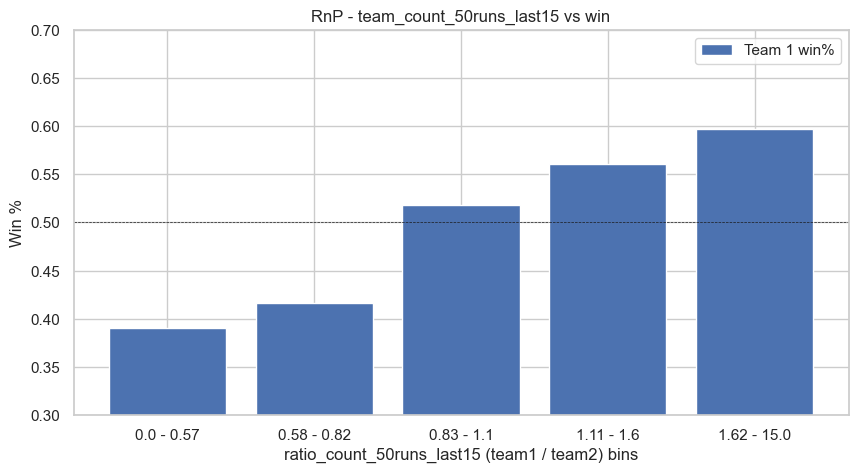

Correlation between team_count_50runs_last15 and winner_01 is: -0.11632710368127931


In [11]:
createRnP(train_data, 'team_count_50runs_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


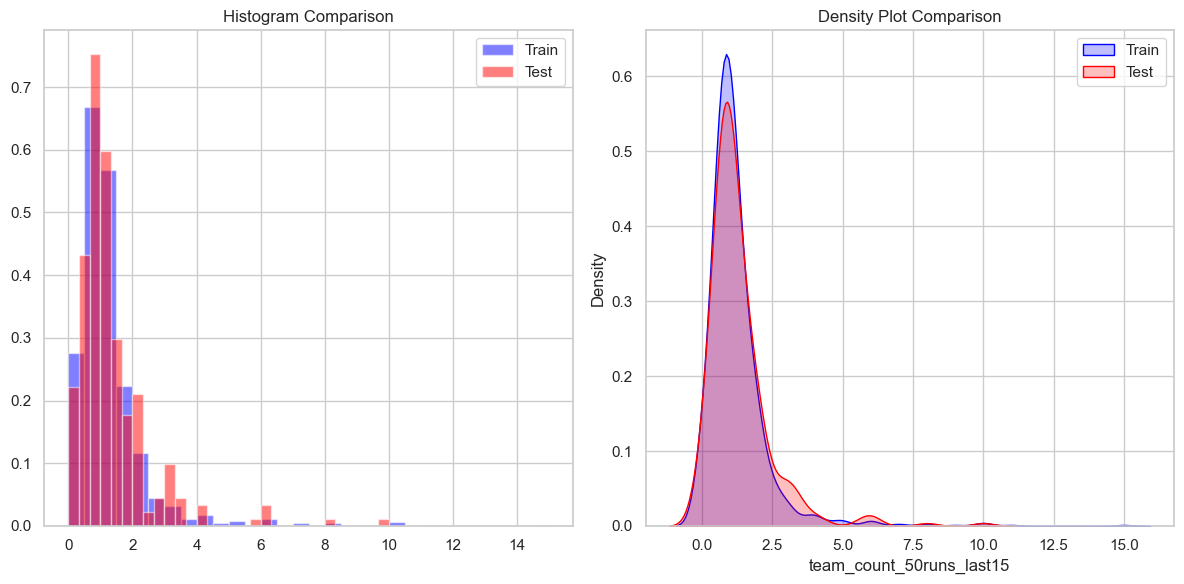

Kolmogorov-Smirnov test result: KS statistic = 0.0578, p-value = 0.4595

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.222363    1.303374
std       1.224666    1.180753
min       0.000000    0.000000
25%       0.636364    0.685855
50%       1.000000    1.000000
75%       1.446970    1.563492
max      15.000000   10.000000


In [12]:
check_distribution_match(train_data['team_count_50runs_last15'], test_data['team_count_50runs_last15'])

In [13]:
remove_skew(train_data, 'team_count_50runs_last15', 'quantile')
remove_skew(test_data, 'team_count_50runs_last15', 'quantile', train=False)

Skewness of team_count_50runs_last15 was 4.704864290536163. square root transformation applied. New skewness is 0.9991356907137633
Skewness of team_count_50runs_last15 was 3.3175332522300485. square root transformation applied. New skewness is 0.7858804038946939


slope: 0.6 / 0.39 =  1.53


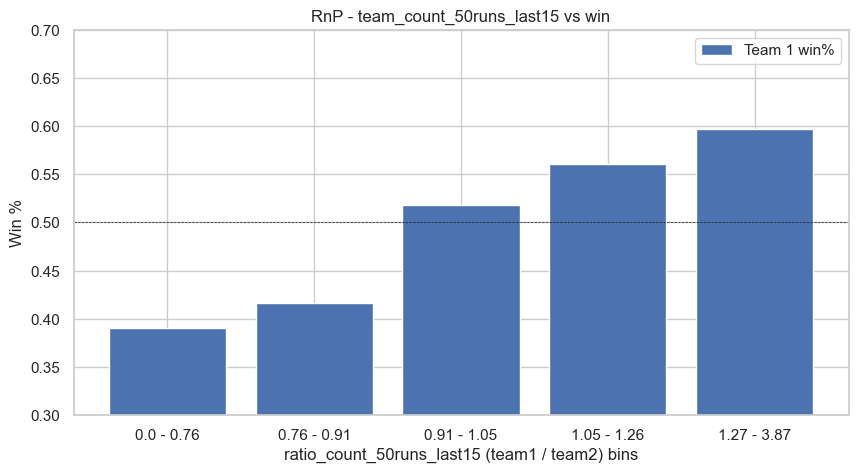

Correlation between team_count_50runs_last15 and winner_01 is: -0.1478596124198269


In [14]:
createRnP(train_data, 'team_count_50runs_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


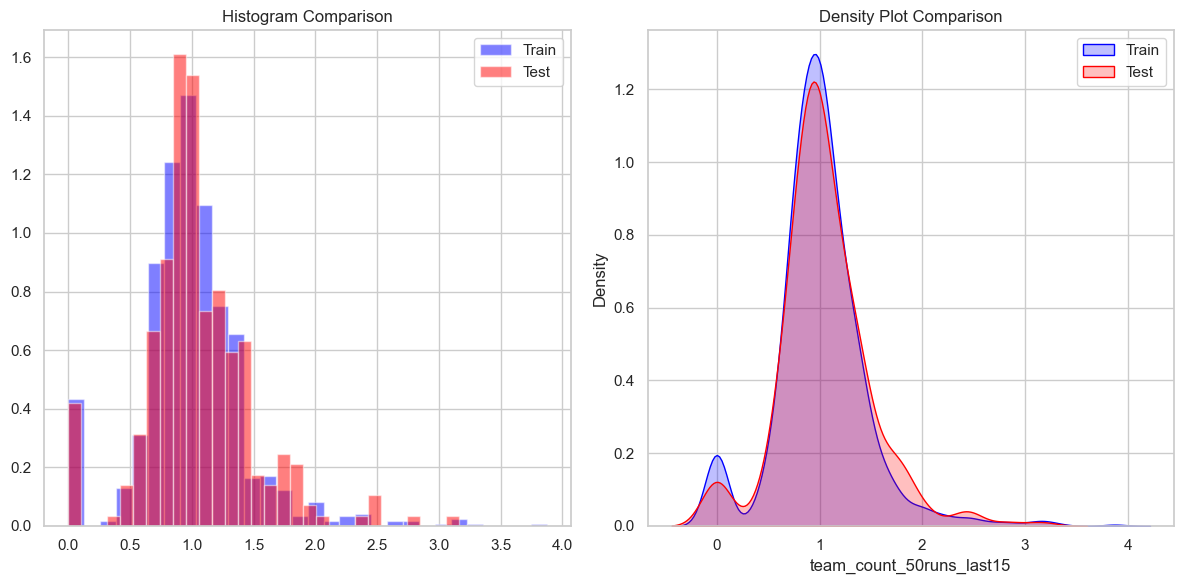

Kolmogorov-Smirnov test result: KS statistic = 0.0578, p-value = 0.4595

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.009808e+00  1.050375e+00
std    4.504063e-01  4.481367e-01
min    1.490116e-08  1.490116e-08
25%    7.977240e-01  8.281632e-01
50%    1.000000e+00  1.000000e+00
75%    1.202899e+00  1.250393e+00
max    3.872983e+00  3.162278e+00


In [15]:
check_distribution_match(train_data['team_count_50runs_last15'], test_data['team_count_50runs_last15'])

### team_wicket_loss_average

In [16]:
def team_wicket_loss_average(team_id, date, match_lvl_data):
    team_matches = match_lvl_data[
        (match_lvl_data['match_dt'] < date) &
        ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))
    ]
    team_wickets = team_matches.apply(
        lambda x: x['inning1_wickets'] if x['team1_id'] == team_id else x['inning2_wickets'], axis=1
    )
    return team_wickets.mean() if len(team_wickets) > 0 else 0

In [17]:
train_data['team1_wicket_loss_average'] = train_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data['team2_wicket_loss_average'] = train_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data = add_ratio_column(train_data, 'team1_wicket_loss_average', 'team2_wicket_loss_average', 'team_wicket_loss_average')

train_data = train_data.drop(columns=['team1_wicket_loss_average', 'team2_wicket_loss_average'])

test_data['team1_wicket_loss_average'] = test_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data['team2_wicket_loss_average'] = test_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data = add_ratio_column(test_data, 'team1_wicket_loss_average', 'team2_wicket_loss_average', 'team_wicket_loss_average')

test_data = test_data.drop(columns=['team1_wicket_loss_average', 'team2_wicket_loss_average'])

slope: 0.53 / 0.47 =  1.14


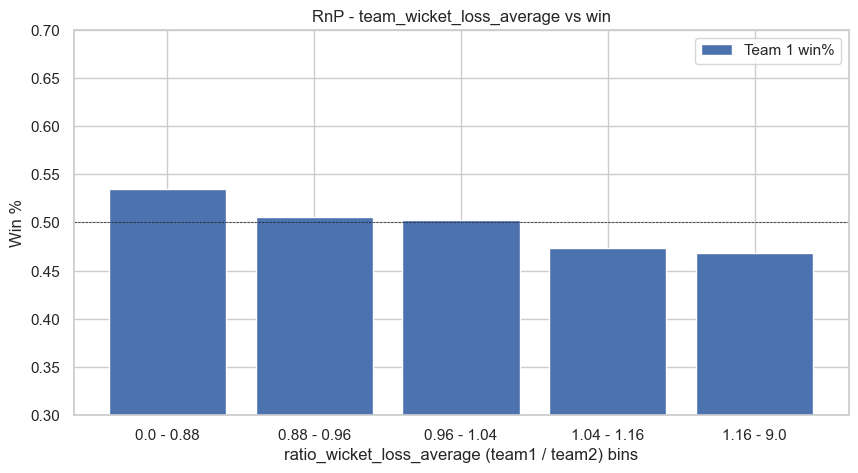

Correlation between team_wicket_loss_average and winner_01 is: -0.012728204099509413


In [18]:
createRnP(train_data, 'team_wicket_loss_average')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


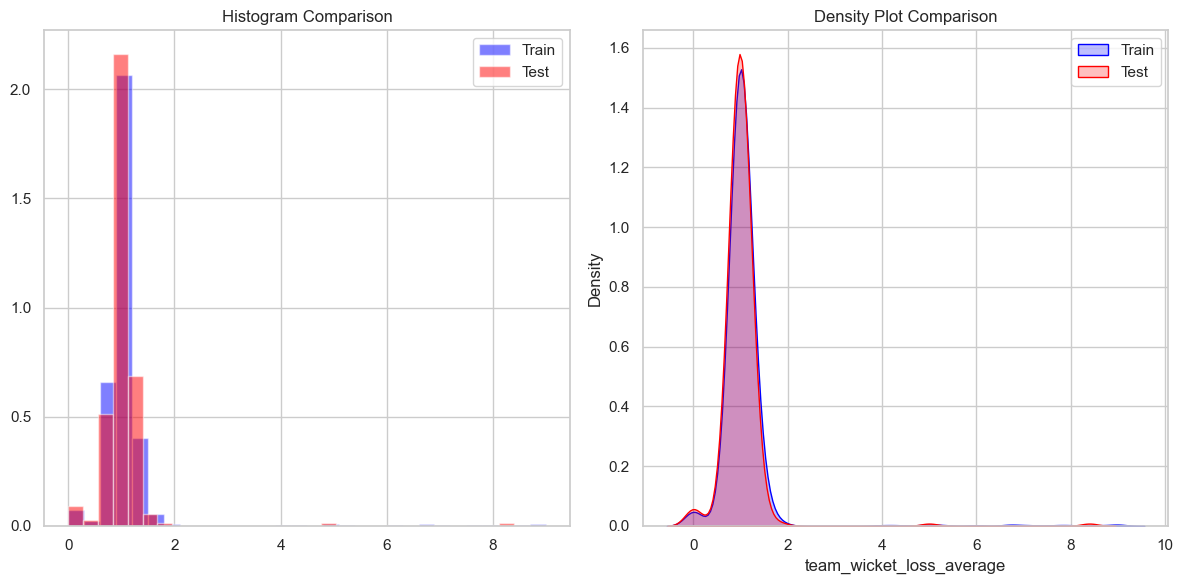

Kolmogorov-Smirnov test result: KS statistic = 0.1095, p-value = 0.0115

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.085126    1.012449
std       0.743221    0.563005
min       0.000000    0.000000
25%       0.909314    0.877306
50%       1.008309    0.985822
75%       1.122680    1.095405
max       9.000000    8.400000


In [19]:
check_distribution_match(train_data['team_wicket_loss_average'], test_data['team_wicket_loss_average'])

In [20]:
remove_skew(train_data, 'team_wicket_loss_average', 'quantile')
remove_skew(test_data, 'team_wicket_loss_average', 'quantile', train=False)

Skewness of team_wicket_loss_average was 7.615976105642051. square root transformation applied. New skewness is 2.234135593987829
Skewness of team_wicket_loss_average was 9.614507633194362. square root transformation applied. New skewness is 0.8116487773769584


slope: 0.53 / 0.47 =  1.14


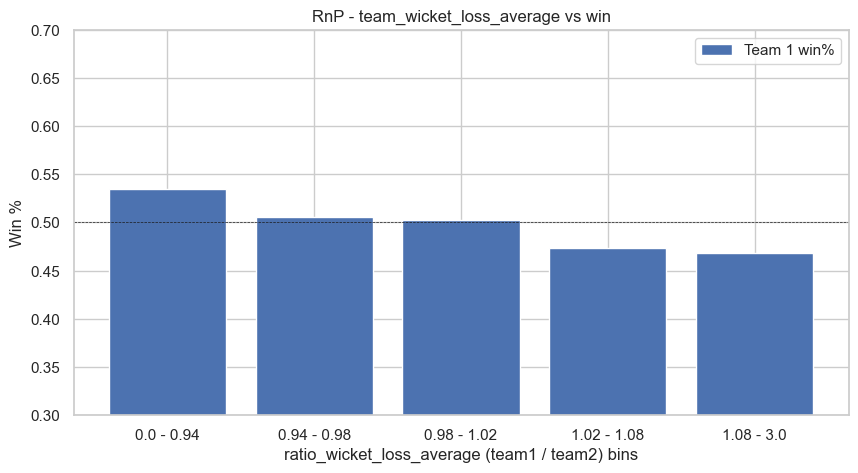

Correlation between team_wicket_loss_average and winner_01 is: -0.012342311316931545


In [21]:
createRnP(train_data, 'team_wicket_loss_average')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


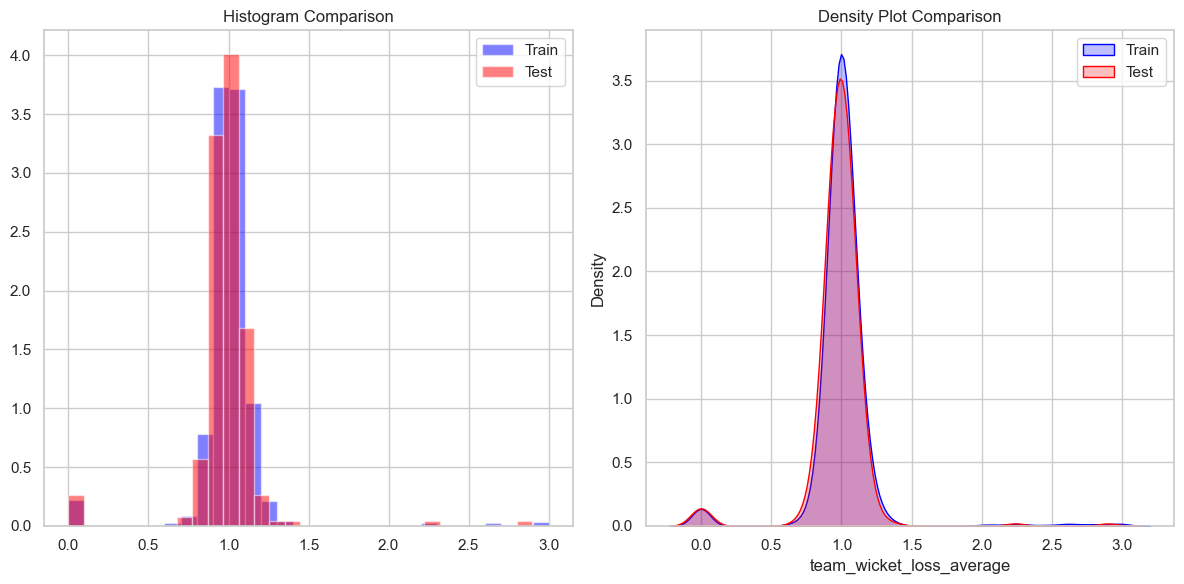

Kolmogorov-Smirnov test result: KS statistic = 0.1095, p-value = 0.0115

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.009104e+00  9.802479e-01
std    2.586611e-01  2.274954e-01
min    1.490116e-08  1.490116e-08
25%    9.535797e-01  9.366462e-01
50%    1.004146e+00  9.928858e-01
75%    1.059566e+00  1.046616e+00
max    3.000000e+00  2.898275e+00


In [22]:
check_distribution_match(train_data['team_wicket_loss_average'], test_data['team_wicket_loss_average'])

### team_bowler_performance_ratio

In [23]:
#new feature 1 bowler's performance of teams in recent mathes
def team_bowler_performance_recent(bowler_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_impact_score = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        if not recent_matches.empty:
            player_impact = (recent_matches['wicket_count']) * 5 + recent_matches['dots']*1.5+(recent_matches['maiden']) * 1.5 -(recent_matches['Fours'] * 1) - recent_matches['Sixes']*1.5 - recent_matches['wides'] - recent_matches['noballs']                            
            total_impact_score += player_impact.sum()

    return total_impact_score

In [24]:
train_data['team1_bowler_performance_recent'] = train_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_bowler_performance_recent'] = train_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)
train_data = add_ratio_column(train_data, 'team1_bowler_performance_recent', 'team2_bowler_performance_recent', 'team_bowler_performance_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1_bowler_performance_recent', 'team2_bowler_performance_recent'])

test_data['team1_bowler_performance_recent'] = test_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_bowler_performance_recent'] = test_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)
test_data = add_ratio_column(test_data, 'team1_bowler_performance_recent', 'team2_bowler_performance_recent', 'team_bowler_performance_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_bowler_performance_recent', 'team2_bowler_performance_recent'])

slope: 0.61 / 0.34 =  1.8


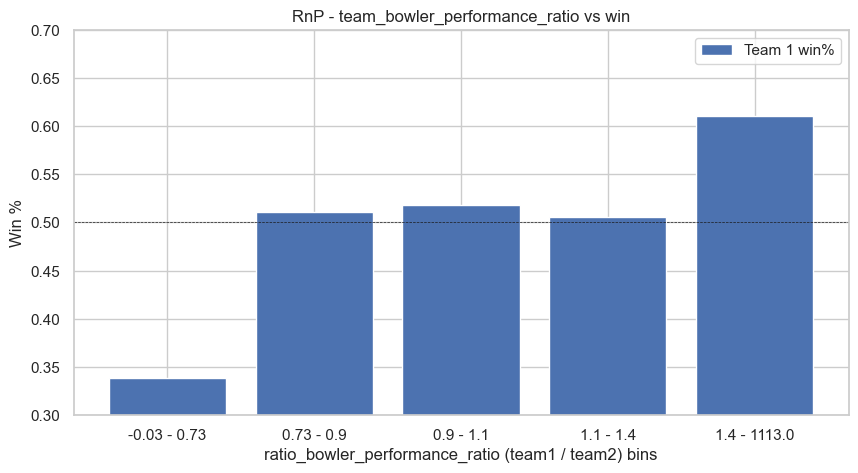

Correlation between team_bowler_performance_ratio and winner_01 is: -0.05037630480130837


In [25]:
createRnP(train_data, 'team_bowler_performance_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


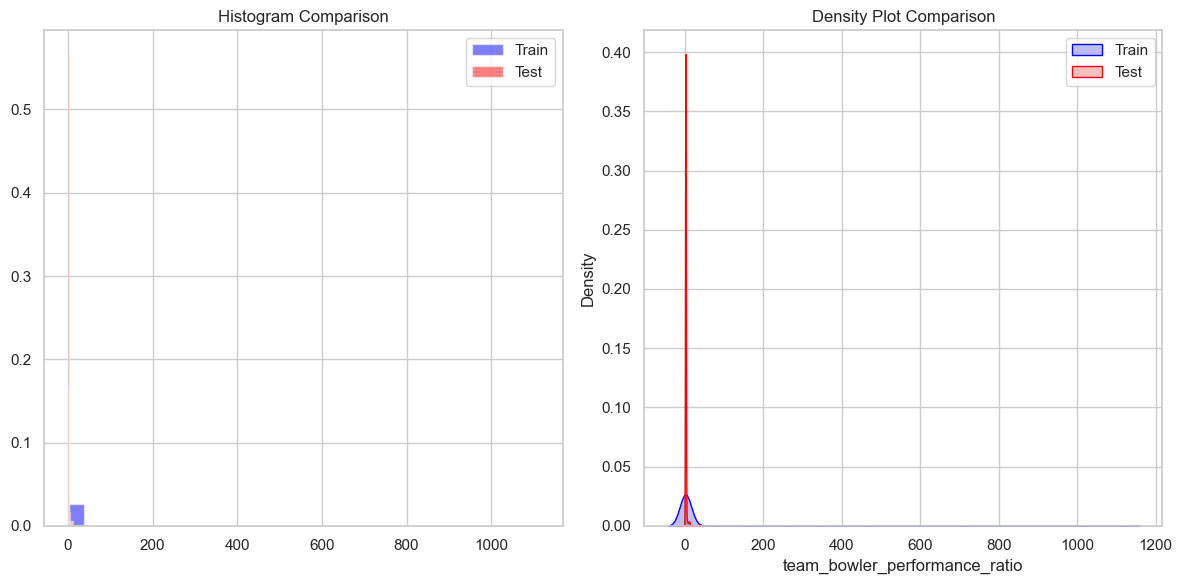

Kolmogorov-Smirnov test result: KS statistic = 0.1057, p-value = 0.0166

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      5.618912    1.420354
std      57.700298    2.597474
min      -0.028103    0.000000
25%       0.790858    0.826576
50%       0.981911    1.051232
75%       1.284090    1.334909
max    1113.000000   38.500000


In [26]:
check_distribution_match(train_data['team_bowler_performance_ratio'], test_data['team_bowler_performance_ratio'])

In [27]:
remove_skew(train_data, 'team_bowler_performance_ratio', 'quantile')
remove_skew(test_data, 'team_bowler_performance_ratio', 'quantile', train=False)

Skewness of team_bowler_performance_ratio was 15.727021194757878. square root transformation applied. New skewness is 12.0655044513194
Skewness of team_bowler_performance_ratio was 11.446400247125148. square root transformation applied. New skewness is 5.15580832803534


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


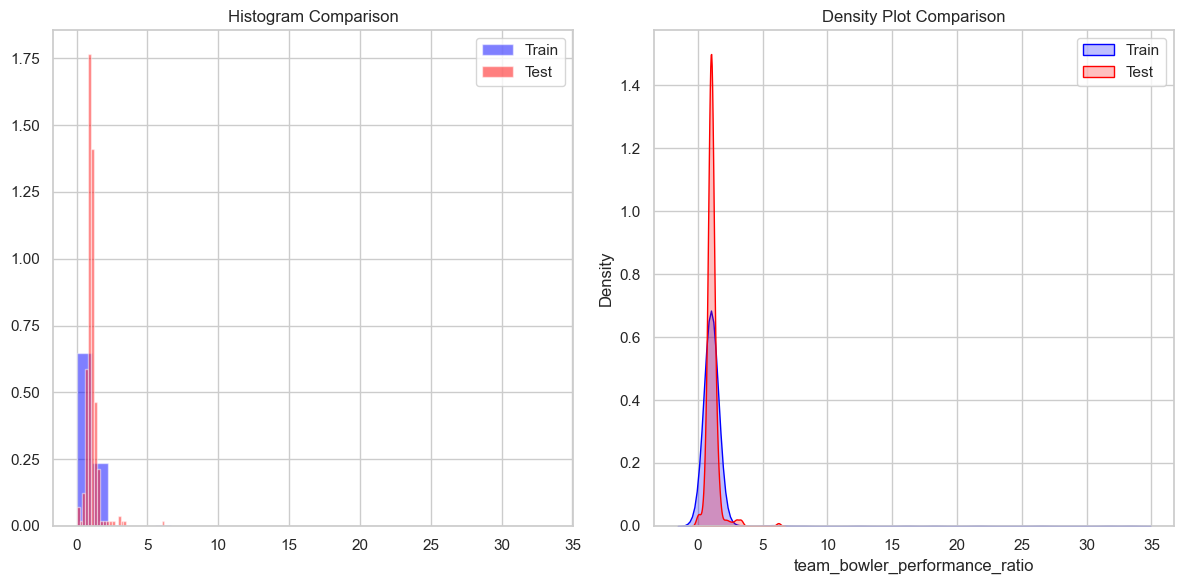

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.470000e+02  2.710000e+02
mean   1.207204e+00  1.082799e+00
std    2.042532e+00  4.988170e-01
min    1.490116e-08  1.490116e-08
25%    8.904488e-01  9.091624e-01
50%    9.912279e-01  1.025296e+00
75%    1.134075e+00  1.155382e+00
max    3.336165e+01  6.204837e+00


In [28]:
check_distribution_match(train_data['team_bowler_performance_ratio'], test_data['team_bowler_performance_ratio'])

slope: 0.61 / 0.33 =  1.83


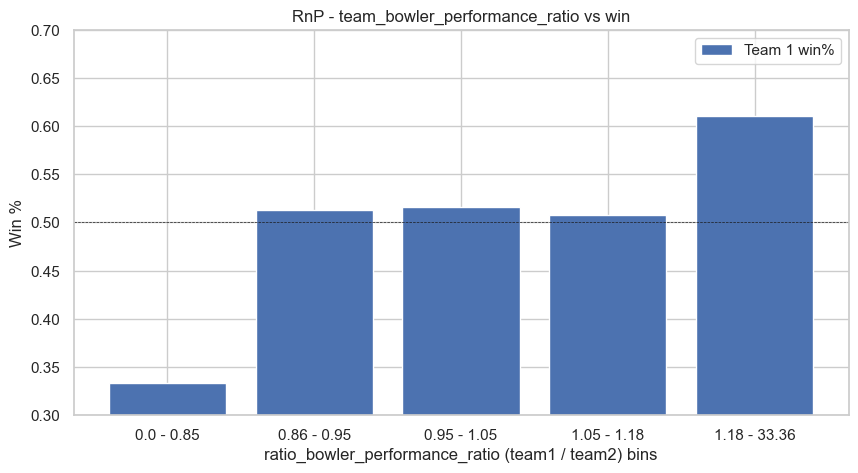

Correlation between team_bowler_performance_ratio and winner_01 is: -0.07221437382126368


In [29]:
createRnP(train_data, 'team_bowler_performance_ratio')

### team_strike_rate

In [30]:
def calculate_batsman_strike_rate(player_list, date, n):
    player_list = str(player_list).split(':')  # Split string of ':' separated ids into a list of ids
    res_list = []

    for player in player_list:
        recent_matches = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        runs = recent_matches['runs'].sum()
        balls = recent_matches['balls_faced'].sum()

        # Calculate strike rate and avoid division by zero
        if balls > 0:
            strike_rate = (runs / balls) * 100
        else:
            strike_rate = 0

        res_list.append(strike_rate)

    # Calculate the average strike rate across all players in the list
    if res_list:  # Ensure the list is not empty to avoid division by zero
        average_strike_rate = sum(res_list) / len(res_list)
    else:
        average_strike_rate = 0

    return average_strike_rate

In [31]:
train_data['team1_strike_rate'] = train_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_strike_rate'] = train_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_strike_rate', 'team2_strike_rate', 'team_strike_rate')

train_data = train_data.drop(columns=['team1_strike_rate', 'team2_strike_rate'])

test_data['team1_strike_rate'] = test_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_strike_rate'] = test_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_strike_rate', 'team2_strike_rate', 'team_strike_rate')

test_data = test_data.drop(columns=['team1_strike_rate', 'team2_strike_rate'])

100%|██████████| 271/271 [00:02<00:00, 97.68it/s]


slope: 0.55 / 0.42 =  1.32


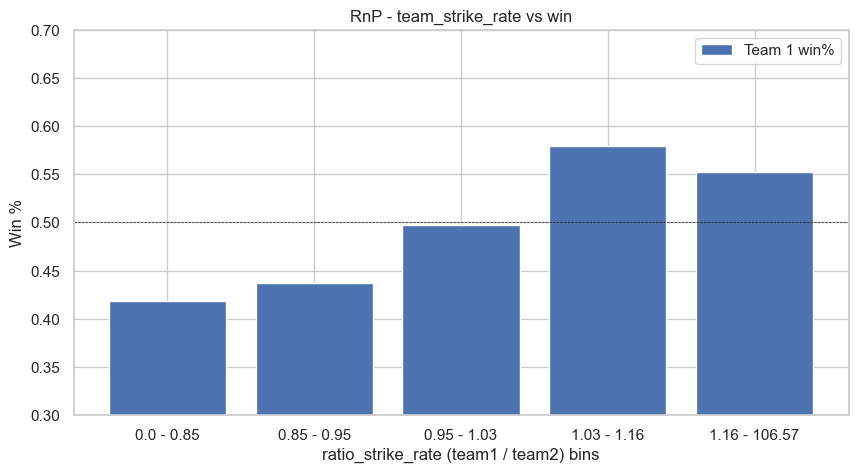

Correlation between team_strike_rate and winner_01 is: -0.046993779948201454


In [32]:
createRnP(train_data, 'team_strike_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


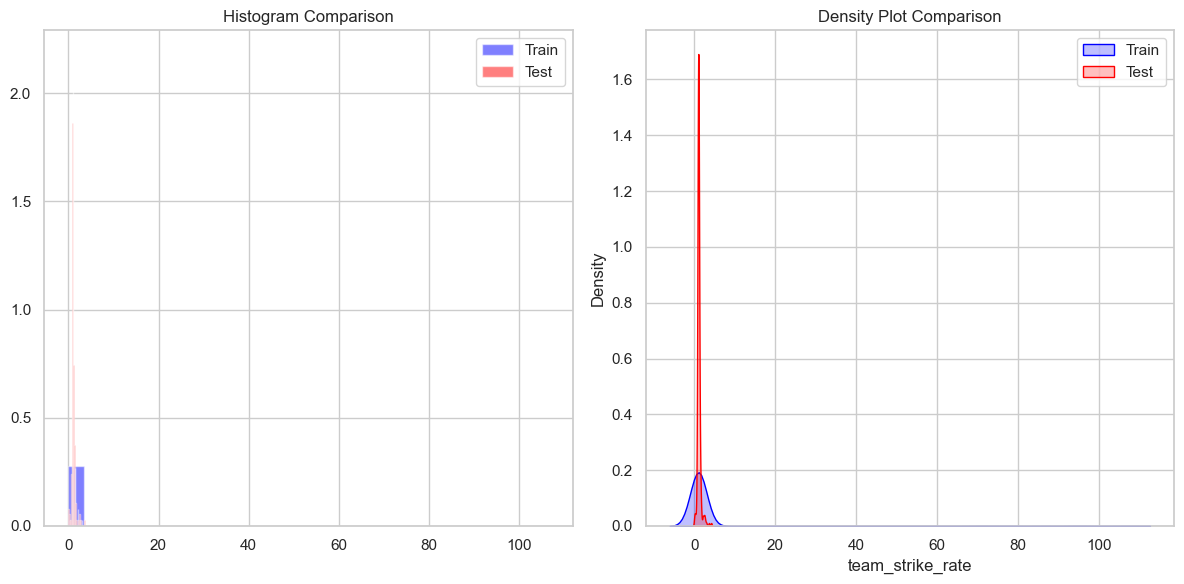

Kolmogorov-Smirnov test result: KS statistic = 0.0542, p-value = 0.5419

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.752818    1.056381
std       7.980454    0.426486
min       0.000000    0.000000
25%       0.887845    0.885572
50%       0.997539    0.998391
75%       1.115476    1.108754
max     106.574684    4.162338


In [33]:
check_distribution_match(train_data['team_strike_rate'], test_data['team_strike_rate'])

In [34]:
remove_skew(train_data, 'team_strike_rate', 'quantile')
remove_skew(test_data, 'team_strike_rate', 'quantile', train=False)

Skewness of team_strike_rate was 11.035006539460246. square root transformation applied. New skewness is 9.901105247780674
Skewness of team_strike_rate was 3.2116043492120885. square root transformation applied. New skewness is 0.2645607593326873


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


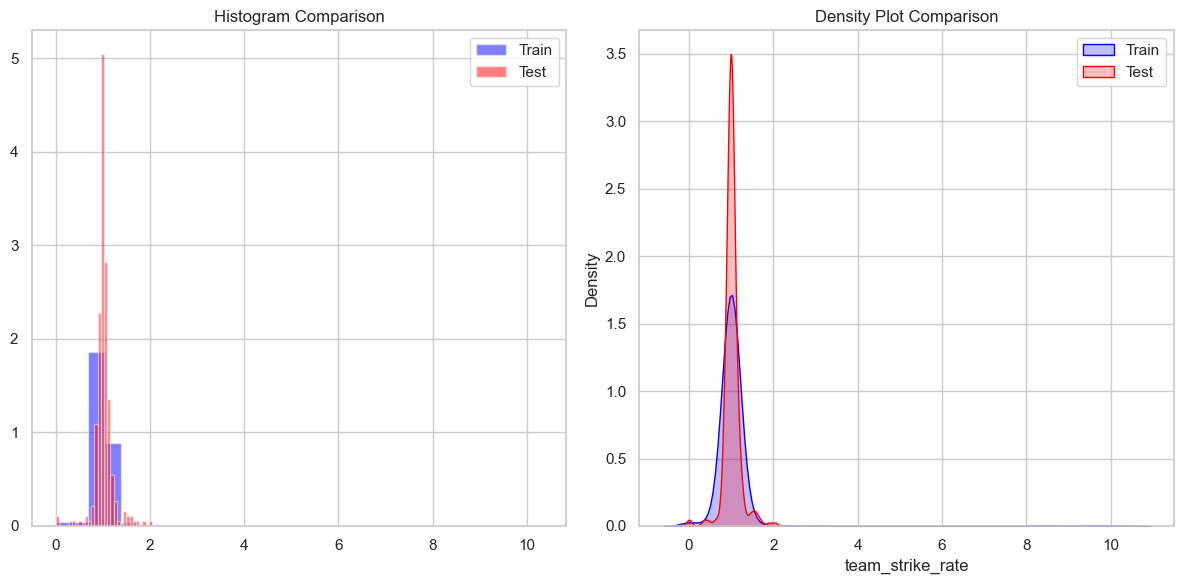

Kolmogorov-Smirnov test result: KS statistic = 0.0542, p-value = 0.5419

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.064358e+00  1.009083e+00
std    7.877920e-01  1.956356e-01
min    1.490116e-08  1.490116e-08
25%    9.422554e-01  9.410484e-01
50%    9.987688e-01  9.991951e-01
75%    1.056161e+00  1.052972e+00
max    1.032350e+01  2.040181e+00


In [35]:
check_distribution_match(train_data['team_strike_rate'], test_data['team_strike_rate'])

slope: 0.55 / 0.42 =  1.32


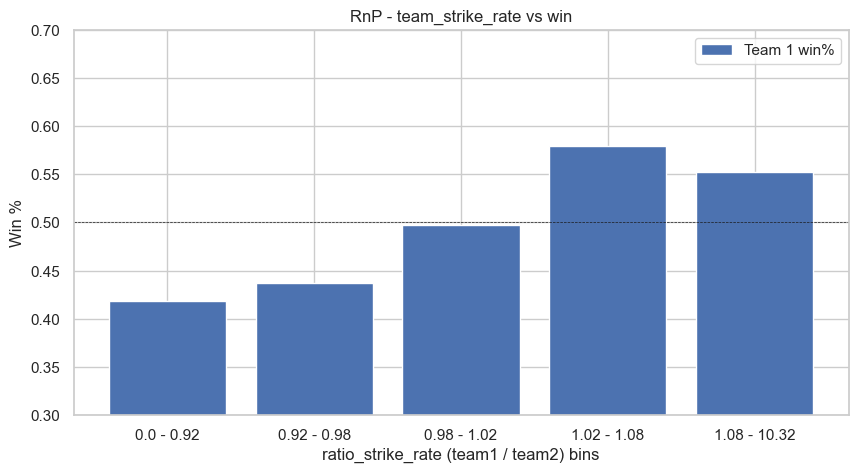

Correlation between team_strike_rate and winner_01 is: -0.06536014934058837


In [36]:
createRnP(train_data, 'team_strike_rate')

### team_avg_wicket

In [37]:
def average_wickets_taken(player_list, date, n):
    player_list = player_list.split(':')
    wickets_list = []
    for player_id in player_list:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        total_wickets = recent_matches['wicket_count'].sum()
        average_wickets = total_wickets / n if n > 0 else 0
        wickets_list.append(average_wickets)
    return sum(wickets_list) / len(wickets_list) if wickets_list else 0

In [38]:
train_data['team1_avg_wicket'] = train_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_wicket'] = train_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wicket', 'team2_avg_wicket', 'team_avg_wicket')

train_data = train_data.drop(columns=['team1_avg_wicket', 'team2_avg_wicket'])

test_data['team1_avg_wicket'] = test_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_avg_wicket'] = test_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wicket', 'team2_avg_wicket', 'team_avg_wicket')

test_data = test_data.drop(columns=['team1_avg_wicket', 'team2_avg_wicket'])

100%|██████████| 271/271 [00:02<00:00, 125.30it/s]


slope: 0.55 / 0.42 =  1.32


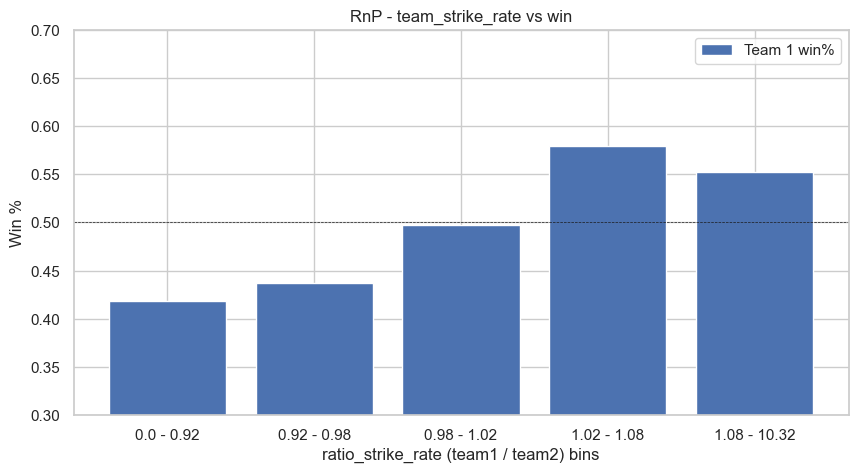

Correlation between team_strike_rate and winner_01 is: -0.06536014934058837


In [39]:
createRnP(train_data, 'team_strike_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


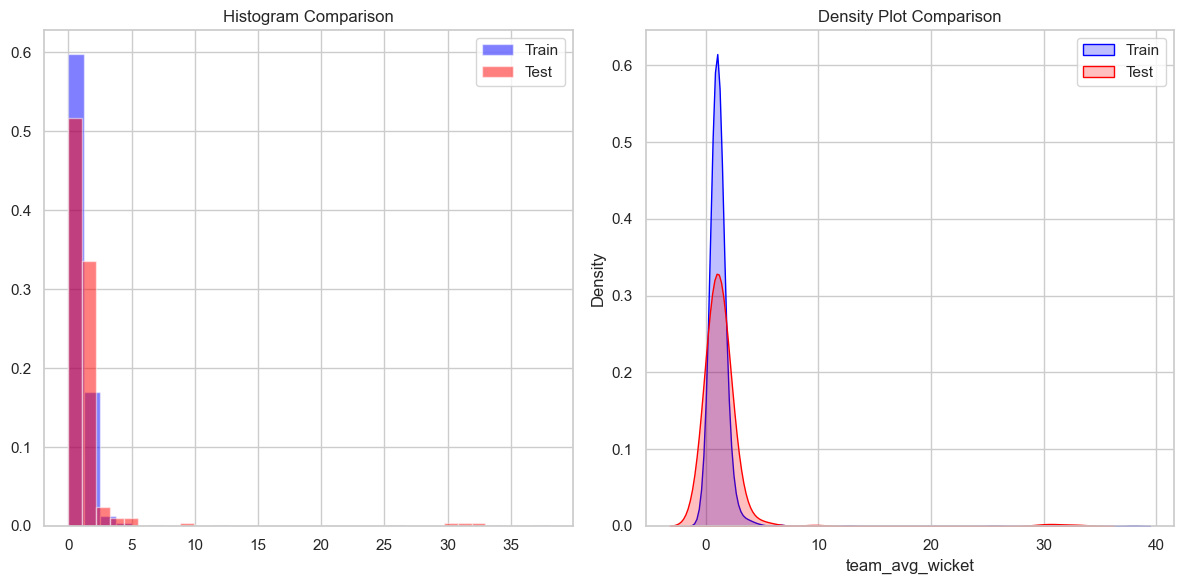

Kolmogorov-Smirnov test result: KS statistic = 0.0673, p-value = 0.2792

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.190463    1.501683
std       1.913690    3.281587
min       0.000000    0.000000
25%       0.785714    0.776298
50%       0.988300    1.000000
75%       1.258155    1.343919
max      38.000000   33.000000


In [40]:
check_distribution_match(train_data['team_avg_wicket'], test_data['team_avg_wicket'])

In [41]:
remove_skew(train_data, 'team_avg_wicket', 'quantile')
remove_skew(test_data, 'team_avg_wicket', 'quantile', train=False)

Skewness of team_avg_wicket was 14.911101277827377. square root transformation applied. New skewness is 5.462717293280892
Skewness of team_avg_wicket was 8.521517093352115. square root transformation applied. New skewness is 5.487355012216038


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


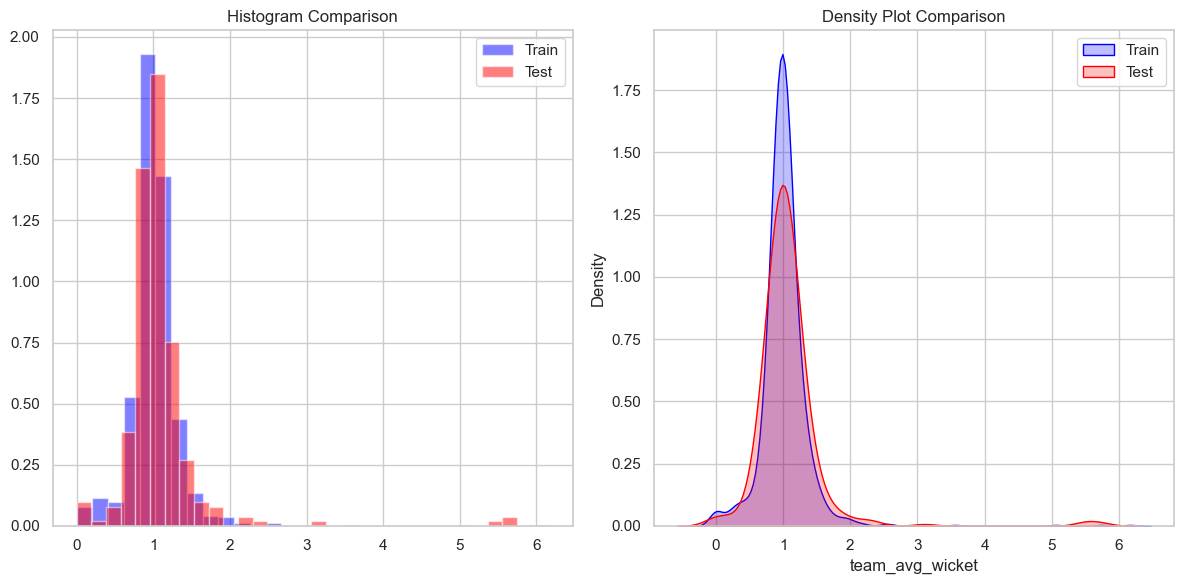

Kolmogorov-Smirnov test result: KS statistic = 0.0673, p-value = 0.2792

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.016341e+00  1.080855e+00
std    3.970891e-01  5.785068e-01
min    1.490116e-08  1.490116e-08
25%    8.864053e-01  8.810777e-01
50%    9.941330e-01  1.000000e+00
75%    1.121675e+00  1.159272e+00
max    6.164414e+00  5.744563e+00


In [42]:
check_distribution_match(train_data['team_avg_wicket'], test_data['team_avg_wicket'])

slope: 0.6 / 0.39 =  1.55


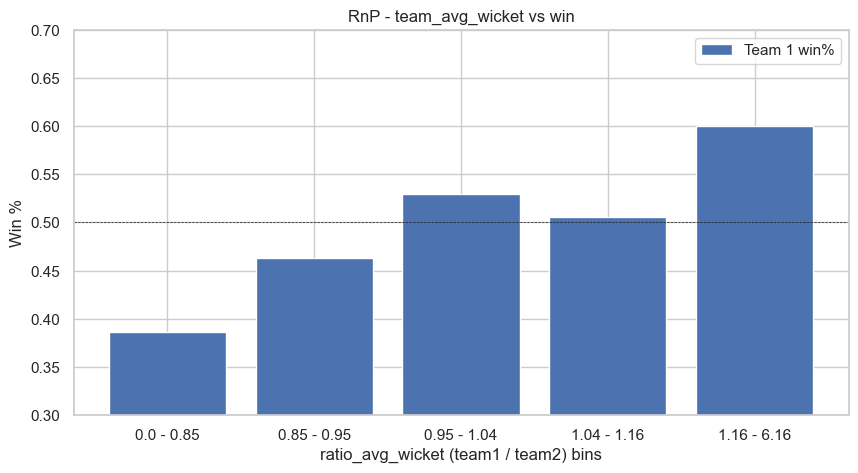

Correlation between team_avg_wicket and winner_01 is: -0.15474188230348332


In [43]:
createRnP(train_data, 'team_avg_wicket')

### team_batting_strength

In [44]:
def team_batting_strength(player_list, date, n):
    players = player_list.split(':')
    total_runs = 0
    for player_id in players:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        total_runs += recent_matches['runs'].sum()
    return total_runs / len(players) if players else 0

In [45]:
train_data['team1_batting_strength'] = train_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_batting_strength'] = train_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_batting_strength', 'team2_batting_strength', 'team_batting_strength')

train_data = train_data.drop(columns=['team1_batting_strength', 'team2_batting_strength'])

test_data['team1_batting_strength'] = test_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_batting_strength'] = test_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_batting_strength', 'team2_batting_strength', 'team_batting_strength')

test_data = test_data.drop(columns=['team1_batting_strength', 'team2_batting_strength'])

100%|██████████| 271/271 [00:02<00:00, 101.13it/s]


slope: 0.64 / 0.34 =  1.88


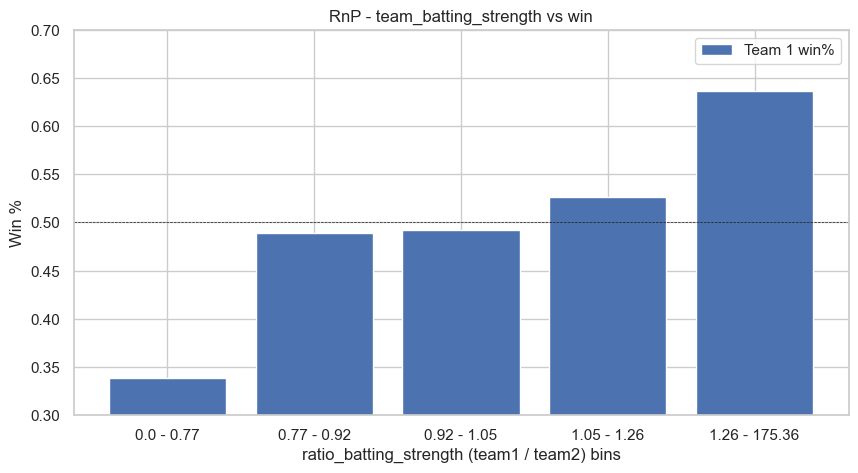

Correlation between team_batting_strength and winner_01 is: -0.06285430528267014


In [46]:
createRnP(train_data, 'team_batting_strength')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


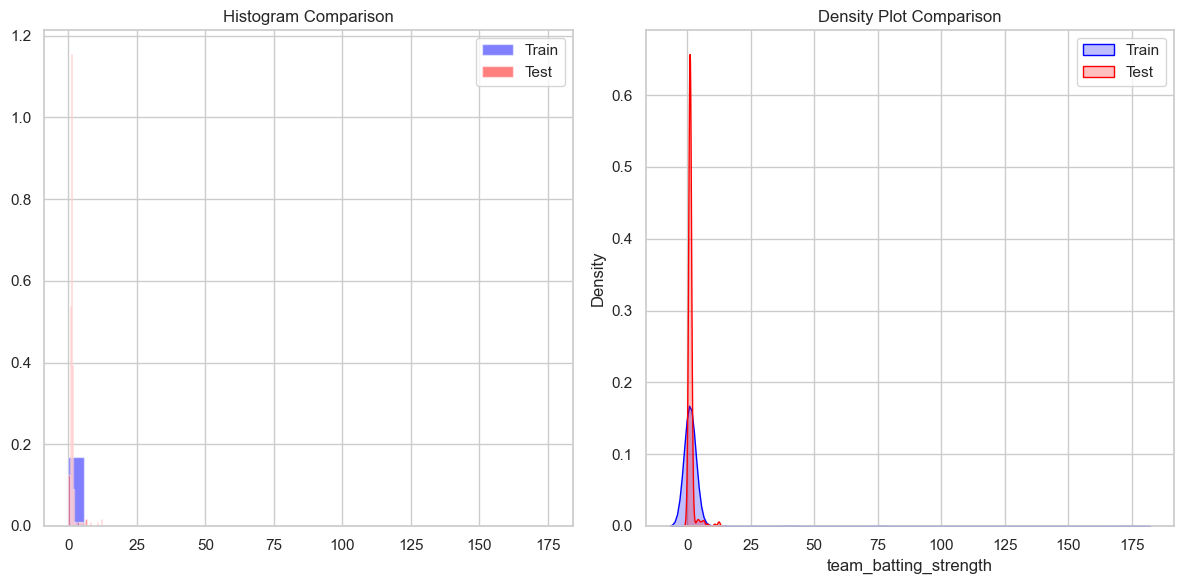

Kolmogorov-Smirnov test result: KS statistic = 0.0519, p-value = 0.5989

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.791761    1.270211
std       8.971790    1.436063
min       0.000000    0.000000
25%       0.813151    0.815097
50%       0.978937    0.993631
75%       1.189842    1.239880
max     175.363636   12.362069


In [47]:
check_distribution_match(train_data['team_batting_strength'], test_data['team_batting_strength'])

In [48]:
remove_skew(train_data, 'team_batting_strength', 'quantile')
remove_skew(test_data, 'team_batting_strength', 'quantile', train=False)

Skewness of team_batting_strength was 16.213935546162297. square root transformation applied. New skewness is 10.31694793014039
Skewness of team_batting_strength was 5.504598474931442. square root transformation applied. New skewness is 3.0940150612404396


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


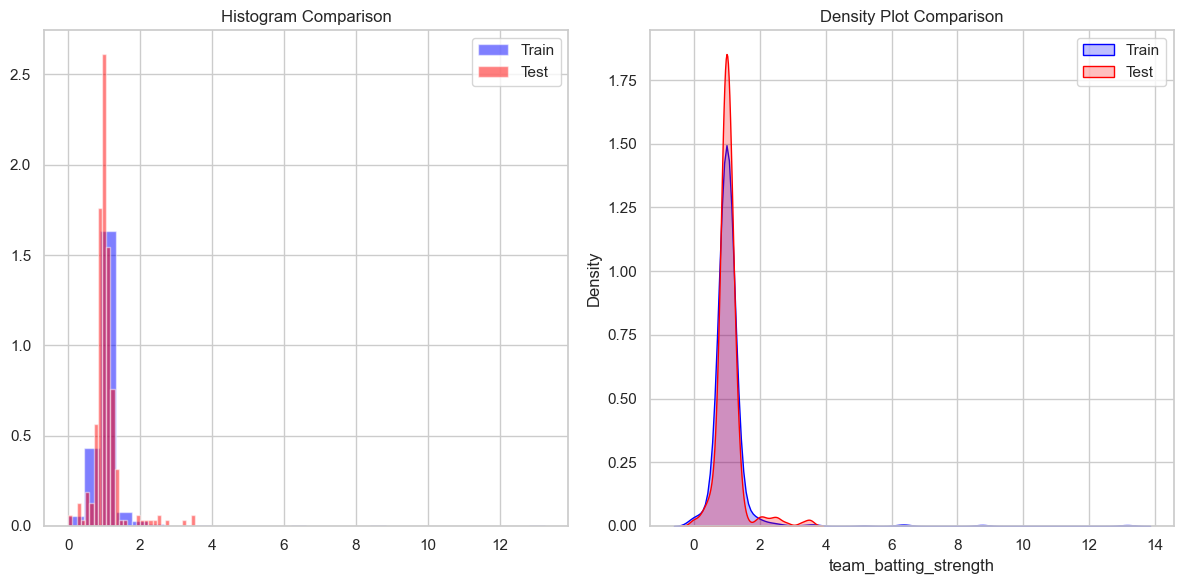

Kolmogorov-Smirnov test result: KS statistic = 0.0519, p-value = 0.5989

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.073113e+00  1.051408e+00
std    8.005401e-01  4.066470e-01
min    1.490116e-08  1.490116e-08
25%    9.017490e-01  9.028273e-01
50%    9.894125e-01  9.968102e-01
75%    1.090799e+00  1.113498e+00
max    1.324249e+01  3.515973e+00


In [49]:
check_distribution_match(train_data['team_batting_strength'], test_data['team_batting_strength'])

slope: 0.64 / 0.34 =  1.88


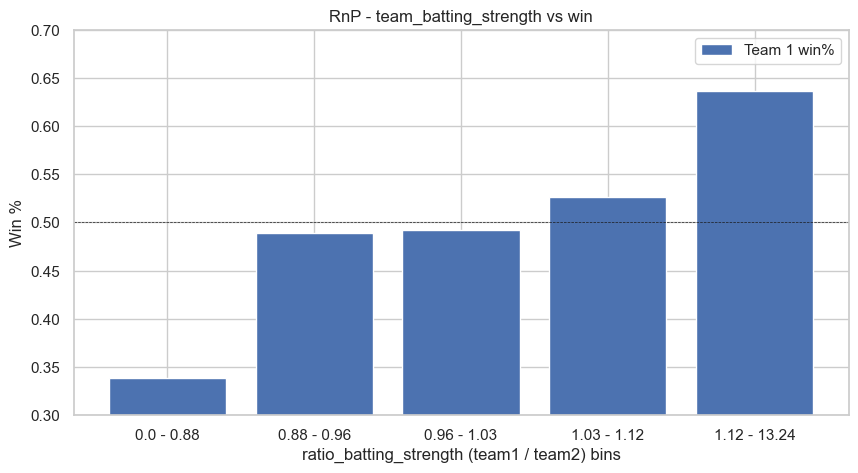

Correlation between team_batting_strength and winner_01 is: -0.10574790213066529


In [50]:
createRnP(train_data, 'team_batting_strength')

### team_win_rate_at_venue

In [51]:
def team_win_rate_at_venue(team_id, venue_id, date, match_lvl_data):
    # Filter matches where the team played at the given venue up to the specified date
    relevant_matches = match_lvl_data[(match_lvl_data['ground_id'] == venue_id) &
                                      ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                      (match_lvl_data['match_dt'] < date)]
    wins = relevant_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    win_rate = wins / len(relevant_matches) if len(relevant_matches) > 0 else 0
    return win_rate

In [52]:
train_data['team1_win_rate_at_venue'] = train_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team1_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data['team2_win_rate_at_venue'] = train_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team2_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data = add_ratio_column(train_data, 'team1_win_rate_at_venue', 'team2_win_rate_at_venue', 'team_win_rate_at_venue')

train_data = train_data.drop(columns=['team1_win_rate_at_venue', 'team2_win_rate_at_venue'])

test_data['team1_win_rate_at_venue'] = test_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team1_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data['team2_win_rate_at_venue'] = test_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team2_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data = add_ratio_column(test_data, 'team1_win_rate_at_venue', 'team2_win_rate_at_venue', 'team_win_rate_at_venue')

test_data = test_data.drop(columns=['team1_win_rate_at_venue', 'team2_win_rate_at_venue'])

slope: 0.56 / 0.47 =  1.2


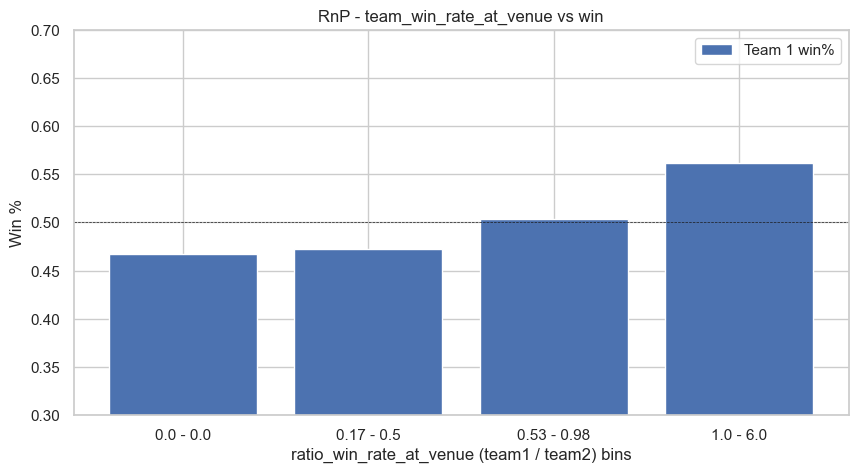

Correlation between team_win_rate_at_venue and winner_01 is: -0.053605345112640965


In [53]:
createRnP(train_data, 'team_win_rate_at_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


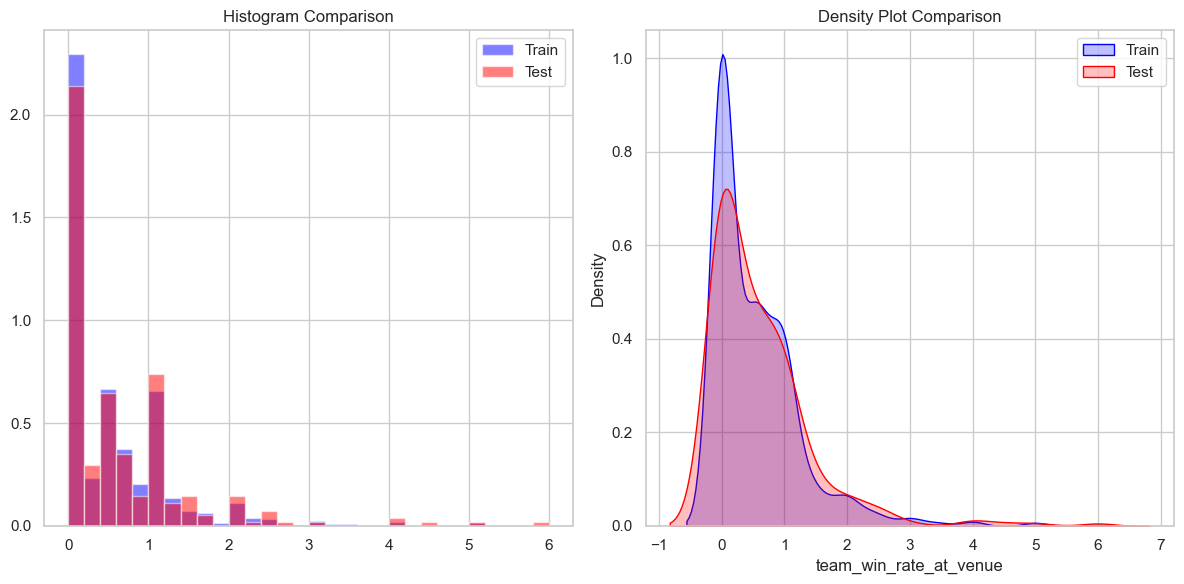

Kolmogorov-Smirnov test result: KS statistic = 0.0447, p-value = 0.7729

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.542736    0.610468
std       0.740733    0.848285
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.375000    0.428571
75%       0.930804    1.000000
max       6.000000    6.000000


In [54]:
check_distribution_match(train_data['team_win_rate_at_venue'], test_data['team_win_rate_at_venue'])

In [55]:
remove_skew(train_data, 'team_win_rate_at_venue', 'sqrt')
remove_skew(test_data, 'team_win_rate_at_venue', 'sqrt', train=False)

Skewness of team_win_rate_at_venue was 2.4483816809082177. square root transformation applied. New skewness is 0.49931501023368924
Skewness of team_win_rate_at_venue was 2.6971569822552794. square root transformation applied. New skewness is 0.5378531493490643


slope: 0.56 / 0.47 =  1.2


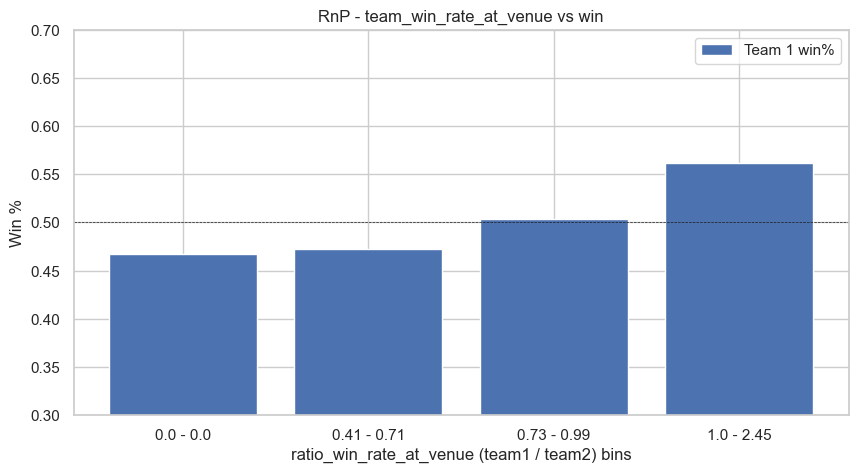

Correlation between team_win_rate_at_venue and winner_01 is: -0.06309475777326962


In [56]:
createRnP(train_data, 'team_win_rate_at_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


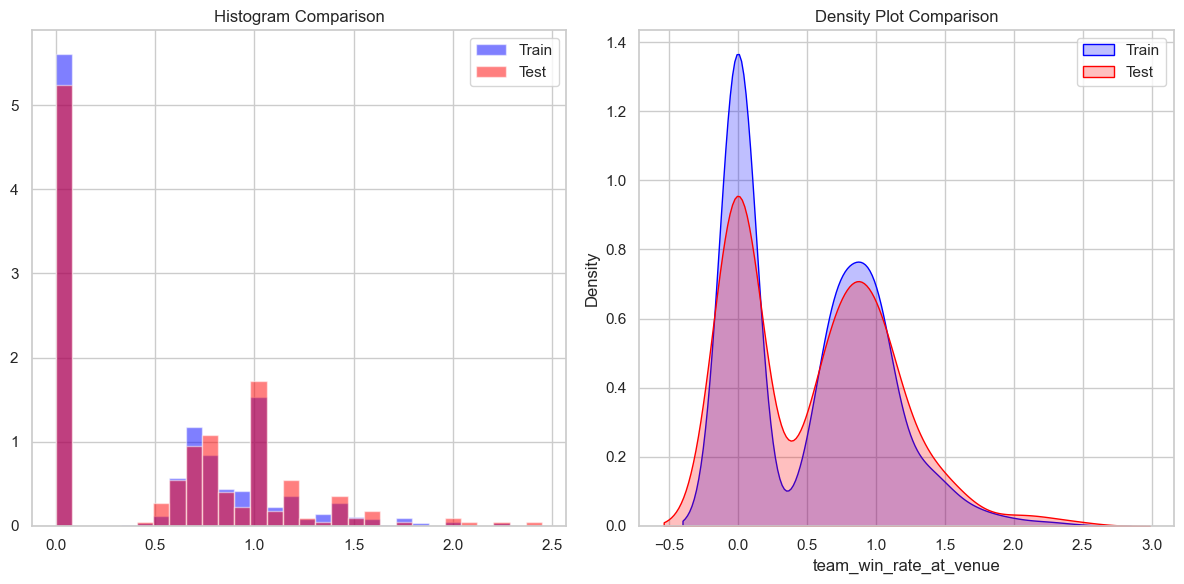

Kolmogorov-Smirnov test result: KS statistic = 0.0447, p-value = 0.7729

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   5.160304e-01  5.570362e-01
std    5.260618e-01  5.488994e-01
min    1.490116e-08  1.490116e-08
25%    1.490116e-08  1.490116e-08
50%    6.123724e-01  6.546537e-01
75%    9.647795e-01  1.000000e+00
max    2.449490e+00  2.449490e+00


In [57]:
check_distribution_match(train_data['team_win_rate_at_venue'], test_data['team_win_rate_at_venue'])

### team_batsman_performance_index

In [58]:
def team_batsman_performance_index(bat_df, match_id, team_roster_ids, date, n=5):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] * 0.5 +
                                  recent_matches['strike_rate'] * 0.3 +
                                  (recent_matches['Fours'] + recent_matches['Sixes'] * 2) * 0.2) * \
                                  (1 + 0.1 * recent_matches['is_batsman_captain'].iloc[0] +
                                   0.05 * recent_matches['is_batsman_keeper'].iloc[0])
            total_performance_index += player_performance.sum()

    return total_performance_index

In [59]:
train_data['team1_batsman_performance_index'] = train_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)
train_data['team2_batsman_performance_index'] = train_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_batsman_performance_index', 'team2_batsman_performance_index', 'team_batsman_performance_index')

train_data = train_data.drop(columns=['team1_batsman_performance_index', 'team2_batsman_performance_index'])

test_data['team1_batsman_performance_index'] = test_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)
test_data['team2_batsman_performance_index'] = test_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_batsman_performance_index', 'team2_batsman_performance_index', 'team_batsman_performance_index')

test_data = test_data.drop(columns=['team1_batsman_performance_index', 'team2_batsman_performance_index'])

slope: 0.56 / 0.38 =  1.46


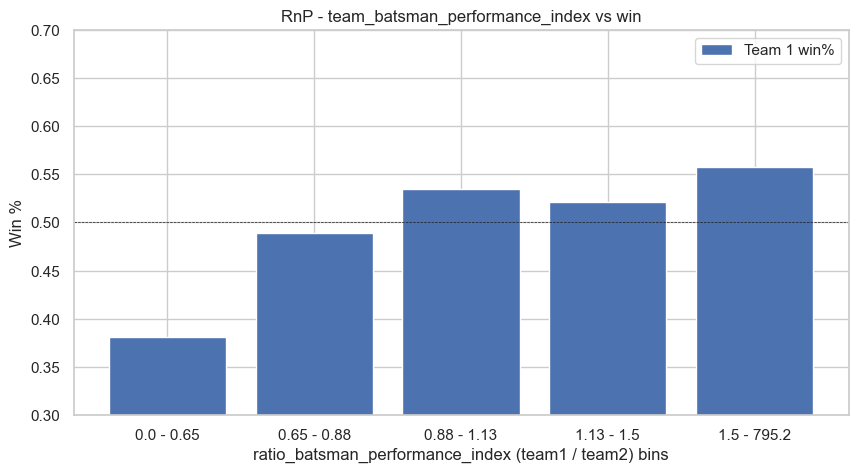

Correlation between team_batsman_performance_index and winner_01 is: -0.04003766613639936


In [60]:
createRnP(train_data, 'team_batsman_performance_index')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


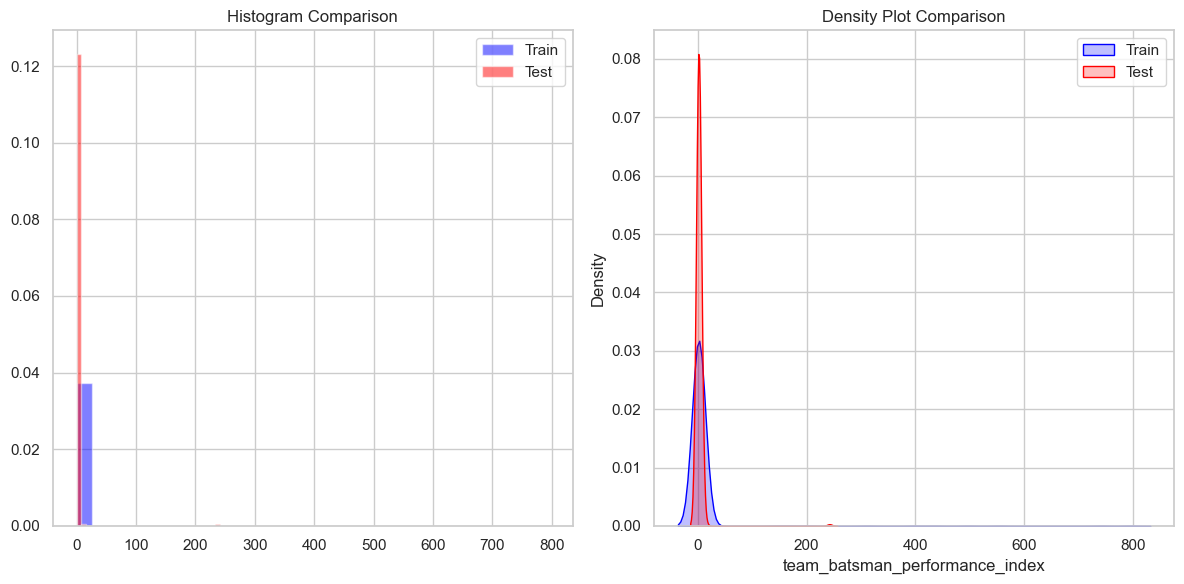

Kolmogorov-Smirnov test result: KS statistic = 0.0409, p-value = 0.8554

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      5.643986    2.142693
std      48.671236   14.668528
min       0.000000    0.000000
25%       0.725474    0.748330
50%       0.993099    1.037092
75%       1.400159    1.403964
max     795.199750  241.844000


In [61]:
check_distribution_match(train_data['team_batsman_performance_index'], test_data['team_batsman_performance_index'])

In [62]:
remove_skew(train_data, 'team_batsman_performance_index', 'quantile')
remove_skew(test_data, 'team_batsman_performance_index', 'quantile', train=False)

Skewness of team_batsman_performance_index was 12.449616793480345. square root transformation applied. New skewness is 10.16446836558101
Skewness of team_batsman_performance_index was 16.283788203031076. square root transformation applied. New skewness is 12.624074877569837


slope: 0.56 / 0.38 =  1.46


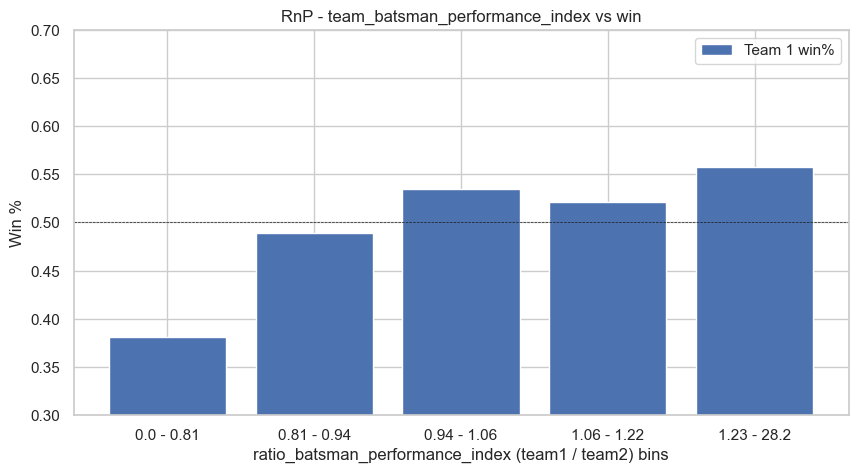

Correlation between team_batsman_performance_index and winner_01 is: -0.05956479022108745


In [63]:
createRnP(train_data, 'team_batsman_performance_index')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


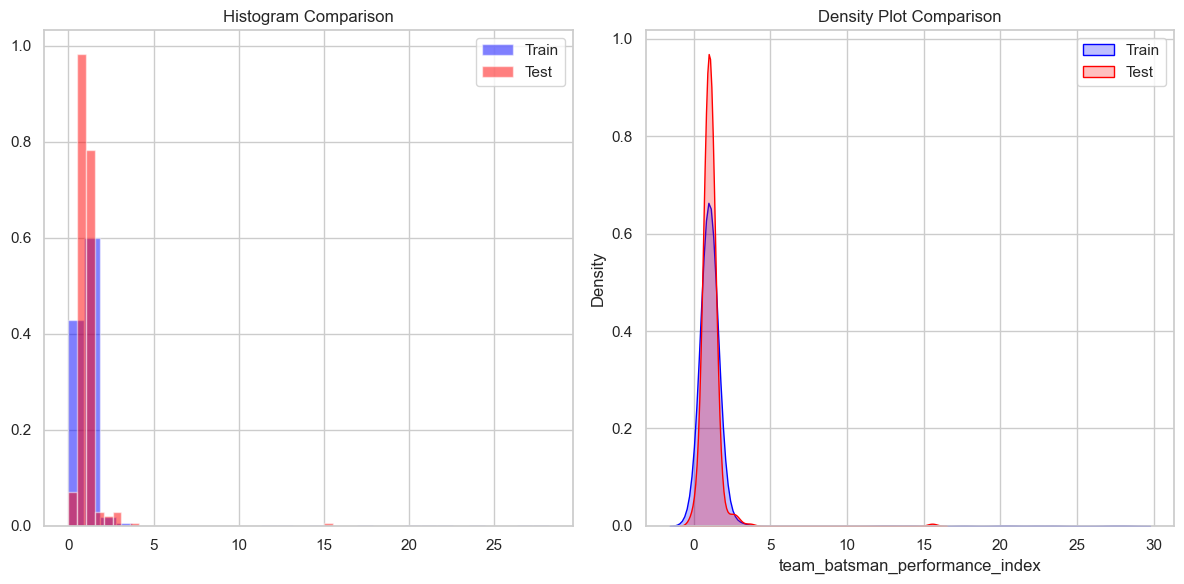

Kolmogorov-Smirnov test result: KS statistic = 0.0409, p-value = 0.8554

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.221910e+00  1.101654e+00
std    2.038457e+00  9.656566e-01
min    1.490116e-08  1.490116e-08
25%    8.517479e-01  8.650594e-01
50%    9.965435e-01  1.018377e+00
75%    1.183283e+00  1.184879e+00
max    2.819929e+01  1.555133e+01


In [64]:
check_distribution_match(train_data['team_batsman_performance_index'], test_data['team_batsman_performance_index'])

### team_overall_win_rate

In [65]:
def overall_historical_win_rate(match_lvl_data, team_id, date):
    historical_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                        (match_lvl_data['match_dt'] < date)]
    wins = historical_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    total_matches = len(historical_matches)
    return wins / total_matches if total_matches > 0 else 0

In [66]:
train_data['team1_overall_win_rate'] = train_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_overall_win_rate'] = train_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_overall_win_rate', 'team2_overall_win_rate', 'team_overall_win_rate')

train_data = train_data.drop(columns=['team1_overall_win_rate', 'team2_overall_win_rate'])

test_data['team1_overall_win_rate'] = test_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_overall_win_rate'] = test_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_overall_win_rate', 'team2_overall_win_rate', 'team_overall_win_rate')

test_data = test_data.drop(columns=['team1_overall_win_rate', 'team2_overall_win_rate'])

slope: 0.57 / 0.43 =  1.33


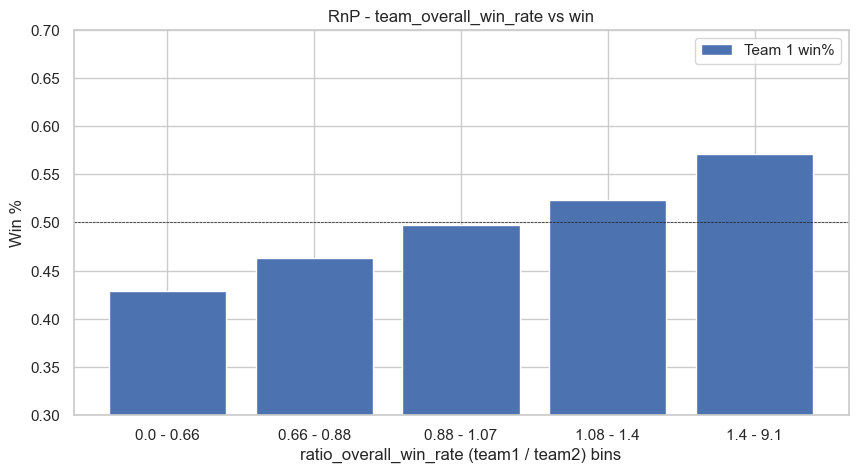

Correlation between team_overall_win_rate and winner_01 is: -0.0997730874267899


In [67]:
createRnP(train_data, 'team_overall_win_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


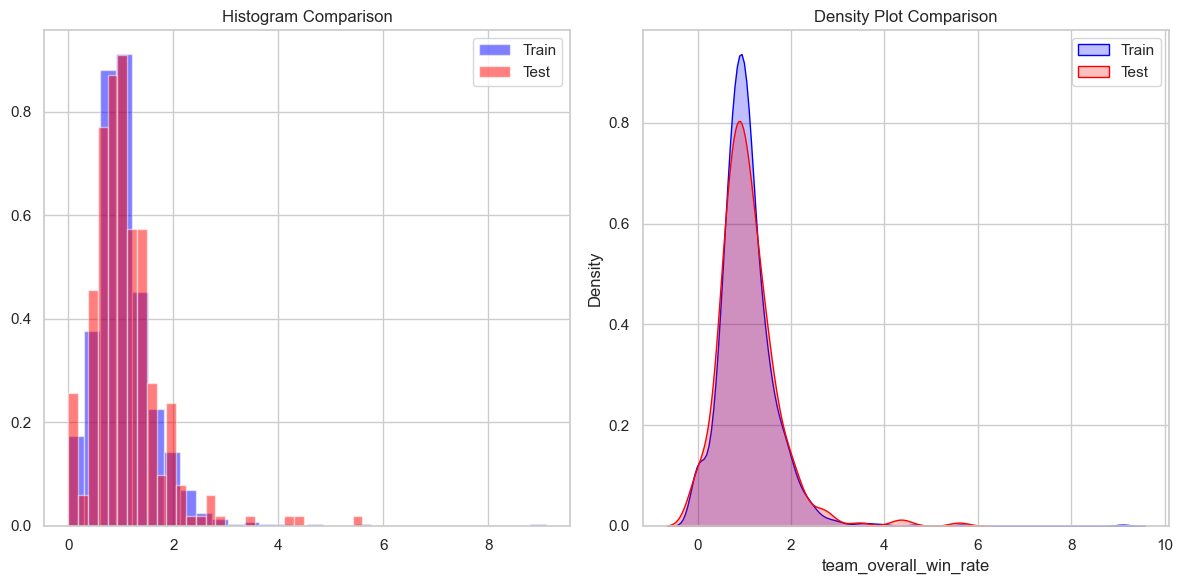

Kolmogorov-Smirnov test result: KS statistic = 0.0415, p-value = 0.8432

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.055088    1.078534
std       0.622973    0.670776
min       0.000000    0.000000
25%       0.717949    0.688018
50%       0.977346    0.969231
75%       1.285714    1.355731
max       9.100000    5.600000


In [68]:
check_distribution_match(train_data['team_overall_win_rate'], test_data['team_overall_win_rate'])

In [69]:
remove_skew(train_data, 'team_overall_win_rate', 'quantile')
remove_skew(test_data, 'team_overall_win_rate', 'quantile', train=False)

Skewness of team_overall_win_rate was 3.490573489976669. square root transformation applied. New skewness is -0.4329061682116008
Skewness of team_overall_win_rate was 2.3412361291253334. square root transformation applied. New skewness is -0.3758965929363033


slope: 0.57 / 0.43 =  1.33


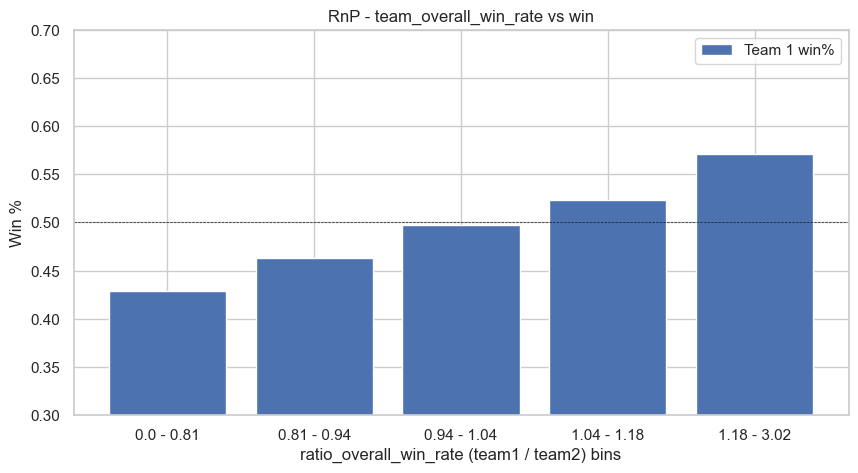

Correlation between team_overall_win_rate and winner_01 is: -0.09717780124217909


In [70]:
createRnP(train_data, 'team_overall_win_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


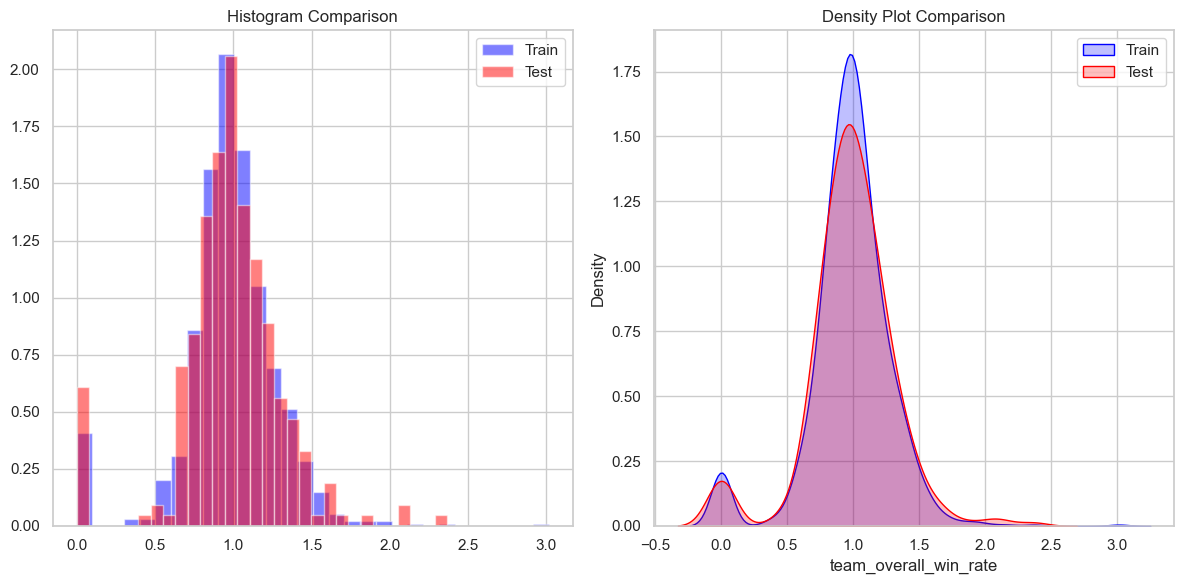

Kolmogorov-Smirnov test result: KS statistic = 0.0415, p-value = 0.8432

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   9.782191e-01  9.824485e-01
std    3.134944e-01  3.372667e-01
min    1.490116e-08  1.490116e-08
25%    8.473185e-01  8.294484e-01
50%    9.886080e-01  9.844952e-01
75%    1.133893e+00  1.164354e+00
max    3.016621e+00  2.366432e+00


In [71]:
check_distribution_match(train_data['team_overall_win_rate'], test_data['team_overall_win_rate'])

### team_recent_form

In [72]:
def recent_form(match_lvl_data, team_id, date):
    recent_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['match_dt'] < date)].tail(5)
    wins = recent_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    return wins / 5 if recent_matches.shape[0] > 0 else 0

In [73]:
train_data['team1_recent_form'] = train_data.apply(
    lambda x: recent_form(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_recent_form'] = train_data.apply(
    lambda x: recent_form(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_recent_form', 'team2_recent_form', 'team_recent_form')

train_data = train_data.drop(columns=['team1_recent_form', 'team2_recent_form'])

test_data['team1_recent_form'] = test_data.apply(
    lambda x: recent_form(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_recent_form'] = test_data.apply(
    lambda x: recent_form(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_recent_form', 'team2_recent_form', 'team_recent_form')

test_data = test_data.drop(columns=['team1_recent_form', 'team2_recent_form'])

slope: 0.53 / 0.44 =  1.21


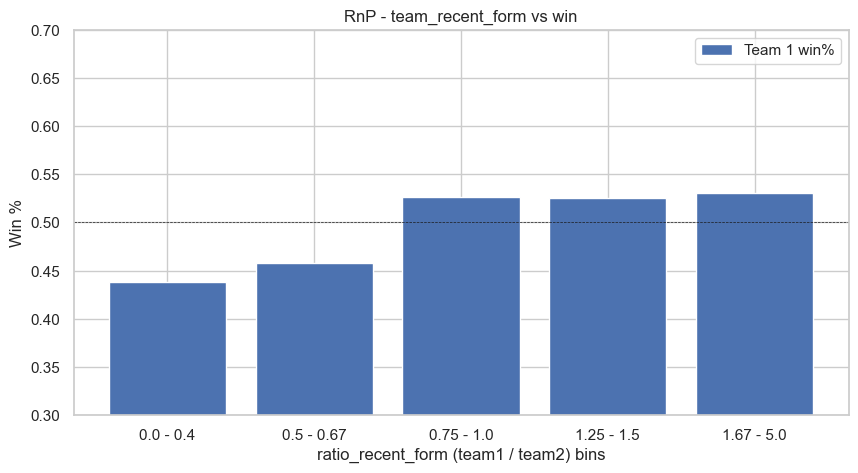

Correlation between team_recent_form and winner_01 is: -0.06215836793440212


In [74]:
createRnP(train_data, 'team_recent_form')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


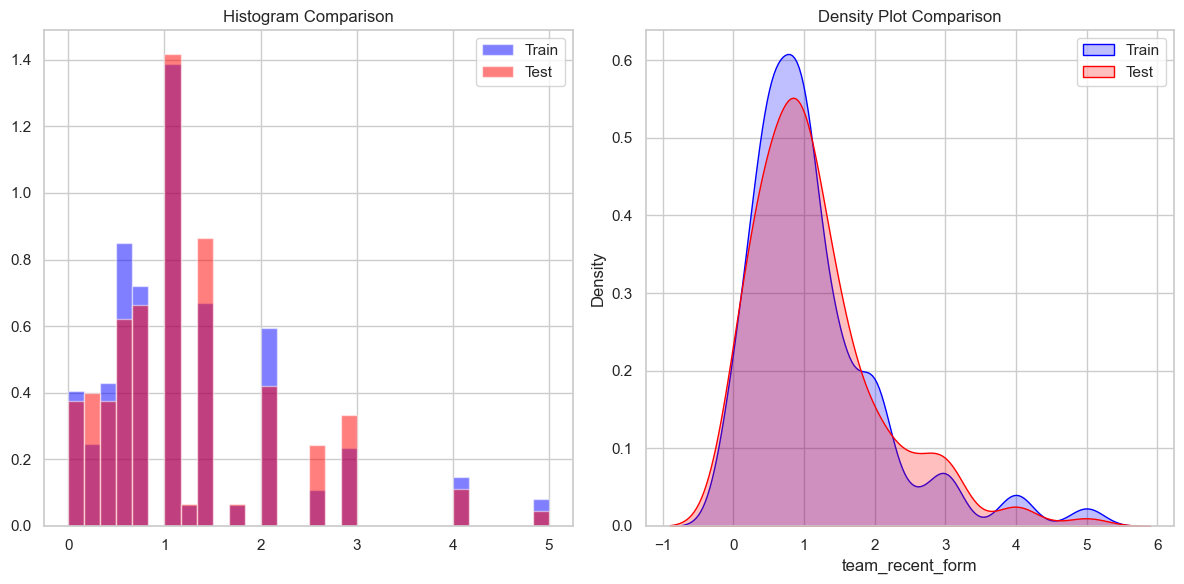

Kolmogorov-Smirnov test result: KS statistic = 0.0361, p-value = 0.9354

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.141842    1.164391
std       0.952862    0.917335
min       0.000000    0.000000
25%       0.500000    0.500000
50%       1.000000    1.000000
75%       1.500000    1.500000
max       5.000000    5.000000


In [75]:
check_distribution_match(train_data['team_recent_form'], test_data['team_recent_form'])

In [76]:
remove_skew(train_data, 'team_recent_form', 'quantile')
remove_skew(test_data, 'team_recent_form', 'quantile', train=False)

Skewness of team_recent_form was 1.744018644780832. square root transformation applied. New skewness is 0.14088682634200708
Skewness of team_recent_form was 1.4329914000437813. square root transformation applied. New skewness is -0.026437232683881425


slope: 0.53 / 0.44 =  1.21


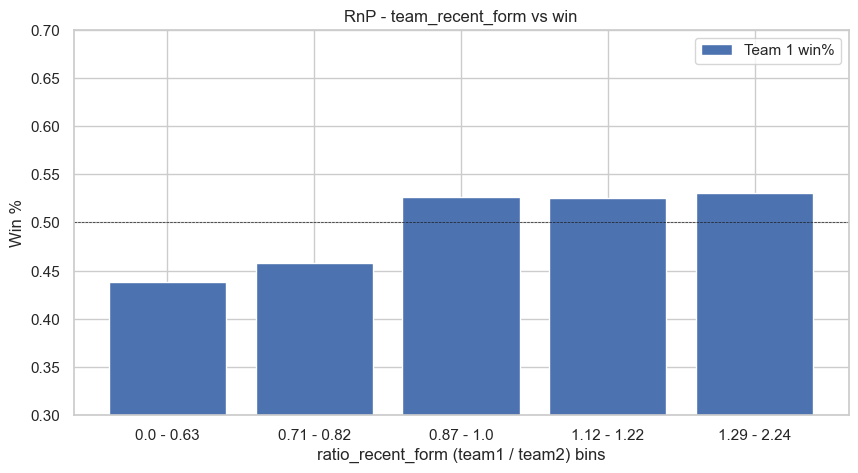

Correlation between team_recent_form and winner_01 is: -0.06842666158001527


In [77]:
createRnP(train_data, 'team_recent_form')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


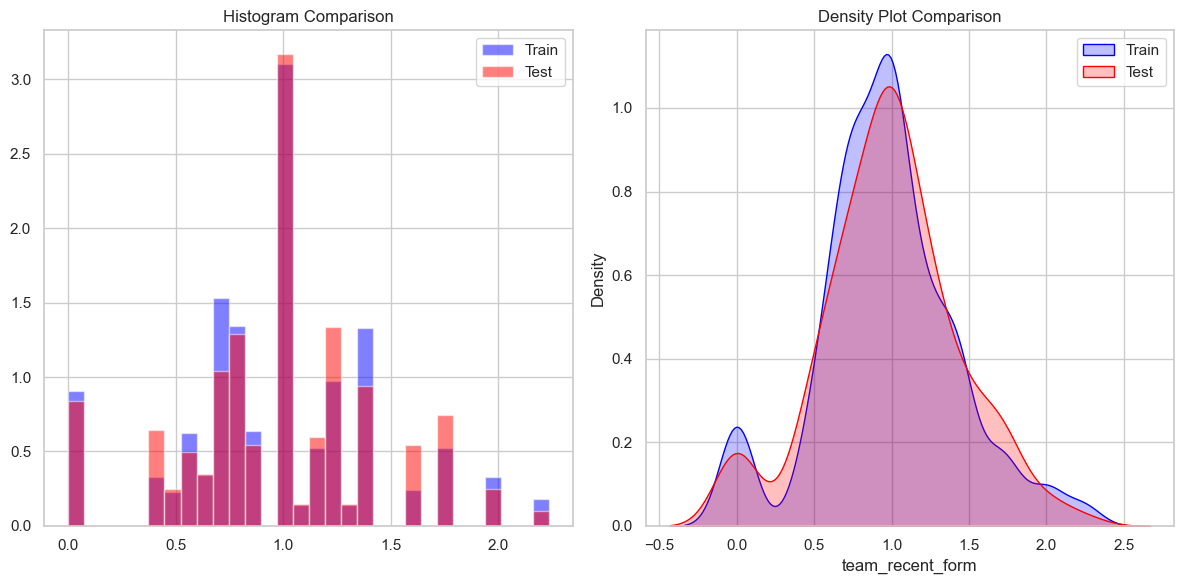

Kolmogorov-Smirnov test result: KS statistic = 0.0361, p-value = 0.9354

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   9.708888e-01  9.845251e-01
std    4.465735e-01  4.425202e-01
min    1.490116e-08  1.490116e-08
25%    7.071068e-01  7.071068e-01
50%    1.000000e+00  1.000000e+00
75%    1.224745e+00  1.224745e+00
max    2.236068e+00  2.236068e+00


In [78]:
check_distribution_match(train_data['team_recent_form'], test_data['team_recent_form'])

### team_momentum

In [79]:
def calculate_exponential_momentum(match_lvl_data, team_id, date, alpha=0.1):
    matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                             (match_lvl_data['match_dt'] < date)].sort_values('match_dt', ascending=False)
    wins = matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).to_numpy()
    weights = np.exp(-alpha * np.arange(len(wins)))
    if np.sum(weights) > 0:
        momentum = np.dot(wins, weights) / np.sum(weights)
    else:
        momentum = 0  # Handle case with no matches
    return momentum

In [80]:
train_data['team1_momentum'] = train_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_momentum'] = train_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_momentum', 'team2_momentum', 'team_momentum')

train_data = train_data.drop(columns=['team1_momentum', 'team2_momentum'])

test_data['team1_momentum'] = test_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_momentum'] = test_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_momentum', 'team2_momentum', 'team_momentum')

test_data = test_data.drop(columns=['team1_momentum', 'team2_momentum'])

slope: 0.56 / 0.42 =  1.33


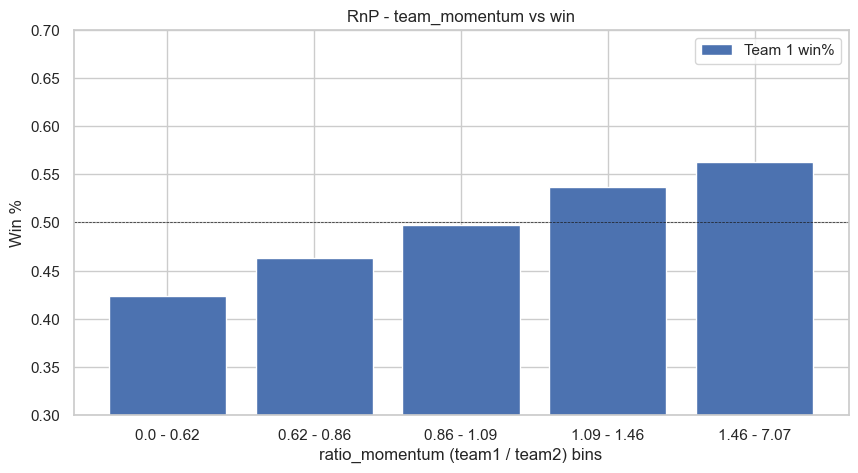

Correlation between team_momentum and winner_01 is: -0.09341226475457841


In [81]:
createRnP(train_data, 'team_momentum')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


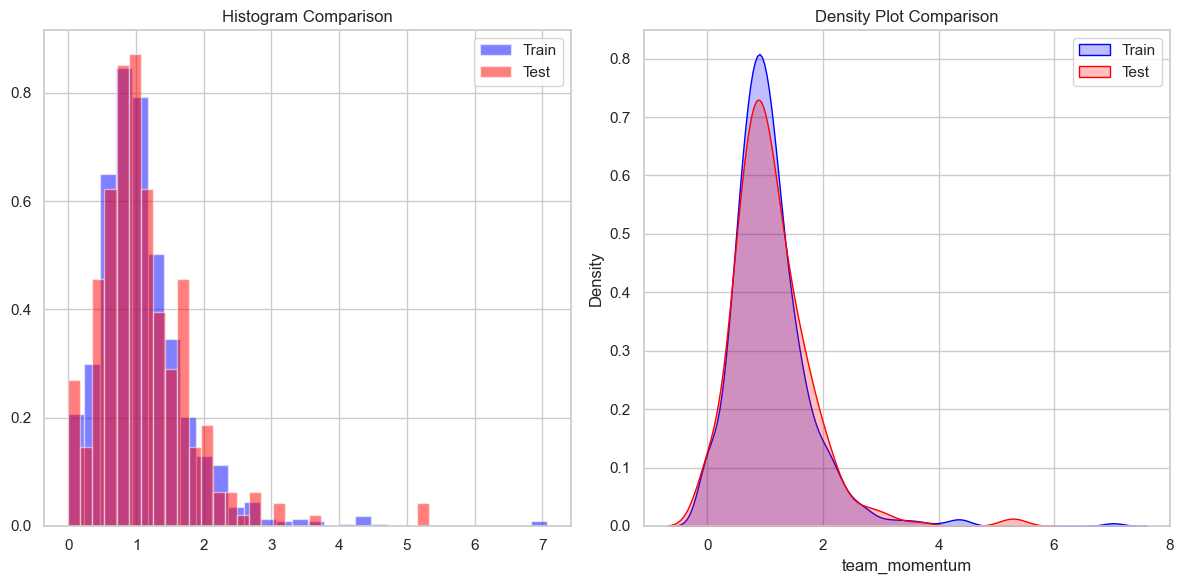

Kolmogorov-Smirnov test result: KS statistic = 0.0437, p-value = 0.7955

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.084422    1.105497
std       0.689988    0.701511
min       0.000000    0.000000
25%       0.682378    0.684016
50%       0.977013    0.987529
75%       1.347996    1.414583
max       7.065686    5.332317


In [82]:
check_distribution_match(train_data['team_momentum'], test_data['team_momentum'])

In [83]:
remove_skew(train_data, 'team_momentum', 'quantile')
remove_skew(test_data, 'team_momentum', 'quantile', train=False)

Skewness of team_momentum was 2.485375670626139. square root transformation applied. New skewness is -0.2198762920992858
Skewness of team_momentum was 2.0681247582607982. square root transformation applied. New skewness is -0.35051116645712943


slope: 0.56 / 0.42 =  1.33


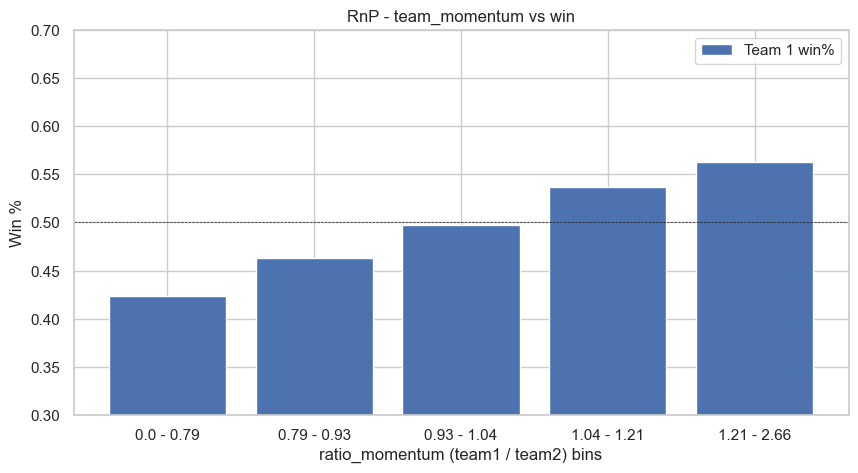

Correlation between team_momentum and winner_01 is: -0.0948941181642712


In [84]:
createRnP(train_data, 'team_momentum')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


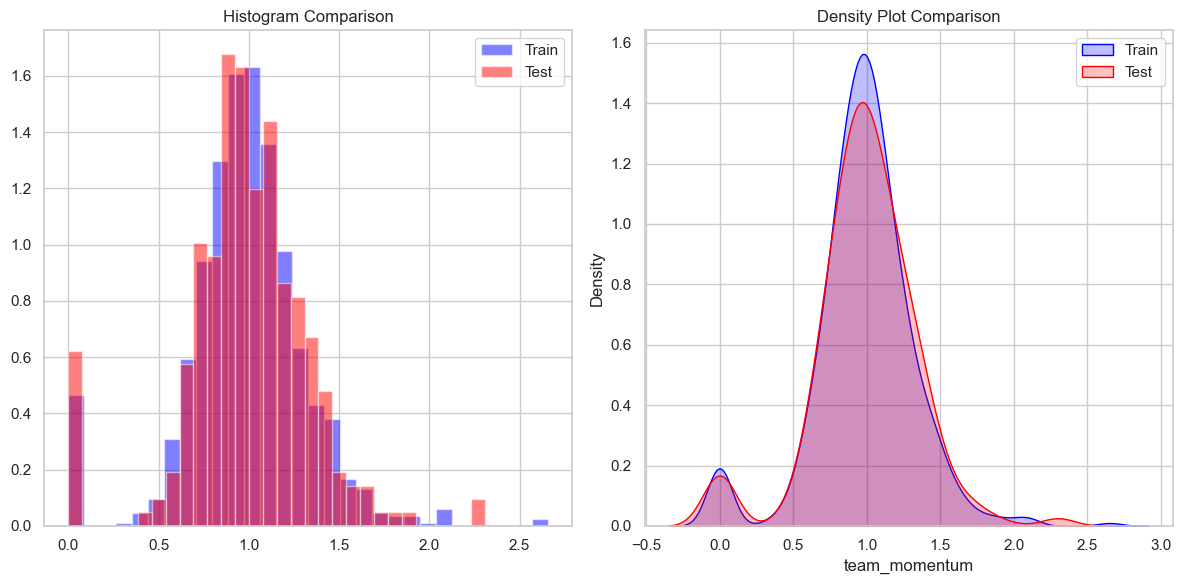

Kolmogorov-Smirnov test result: KS statistic = 0.0437, p-value = 0.7955

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   9.849192e-01  9.914319e-01
std    3.383439e-01  3.507335e-01
min    1.490116e-08  1.490116e-08
25%    8.260615e-01  8.270522e-01
50%    9.884393e-01  9.937451e-01
75%    1.161032e+00  1.189362e+00
max    2.658136e+00  2.309181e+00


In [85]:
check_distribution_match(train_data['team_momentum'], test_data['team_momentum'])

## team_batsman_performance_recent

In [86]:
def team_batsman_performance_recent(bat_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] * 4.5 +
                                  recent_matches['strike_rate'] * 2.5 +
                                  (recent_matches['Fours'] + recent_matches['Sixes'] ) * 1.5) 
                                  
            total_performance_index += player_performance.sum()

    return total_performance_index

In [87]:
train_data['team1_batsman_performance_recent'] = train_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_batsman_performance_recent'] = train_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_batsman_performance_recent', 'team2_batsman_performance_recent', 'team_batsman_performance_recent')

train_data = train_data.drop(columns=['team1_batsman_performance_recent', 'team2_batsman_performance_recent'])

test_data['team1_batsman_performance_recent'] = test_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_batsman_performance_recent'] = test_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_batsman_performance_recent', 'team2_batsman_performance_recent', 'team_batsman_performance_recent')

test_data = test_data.drop(columns=['team1_batsman_performance_recent', 'team2_batsman_performance_recent'])

slope: 0.58 / 0.35 =  1.65


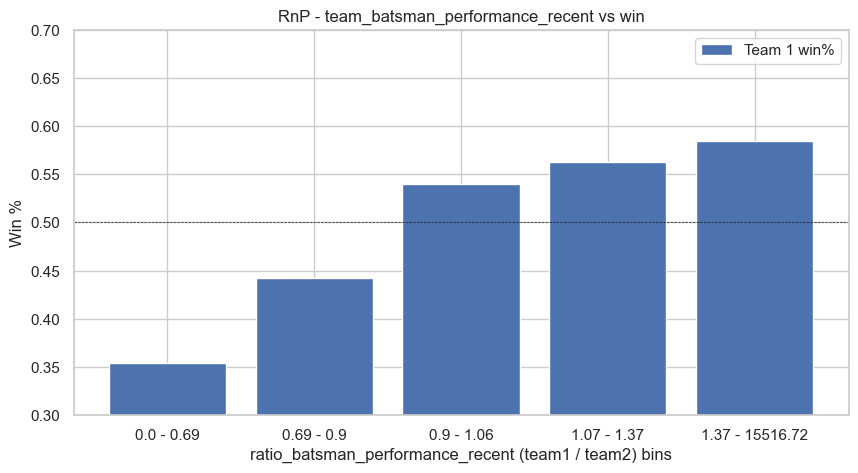

Correlation between team_batsman_performance_recent and winner_01 is: -0.04340818347684576


In [88]:
createRnP(train_data, 'team_batsman_performance_recent')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


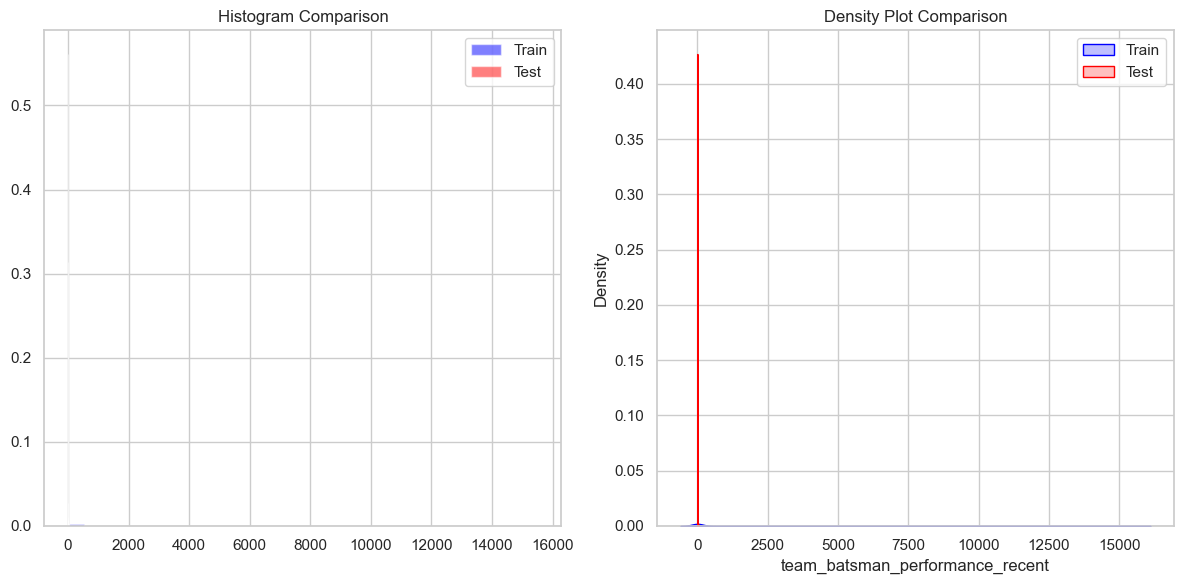

Kolmogorov-Smirnov test result: KS statistic = 0.0403, p-value = 0.8661

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count    948.000000  271.000000
mean      60.915898    1.406714
std      785.743925    2.404311
min        0.000000    0.000000
25%        0.758679    0.748565
50%        0.977252    0.954295
75%        1.264147    1.312189
max    15516.725000   31.760455


In [89]:
check_distribution_match(train_data['team_batsman_performance_recent'], test_data['team_batsman_performance_recent'])

In [90]:
remove_skew(train_data, 'team_batsman_performance_recent', 'quantile')
remove_skew(test_data, 'team_batsman_performance_recent', 'quantile', train=False)

Skewness of team_batsman_performance_recent was 16.066367868963873. square root transformation applied. New skewness is 12.591426836168976
Skewness of team_batsman_performance_recent was 8.752602121688737. square root transformation applied. New skewness is 4.175535491645167


slope: 0.58 / 0.35 =  1.65


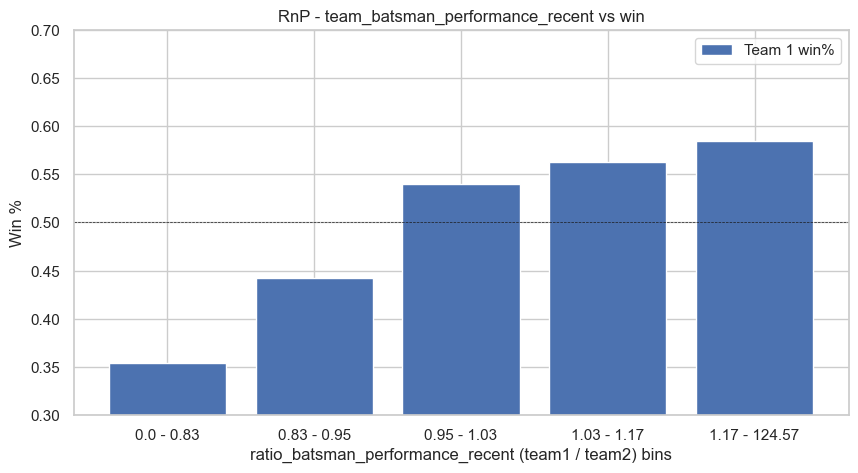

Correlation between team_batsman_performance_recent and winner_01 is: -0.048497601894914096


In [91]:
createRnP(train_data, 'team_batsman_performance_recent')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


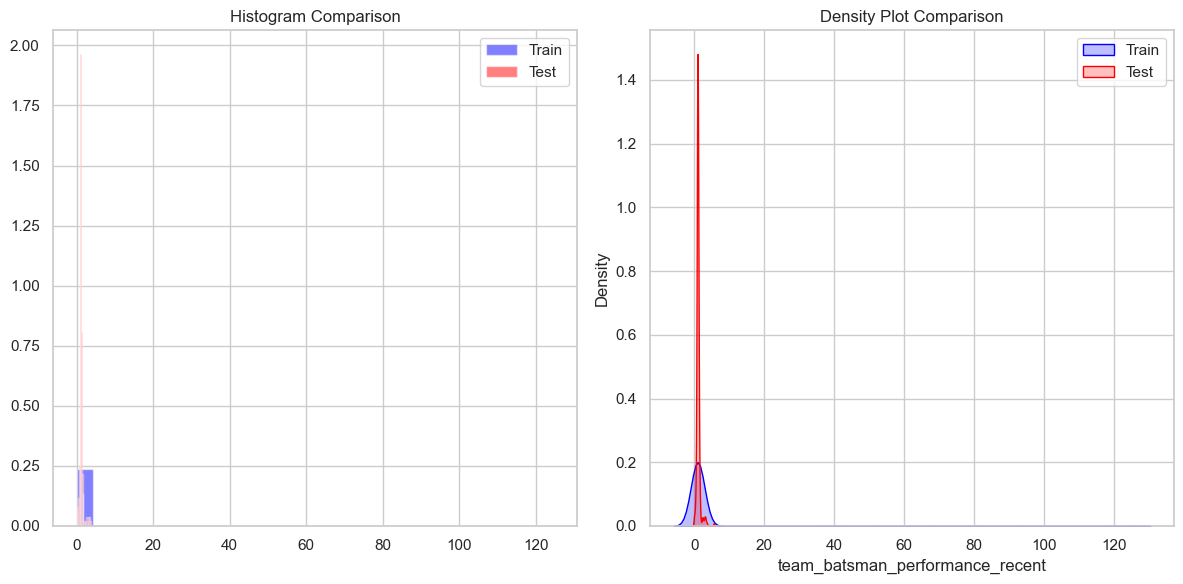

Kolmogorov-Smirnov test result: KS statistic = 0.0403, p-value = 0.8661

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.701012e+00  1.067054e+00
std    7.621268e+00  5.187514e-01
min    1.490116e-08  1.490116e-08
25%    8.710220e-01  8.651965e-01
50%    9.885604e-01  9.768800e-01
75%    1.124343e+00  1.145507e+00
max    1.245661e+02  5.635641e+00


In [92]:
check_distribution_match(train_data['team_batsman_performance_recent'], test_data['team_batsman_performance_recent'])

### team_batsman_runs_recent

In [93]:
def team_batsman_runs_recent(bat_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] ) 
                                  
            total_performance_index += player_performance.sum()

    return total_performance_index

In [94]:
train_data['team1_batsman_runs_recent'] = train_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_batsman_runs_recent'] = train_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_batsman_runs_recent', 'team2_batsman_runs_recent', 'team_batsman_runs_recent')

train_data = train_data.drop(columns=['team1_batsman_runs_recent', 'team2_batsman_runs_recent'])

test_data['team1_batsman_runs_recent'] = test_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_batsman_runs_recent'] = test_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_batsman_runs_recent', 'team2_batsman_runs_recent', 'team_batsman_runs_recent')

test_data = test_data.drop(columns=['team1_batsman_runs_recent', 'team2_batsman_runs_recent'])

slope: 0.63 / 0.34 =  1.87


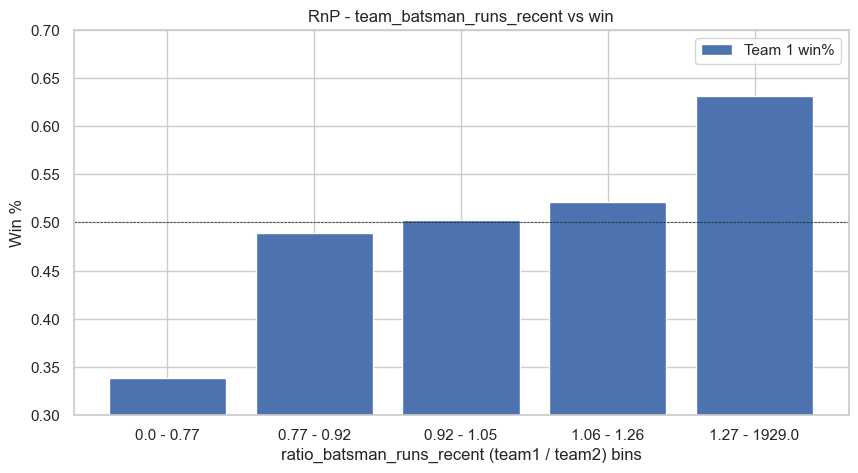

Correlation between team_batsman_runs_recent and winner_01 is: -0.05063885076794448


In [95]:
createRnP(train_data, 'team_batsman_runs_recent')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


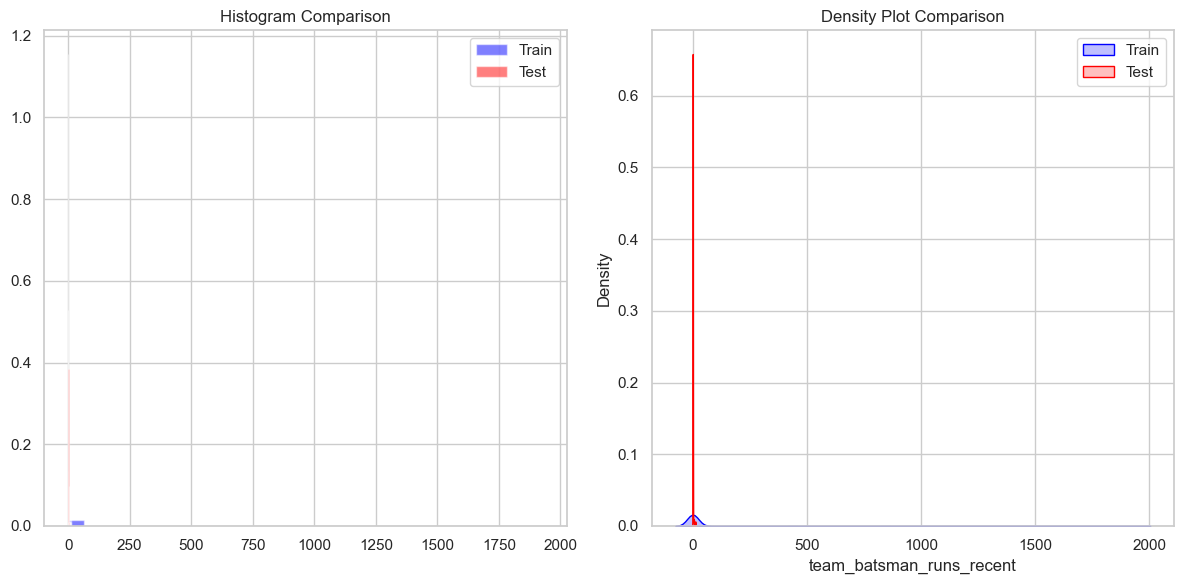

Kolmogorov-Smirnov test result: KS statistic = 0.0556, p-value = 0.5113

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      8.322739    1.270554
std      97.981448    1.435869
min       0.000000    0.000000
25%       0.815550    0.815097
50%       0.978937    0.993631
75%       1.190198    1.239880
max    1929.000000   12.362069


In [96]:
check_distribution_match(train_data['team_batsman_runs_recent'], test_data['team_batsman_runs_recent'])

In [97]:
remove_skew(train_data, 'team_batsman_runs_recent', 'quantile')
remove_skew(test_data, 'team_batsman_runs_recent', 'quantile', train=False)

Skewness of team_batsman_runs_recent was 16.814582555720005. square root transformation applied. New skewness is 12.864366075490972
Skewness of team_batsman_runs_recent was 5.506359646853759. square root transformation applied. New skewness is 3.0953365702506503


slope: 0.63 / 0.34 =  1.87


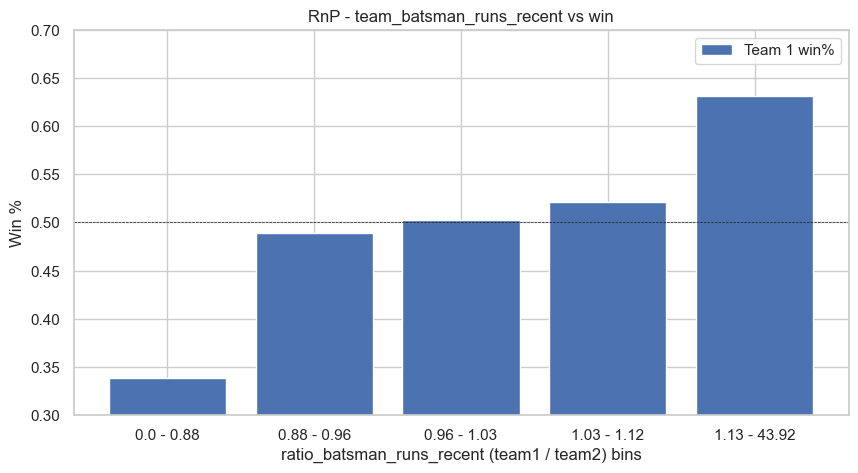

Correlation between team_batsman_runs_recent and winner_01 is: -0.06758627658638736


In [98]:
createRnP(train_data, 'team_batsman_runs_recent')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


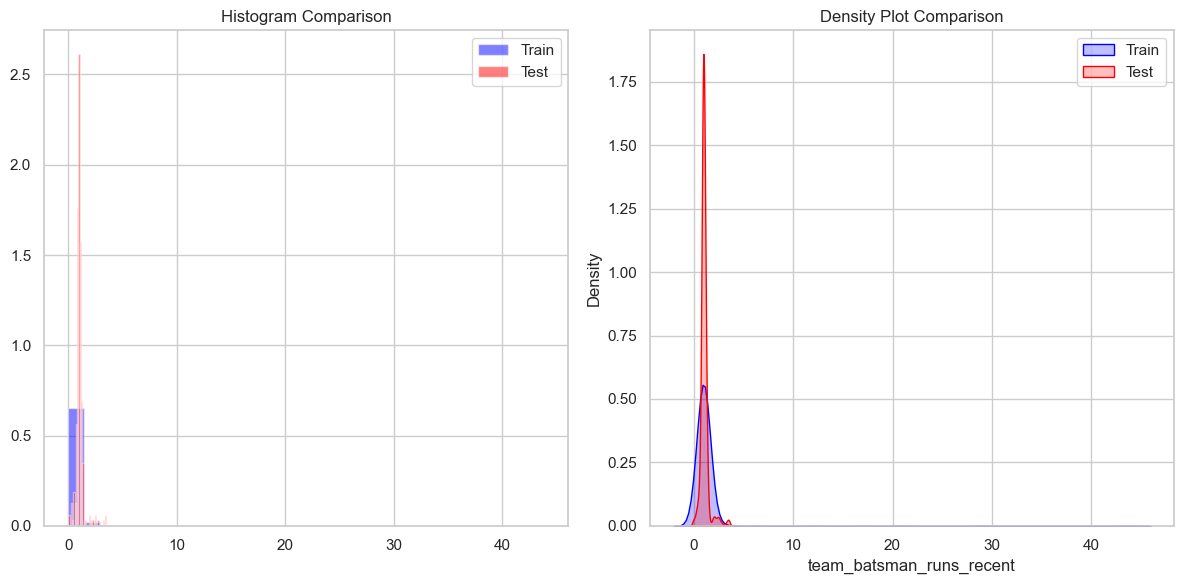

Kolmogorov-Smirnov test result: KS statistic = 0.0556, p-value = 0.5113

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.233027e+00  1.051623e+00
std    2.609515e+00  4.065129e-01
min    1.490116e-08  1.490116e-08
25%    9.030780e-01  9.028273e-01
50%    9.894125e-01  9.968102e-01
75%    1.090962e+00  1.113498e+00
max    4.392038e+01  3.515973e+00


In [99]:
check_distribution_match(train_data['team_batsman_runs_recent'], test_data['team_batsman_runs_recent'])

### team_pom_frequency

In [100]:
def player_of_match_frequency(matches, team_roster_ids, date):
    team_ids = str(team_roster_ids).split(':')
    pom_awards = 0
    total_matches = 0

    for player_id in team_ids:
        past_matches = matches[(matches['match_dt'] < date) & (matches['player_of_the_match_id'] == float(player_id))]
        pom_awards += past_matches.shape[0]
        total_matches += matches[(matches['match_dt'] < date) & ((matches['team1_roster_ids'].str.contains(str(player_id))) | (matches['team2_roster_ids'].str.contains(str(player_id))))].shape[0]

    return pom_awards / total_matches if total_matches > 0 else 0

In [101]:
train_data['team1_pom_frequency'] = train_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_pom_frequency'] = train_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_pom_frequency', 'team2_pom_frequency', 'team_pom_frequency')

train_data = train_data.drop(columns=['team1_pom_frequency', 'team2_pom_frequency'])

test_data['team1_pom_frequency'] = test_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_pom_frequency'] = test_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_pom_frequency', 'team2_pom_frequency', 'team_pom_frequency')

test_data = test_data.drop(columns=['team1_pom_frequency', 'team2_pom_frequency'])

slope: 0.53 / 0.39 =  1.36


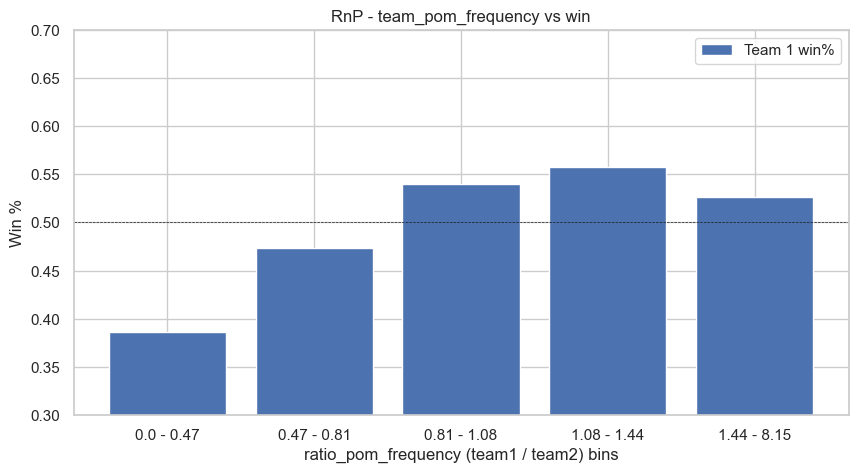

Correlation between team_pom_frequency and winner_01 is: -0.10387943593858757


In [102]:
createRnP(train_data, 'team_pom_frequency')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


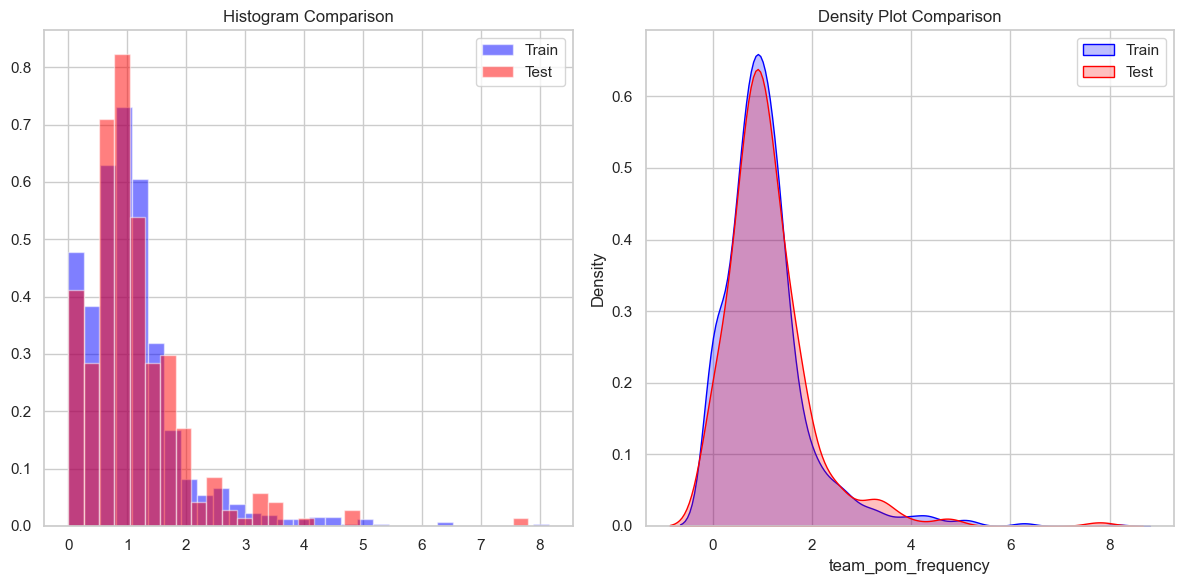

Kolmogorov-Smirnov test result: KS statistic = 0.0589, p-value = 0.4356

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.062113    1.116506
std       0.872368    0.888507
min       0.000000    0.000000
25%       0.575646    0.617815
50%       0.927612    0.960854
75%       1.323588    1.420928
max       8.151111    7.802120


In [103]:
check_distribution_match(train_data['team_pom_frequency'], test_data['team_pom_frequency'])

In [104]:
remove_skew(train_data, 'team_pom_frequency', 'quantile')
remove_skew(test_data, 'team_pom_frequency', 'quantile', train=False)

Skewness of team_pom_frequency was 2.3780794969674646. square root transformation applied. New skewness is -0.1027177617726224
Skewness of team_pom_frequency was 2.6387050242041012. square root transformation applied. New skewness is -0.05702305456622473


slope: 0.53 / 0.39 =  1.36


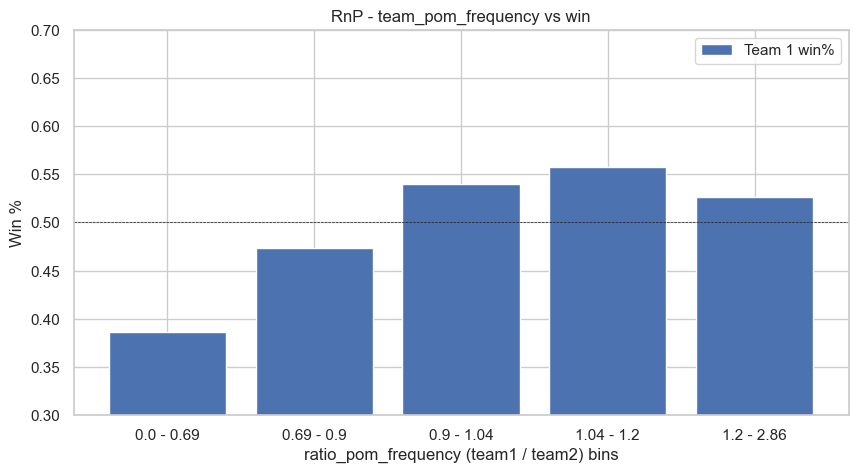

Correlation between team_pom_frequency and winner_01 is: -0.12585863199769498


In [105]:
createRnP(train_data, 'team_pom_frequency')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


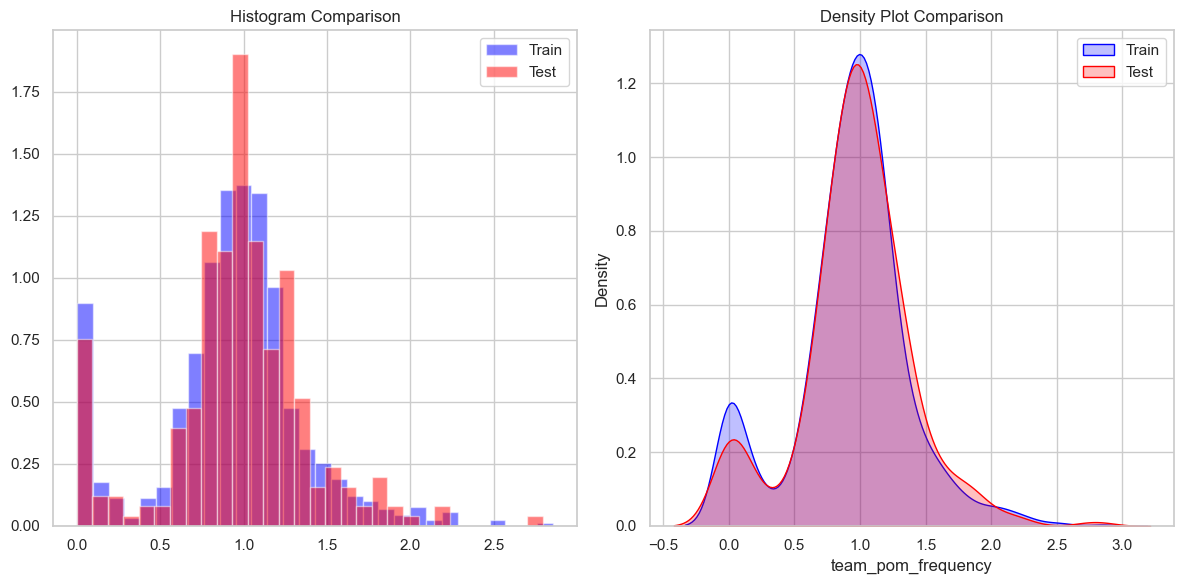

Kolmogorov-Smirnov test result: KS statistic = 0.0589, p-value = 0.4356

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   9.319822e-01  9.667533e-01
std    4.401443e-01  4.272796e-01
min    1.490116e-08  1.490116e-08
25%    7.587130e-01  7.860075e-01
50%    9.631262e-01  9.802317e-01
75%    1.150473e+00  1.192018e+00
max    2.855015e+00  2.793228e+00


In [106]:
check_distribution_match(train_data['team_pom_frequency'], test_data['team_pom_frequency'])

### team_count_100runs_ratio_last15

In [107]:
def team_count_100runs_last15(matches, team1_roster, team2_roster, date, n=25):
    def count_100s(team_roster):
        total_100s = 0
        for player_id in team_roster.split(':'):
            player_matches = giveLastNgamesPlayer(player_id, date, n, 'bat')
            total_100s += (player_matches['runs'] >= 75).sum()
        return total_100s

    team1_100s = count_100s(team1_roster)
    team2_100s = count_100s(team2_roster)

    return team1_100s / team2_100s if team2_100s > 0 else team1_100s

In [108]:
train_data['team_count_100runs_ratio_last15'] = train_data.apply(lambda x: team_count_100runs_last15(match_lvl_data, x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt']), axis=1)
test_data['team_count_100runs_ratio_last15'] = test_data.apply(lambda x: team_count_100runs_last15(match_lvl_data, x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt']), axis=1)

slope: 0.59 / 0.4 =  1.48


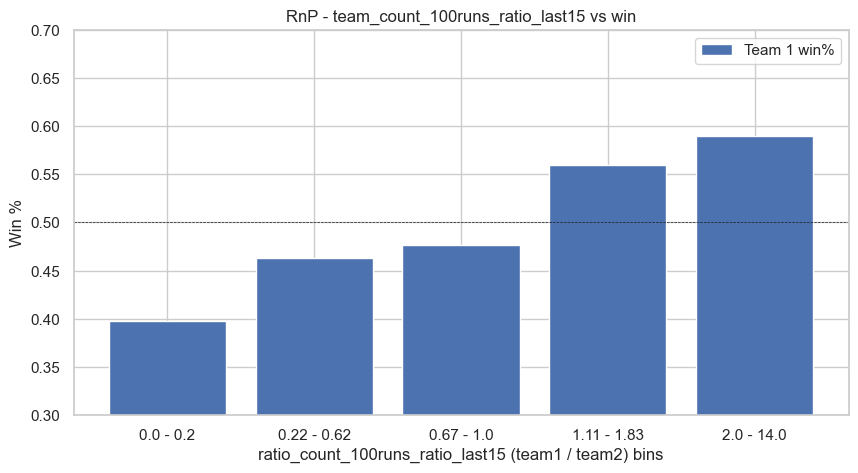

Correlation between team_count_100runs_ratio_last15 and winner_01 is: -0.14108232795000986


In [109]:
createRnP(train_data, 'team_count_100runs_ratio_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


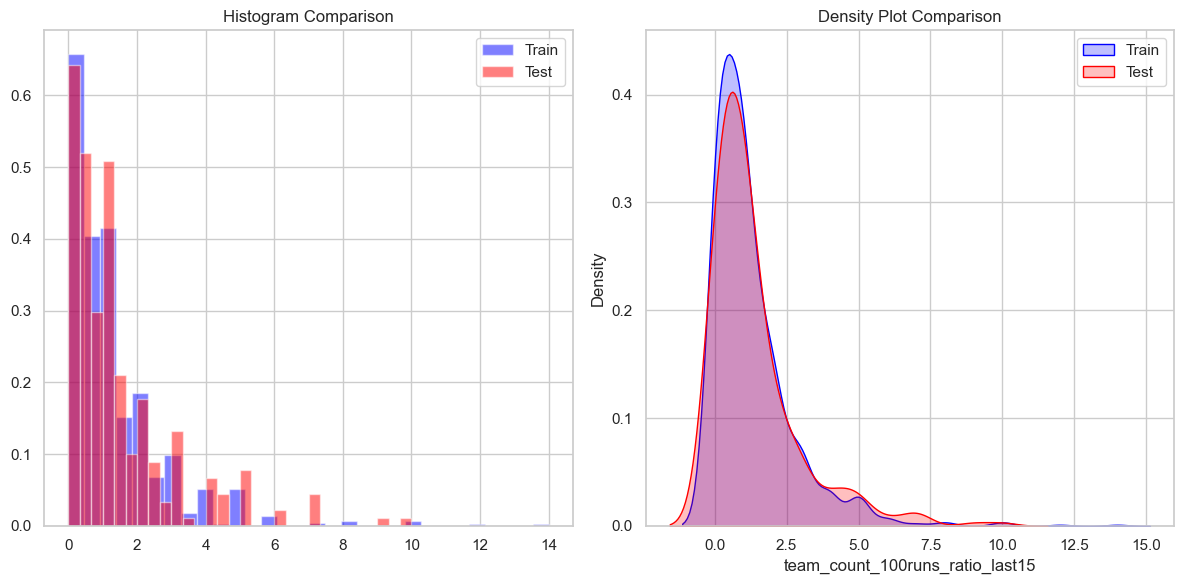

Kolmogorov-Smirnov test result: KS statistic = 0.0302, p-value = 0.9870

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.274676    1.365704
std       1.483916    1.597194
min       0.000000    0.000000
25%       0.333333    0.375000
50%       1.000000    1.000000
75%       1.750000    1.666667
max      14.000000   10.000000


In [110]:
check_distribution_match(train_data['team_count_100runs_ratio_last15'], test_data['team_count_100runs_ratio_last15'])

In [111]:
remove_skew(train_data, 'team_count_100runs_ratio_last15', 'quantile')
remove_skew(test_data, 'team_count_100runs_ratio_last15', 'quantile', train=False)

Skewness of team_count_100runs_ratio_last15 was 2.8535227456095624. square root transformation applied. New skewness is 0.45615396542395226
Skewness of team_count_100runs_ratio_last15 was 2.264393808264223. square root transformation applied. New skewness is 0.504468869686905


slope: 0.59 / 0.4 =  1.48


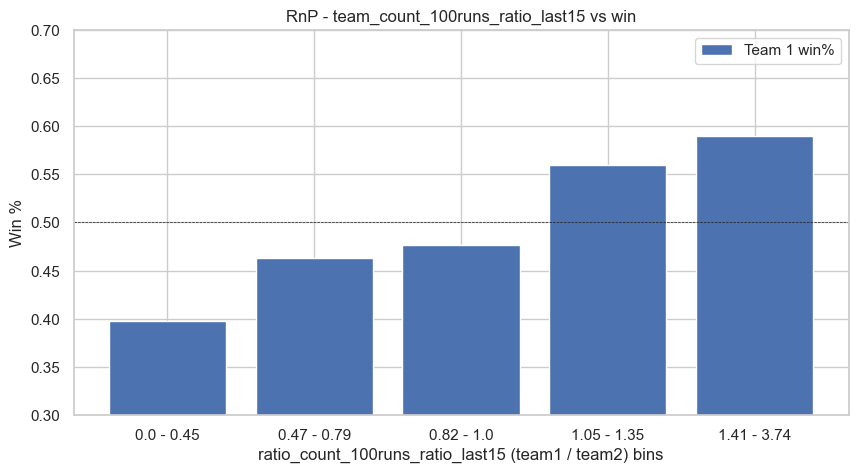

Correlation between team_count_100runs_ratio_last15 and winner_01 is: -0.14628285571498287


In [112]:
createRnP(train_data, 'team_count_100runs_ratio_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


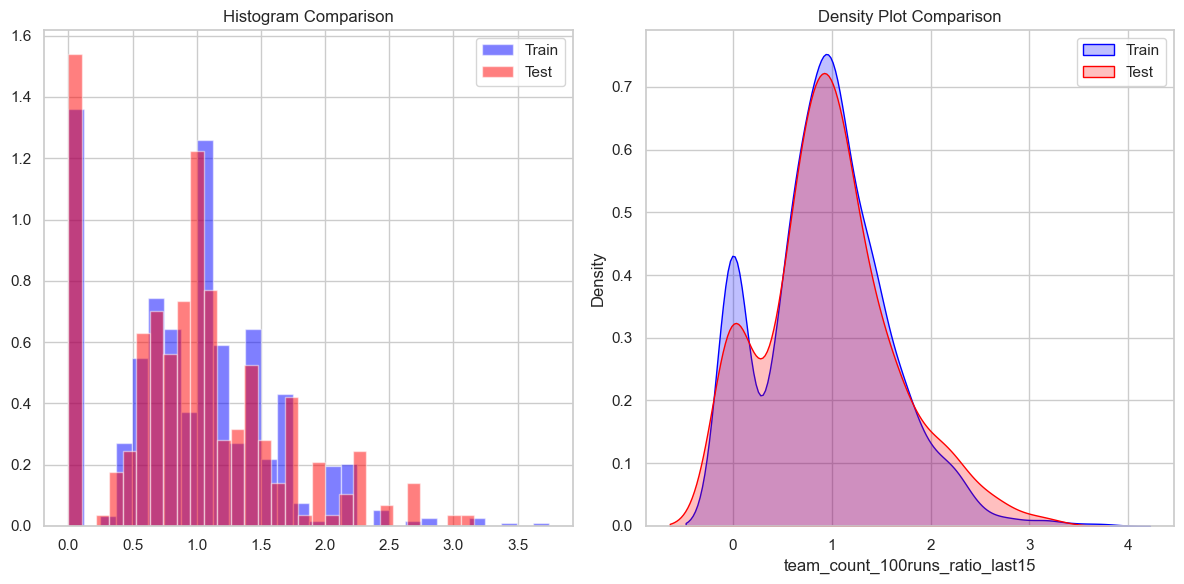

Kolmogorov-Smirnov test result: KS statistic = 0.0302, p-value = 0.9870

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   9.399936e-01  9.712677e-01
std    6.257001e-01  6.510819e-01
min    1.490116e-08  1.490116e-08
25%    5.773503e-01  6.123724e-01
50%    1.000000e+00  1.000000e+00
75%    1.322876e+00  1.290994e+00
max    3.741657e+00  3.162278e+00


In [113]:
check_distribution_match(train_data['team_count_100runs_ratio_last15'], test_data['team_count_100runs_ratio_last15'])

### team_avg_wickets_top5_bowlers

In [114]:
def avg_wickets_top5_bowlers(bowler_df, team_roster_ids, date, n=10):
    team_ids = team_roster_ids.split(':')
    bowlers_wickets = []

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bowl')
        if not recent_matches.empty:
            total_wickets = recent_matches['wicket_count'].sum()
            bowlers_wickets.append(total_wickets)

    bowlers_wickets.sort(reverse=True)
    top5_bowlers_wickets = bowlers_wickets[:5]

    return sum(top5_bowlers_wickets) / 5 if len(top5_bowlers_wickets) == 5 else sum(top5_bowlers_wickets) / len(top5_bowlers_wickets) if len(top5_bowlers_wickets) > 0 else 0

In [115]:
train_data['team1_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'team_avg_wickets_top5_bowlers')

train_data = train_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])

test_data['team1_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'team_avg_wickets_top5_bowlers')

test_data = test_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])

slope: 0.59 / 0.43 =  1.38


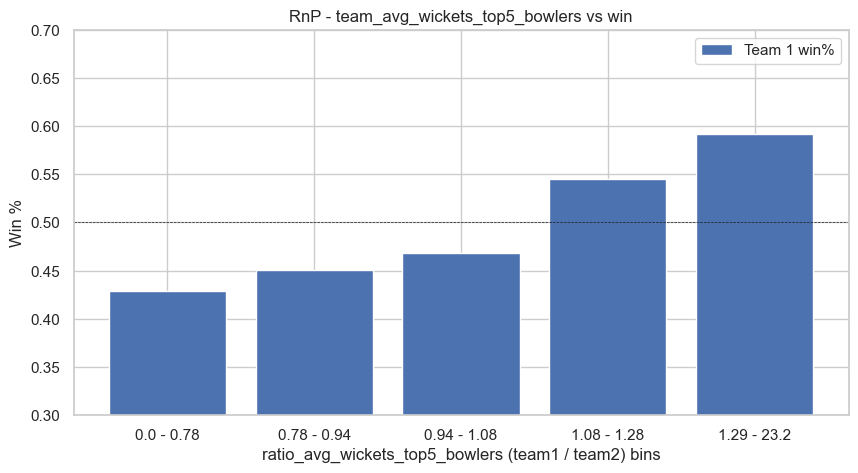

Correlation between team_avg_wickets_top5_bowlers and winner_01 is: -0.11325488452584982


In [116]:
createRnP(train_data, 'team_avg_wickets_top5_bowlers')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


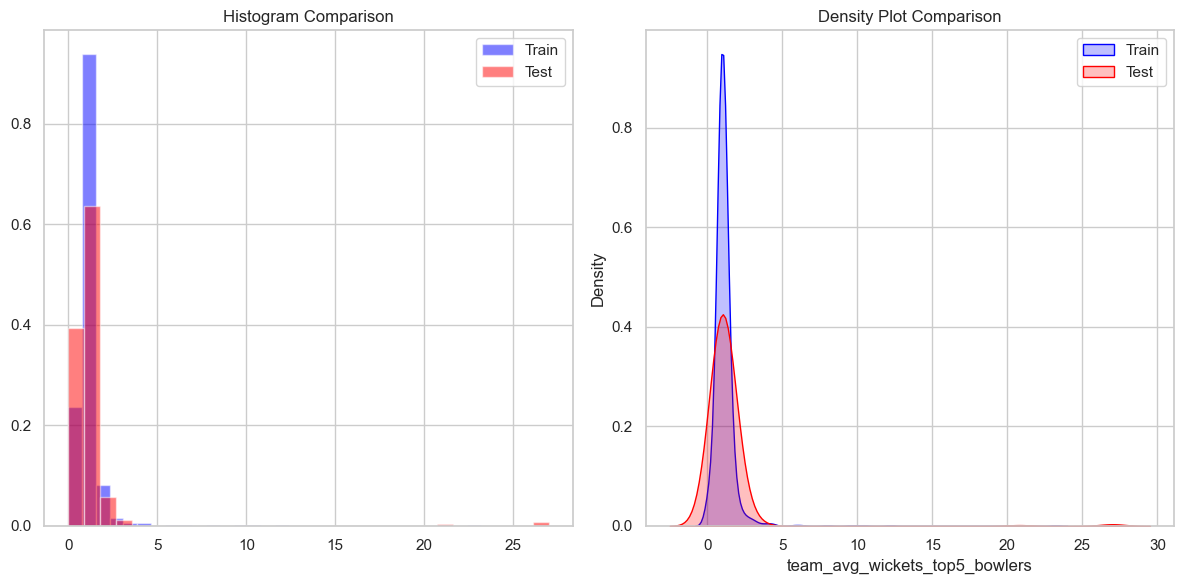

Kolmogorov-Smirnov test result: KS statistic = 0.0393, p-value = 0.8852

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.129825    1.336742
std       1.070175    2.560748
min       0.000000    0.000000
25%       0.824930    0.824781
50%       1.015625    1.032787
75%       1.216510    1.236695
max      23.200000   27.000000


In [117]:
check_distribution_match(train_data['team_avg_wickets_top5_bowlers'], test_data['team_avg_wickets_top5_bowlers'])

In [118]:
remove_skew(train_data, 'team_avg_wickets_top5_bowlers', 'quantile')
remove_skew(test_data, 'team_avg_wickets_top5_bowlers', 'quantile', train=False)

Skewness of team_avg_wickets_top5_bowlers was 12.305426033853346. square root transformation applied. New skewness is 3.2983846962396948
Skewness of team_avg_wickets_top5_bowlers was 9.147192306014654. square root transformation applied. New skewness is 6.274737021179226


slope: 0.59 / 0.43 =  1.38


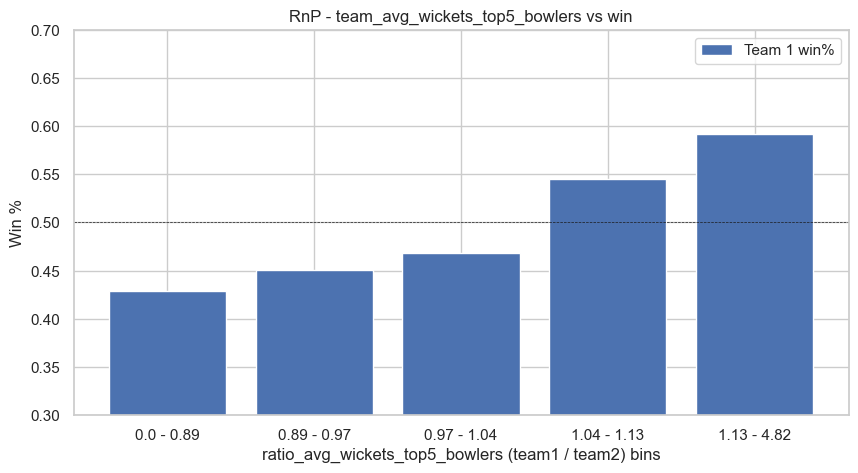

Correlation between team_avg_wickets_top5_bowlers and winner_01 is: -0.15199855977153467


In [119]:
createRnP(train_data, 'team_avg_wickets_top5_bowlers')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


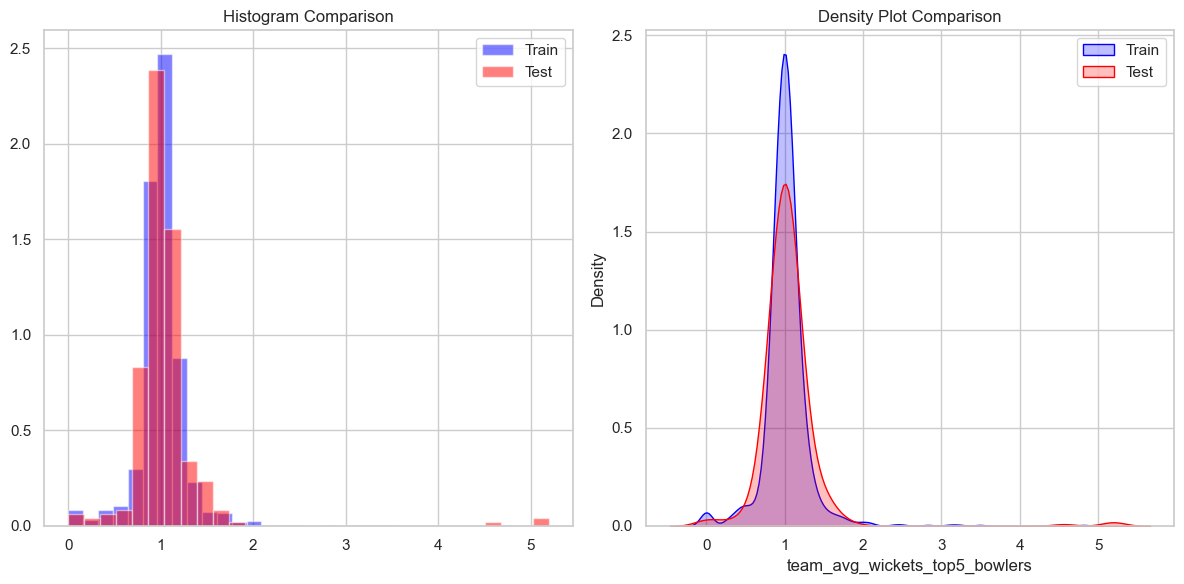

Kolmogorov-Smirnov test result: KS statistic = 0.0393, p-value = 0.8852

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.016577e+00  1.053923e+00
std    3.106404e-01  4.762610e-01
min    1.490116e-08  1.490116e-08
25%    9.082564e-01  9.081744e-01
50%    1.007782e+00  1.016261e+00
75%    1.102955e+00  1.112068e+00
max    4.816638e+00  5.196152e+00


In [120]:
check_distribution_match(train_data['team_avg_wickets_top5_bowlers'], test_data['team_avg_wickets_top5_bowlers'])

### team_win_percentage_fielding_first

In [121]:
def win_percentage_fielding_first(matches, team_id, date):
    fielding_first_matches = matches[((matches['team1_id'] == team_id) & (matches['toss decision'] == 'field')) | ((matches['team2_id'] == team_id) & (matches['toss decision'] == 'field')) & (matches['match_dt'] < date)]
    wins = fielding_first_matches[fielding_first_matches['winner_id'] == team_id].shape[0]
    total_matches = fielding_first_matches.shape[0]
    return (wins / total_matches) * 100 if total_matches > 0 else 0

In [122]:
train_data['team1_win_percentage_fielding_first'] = train_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_win_percentage_fielding_first'] = train_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first', 'team_win_percentage_fielding_first')

train_data = train_data.drop(columns=['team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first'])

test_data['team1_win_percentage_fielding_first'] = test_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_win_percentage_fielding_first'] = test_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first', 'team_win_percentage_fielding_first')

test_data = test_data.drop(columns=['team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first'])

slope: 0.65 / 0.29 =  2.24


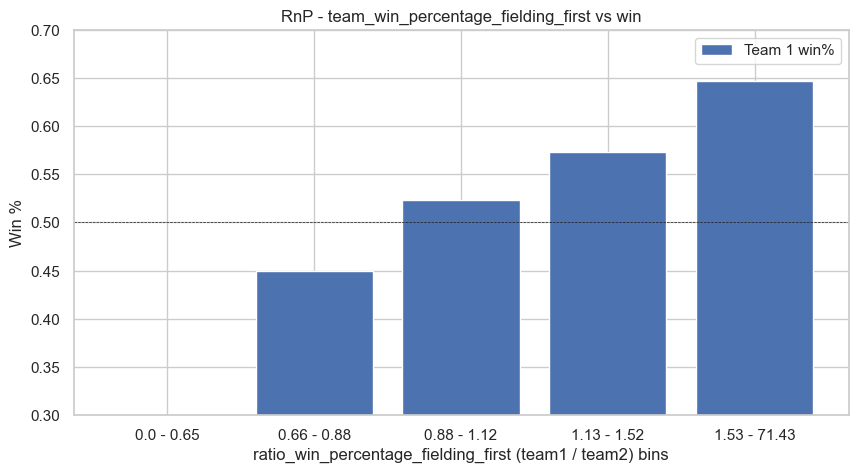

Correlation between team_win_percentage_fielding_first and winner_01 is: -0.08742231380636549


In [123]:
createRnP(train_data, 'team_win_percentage_fielding_first')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


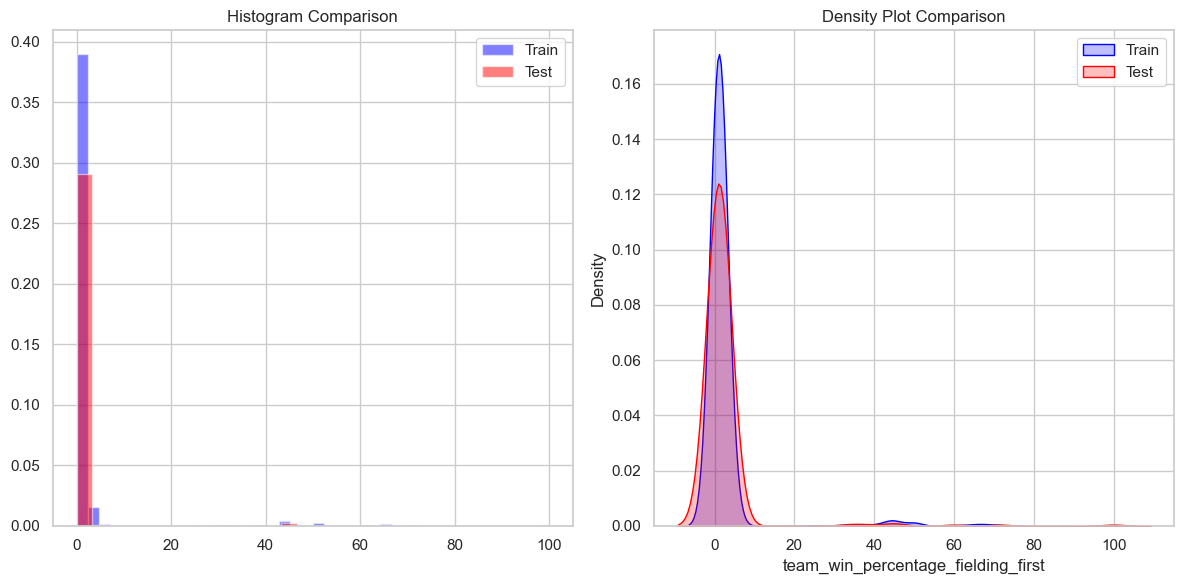

Kolmogorov-Smirnov test result: KS statistic = 0.0431, p-value = 0.8078

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      2.588952    2.489498
std       8.579653    9.424597
min       0.000000    0.000000
25%       0.715503    0.666667
50%       1.000000    1.000000
75%       1.370924    1.423962
max      71.428571  100.000000


In [124]:
check_distribution_match(train_data['team_win_percentage_fielding_first'], test_data['team_win_percentage_fielding_first'])

In [125]:
remove_skew(train_data, 'team_win_percentage_fielding_first', 'quantile')
remove_skew(test_data, 'team_win_percentage_fielding_first', 'quantile', train=False)

Skewness of team_win_percentage_fielding_first was 5.828009260432682. square root transformation applied. New skewness is 4.788200062449486
Skewness of team_win_percentage_fielding_first was 7.440560949116585. square root transformation applied. New skewness is 5.580686144979722


slope: 0.65 / 0.29 =  2.24


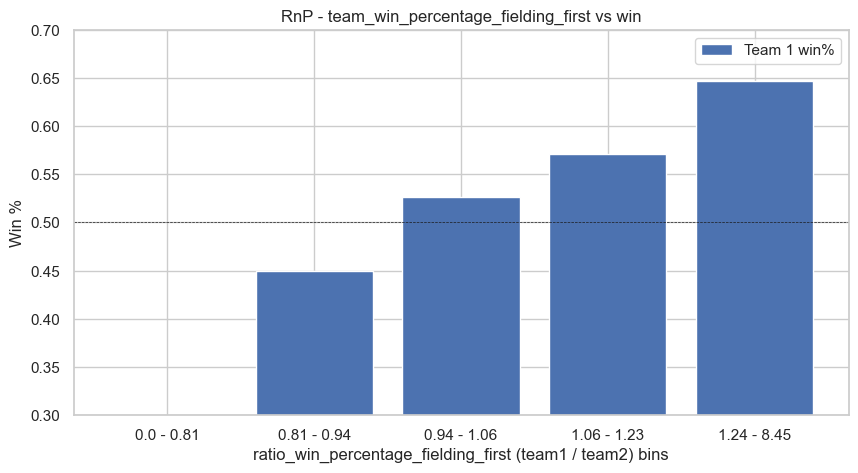

Correlation between team_win_percentage_fielding_first and winner_01 is: -0.12958160999811574


In [126]:
createRnP(train_data, 'team_win_percentage_fielding_first')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


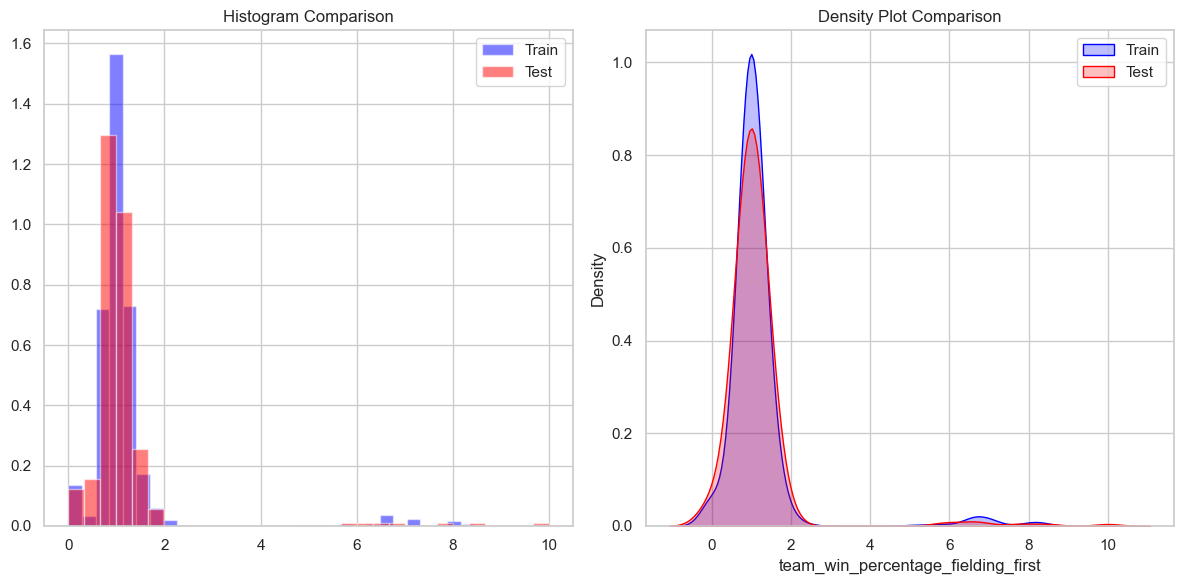

Kolmogorov-Smirnov test result: KS statistic = 0.0431, p-value = 0.8078

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.179446e+00  1.146338e+00
std    1.095045e+00  1.086168e+00
min    1.490116e-08  1.490116e-08
25%    8.458741e-01  8.164966e-01
50%    1.000000e+00  1.000000e+00
75%    1.170864e+00  1.193299e+00
max    8.451543e+00  1.000000e+01


In [127]:
check_distribution_match(train_data['team_win_percentage_fielding_first'], test_data['team_win_percentage_fielding_first'])

### team_avg_win_margin_runs

In [128]:
def avg_win_margin_runs(matches, team_id, date):
    win_by_runs_matches = matches[(matches['by'] == 'runs') & ((matches['team1_id'] == team_id) | (matches['team2_id'] == team_id)) & (matches['match_dt'] < date)]
    total_margin = win_by_runs_matches[win_by_runs_matches['winner_id'] == team_id]['win amount'].sum()
    total_matches = win_by_runs_matches[win_by_runs_matches['winner_id'] == team_id].shape[0]
    return total_margin / total_matches if total_matches > 0 else 0

In [129]:
train_data['team1_avg_win_margin_runs'] = train_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_avg_win_margin_runs'] = train_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_win_margin_runs', 'team2_avg_win_margin_runs', 'team_avg_win_margin_runs')

train_data = train_data.drop(columns=['team1_avg_win_margin_runs', 'team2_avg_win_margin_runs'])

test_data['team1_avg_win_margin_runs'] = test_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_avg_win_margin_runs'] = test_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_win_margin_runs', 'team2_avg_win_margin_runs', 'team_avg_win_margin_runs')

test_data = test_data.drop(columns=['team1_avg_win_margin_runs', 'team2_avg_win_margin_runs'])

slope: 0.53 / 0.44 =  1.2


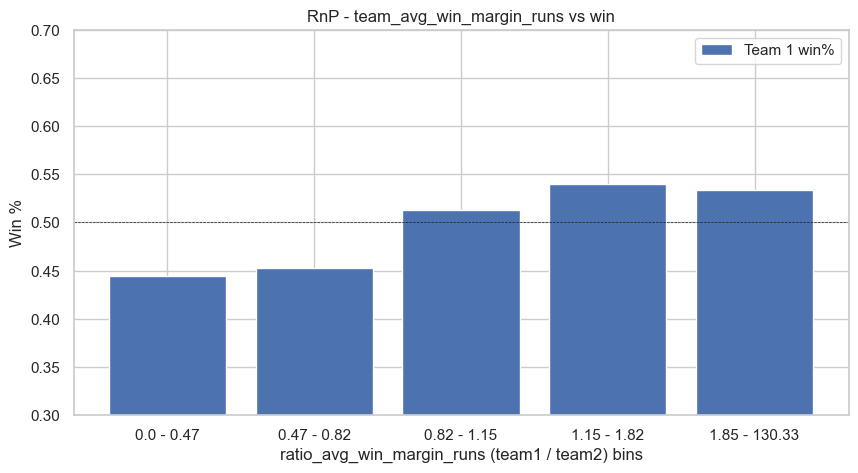

Correlation between team_avg_win_margin_runs and winner_01 is: -0.03073344181156112


In [130]:
createRnP(train_data, 'team_avg_win_margin_runs')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


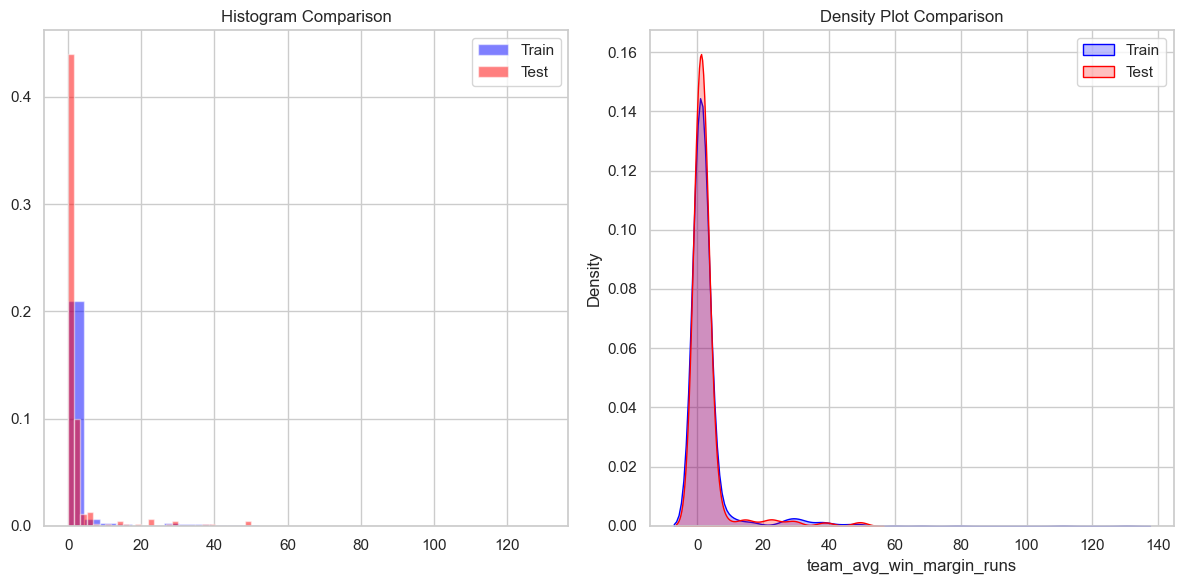

Kolmogorov-Smirnov test result: KS statistic = 0.0662, p-value = 0.2972

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      3.146298    2.660165
std       9.426177    6.618963
min       0.000000    0.000000
25%       0.589105    0.621948
50%       0.993953    1.024614
75%       1.597176    1.749286
max     130.333333   50.076923


In [131]:
check_distribution_match(train_data['team_avg_win_margin_runs'], test_data['team_avg_win_margin_runs'])

In [132]:
remove_skew(train_data, 'team_avg_win_margin_runs', 'quantile')
remove_skew(test_data, 'team_avg_win_margin_runs', 'quantile', train=False)

Skewness of team_avg_win_margin_runs was 6.921814274039963. square root transformation applied. New skewness is 3.5121795337499764
Skewness of team_avg_win_margin_runs was 4.948477463745763. square root transformation applied. New skewness is 3.0021647761207495


slope: 0.53 / 0.44 =  1.2


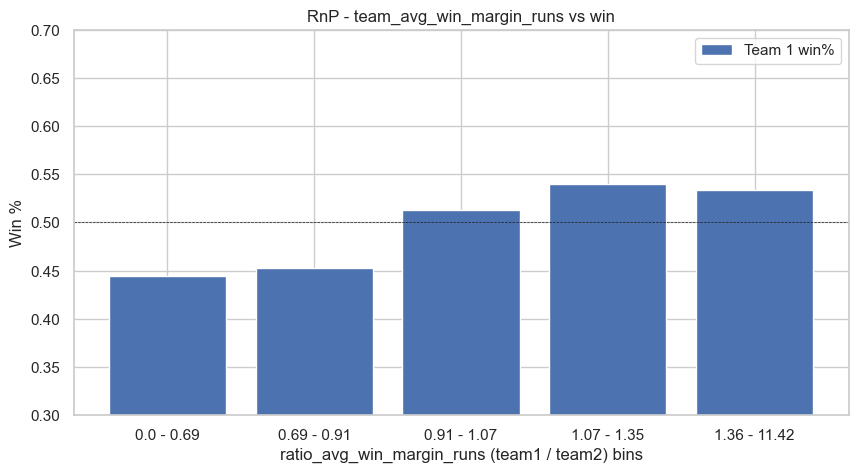

Correlation between team_avg_win_margin_runs and winner_01 is: -0.05114909979917129


In [133]:
createRnP(train_data, 'team_avg_win_margin_runs')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


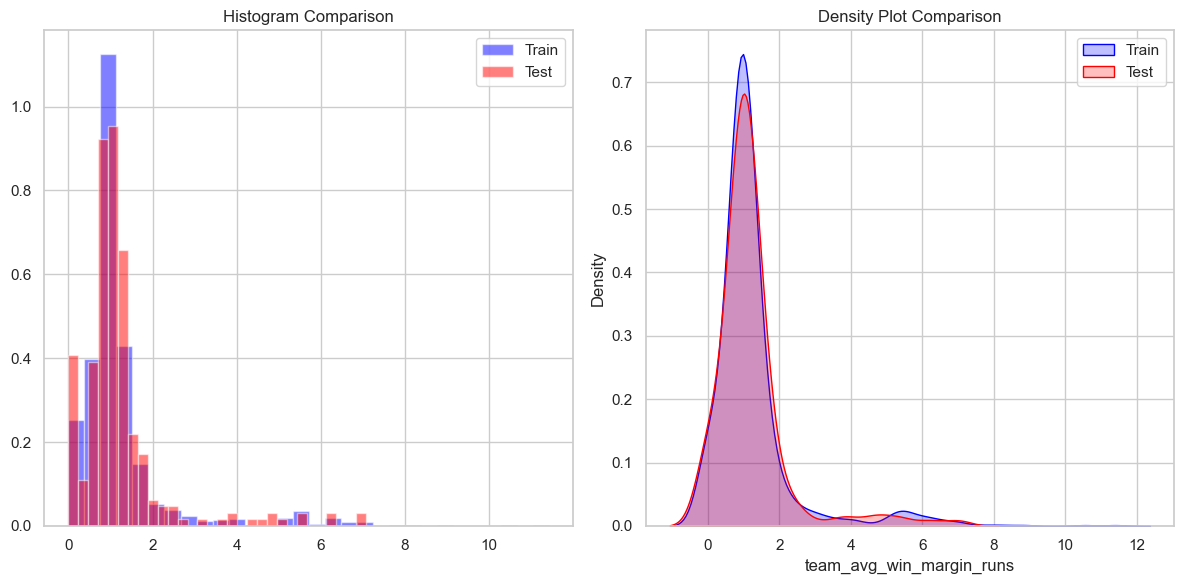

Kolmogorov-Smirnov test result: KS statistic = 0.0662, p-value = 0.2972

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.250265e+00  1.214785e+00
std    1.258892e+00  1.090344e+00
min    1.490116e-08  1.490116e-08
25%    7.675318e-01  7.886362e-01
50%    9.969717e-01  1.012232e+00
75%    1.263794e+00  1.322606e+00
max    1.141636e+01  7.076505e+00


In [134]:
check_distribution_match(train_data['team_avg_win_margin_runs'], test_data['team_avg_win_margin_runs'])

### team_winp_venue

In [135]:
def winpLastn_venue(team_id, date, ground_id,n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) & (match_lvl_data['ground_id']==ground_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

In [136]:
train_data['team1_winp_venue'] = train_data.progress_apply(lambda x: \
                                  winpLastn_venue(x['team1_id'], x['match_dt'],x['ground_id'], 15), axis=1)

train_data['team2_winp_venue'] = train_data.progress_apply(lambda x: \
                                  winpLastn_venue(x['team2_id'], x['match_dt'],x['ground_id'], 15), axis=1)

train_data = add_ratio_column(train_data, 'team1_winp_venue', 'team2_winp_venue', 'team_winp_venue')

train_data = train_data.drop(columns=['team1_winp_venue', 'team2_winp_venue'])

test_data['team1_winp_venue'] = test_data.progress_apply(lambda x: \
                                winpLastn_venue(x['team1_id'], x['match_dt'],x['ground_id'], 15), axis=1)

test_data['team2_winp_venue'] = test_data.progress_apply(lambda x: \
                                winpLastn_venue(x['team2_id'], x['match_dt'],x['ground_id'], 15), axis=1)

test_data = add_ratio_column(test_data, 'team1_winp_venue', 'team2_winp_venue', 'team_winp_venue')

test_data = test_data.drop(columns=['team1_winp_venue', 'team2_winp_venue'])

100%|██████████| 271/271 [00:00<00:00, 1977.88it/s]


slope: 0.56 / 0.4 =  1.42


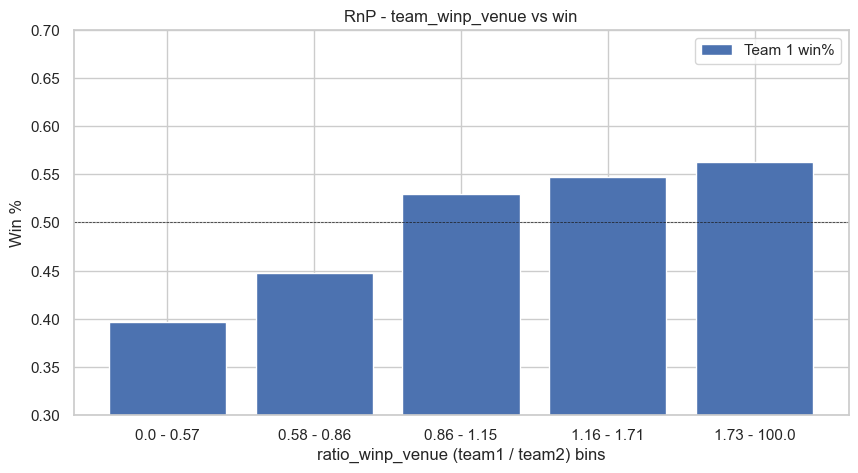

Correlation between team_winp_venue and winner_01 is: -0.05312515097696646


In [137]:
createRnP(train_data, 'team_winp_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


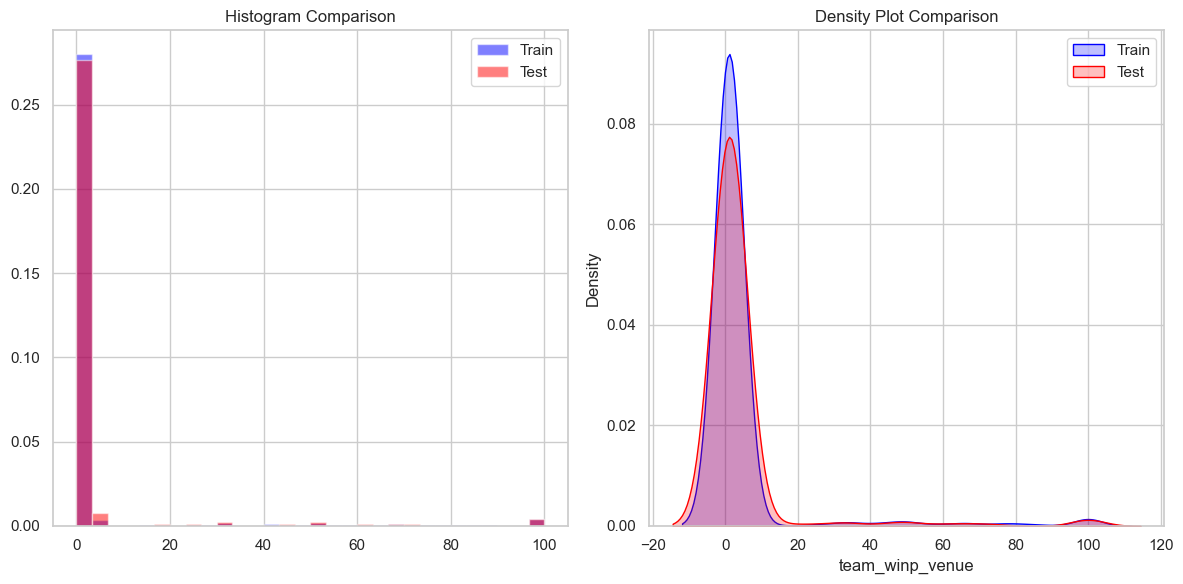

Kolmogorov-Smirnov test result: KS statistic = 0.0630, p-value = 0.3556

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      4.492258    4.253280
std      15.602713   14.798107
min       0.000000    0.000000
25%       0.650037    0.687004
50%       1.000000    1.047612
75%       1.500150    1.658566
max     100.000000  100.000000


In [138]:
check_distribution_match(train_data['team_winp_venue'], test_data['team_winp_venue'])

In [139]:
remove_skew(train_data, 'team_winp_venue', 'quantile')
remove_skew(test_data, 'team_winp_venue', 'quantile', train=False)

Skewness of team_winp_venue was 4.86724826469129. square root transformation applied. New skewness is 3.9742700018953436
Skewness of team_winp_venue was 5.255732985480996. square root transformation applied. New skewness is 4.130866939500279


slope: 0.56 / 0.4 =  1.42


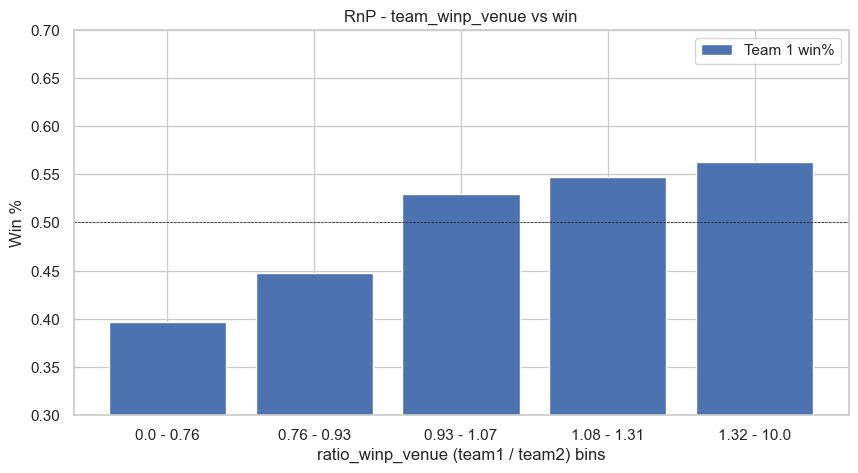

Correlation between team_winp_venue and winner_01 is: -0.0747597068814551


In [140]:
createRnP(train_data, 'team_winp_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


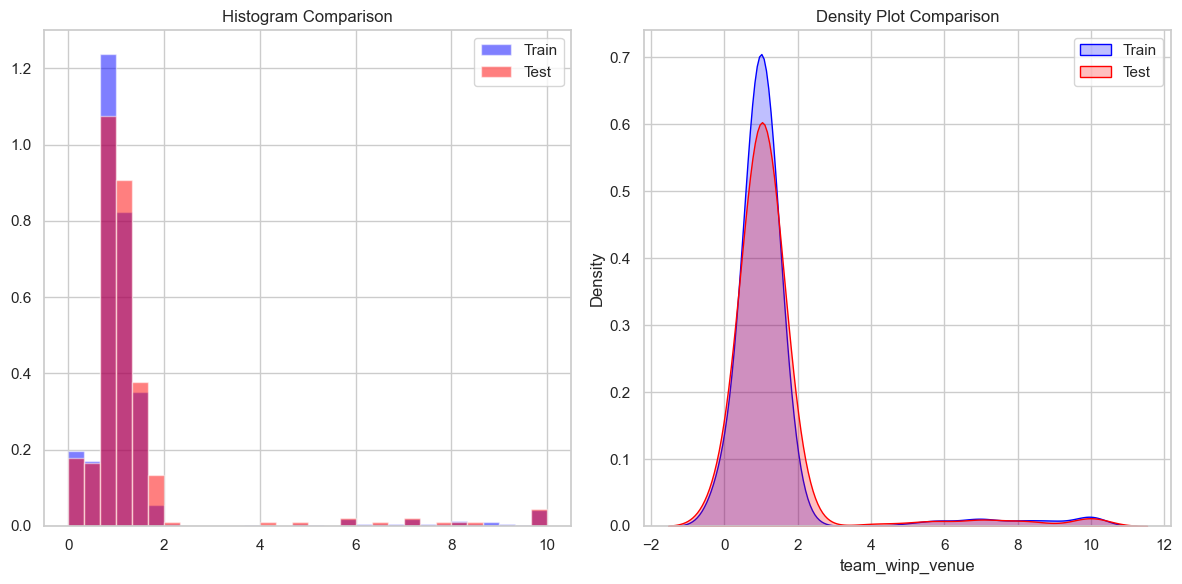

Kolmogorov-Smirnov test result: KS statistic = 0.0630, p-value = 0.3556

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.335998e+00  1.343776e+00
std    1.646276e+00  1.567358e+00
min    1.490116e-08  1.490116e-08
25%    8.062485e-01  8.288511e-01
50%    1.000000e+00  1.023529e+00
75%    1.224806e+00  1.287849e+00
max    1.000000e+01  1.000000e+01


In [141]:
check_distribution_match(train_data['team_winp_venue'], test_data['team_winp_venue'])

### team_avg_runs_1st_inning

In [142]:
def assign_toss_winner_flag(row):
    if row['team1'] == row['toss winner']:
        return row['team1_id']
    elif row['team2'] == row['toss winner']:
        return row['team2_id']
train_data['toss_winner_id'] = train_data.apply(assign_toss_winner_flag, axis=1)
match_lvl_data['toss_winner_id'] = match_lvl_data.apply(assign_toss_winner_flag, axis=1)
test_data['toss_winner_id']= test_data.apply(assign_toss_winner_flag, axis=1)

def assign_bat(row):
    if (row['toss_winner_id'] == row['team1_id']) & (row['toss decision']=='bat'):
        return row['team1_id']
    if (row['toss_winner_id'] != row['team1_id']) & (row['toss decision']=='field'):
        return row['team1_id']
    else:
        return row['team2_id']
train_data['bat_id'] = train_data.apply(assign_bat, axis=1) 
match_lvl_data['bat_id'] = match_lvl_data.apply(assign_bat, axis=1)
test_data['bat_id'] = test_data.apply(assign_bat, axis=1)

In [143]:
def teamAvgRunsLastn_innings1(team_id, bat_id,date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                    ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) & (match_lvl_data['bat_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    return df_rel['inning1_runs'].mean()

In [144]:
train_data['runs_team1_1st_inning']= train_data.progress_apply(lambda x: \
                                 teamAvgRunsLastn_innings1(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)
train_data['runs_team2_1st_inning']= train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn_innings1(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'runs_team1_1st_inning', 'runs_team2_1st_inning', 'team_avg_runs_1st_inning')

train_data = train_data.drop(columns=['runs_team1_1st_inning', 'runs_team2_1st_inning'])

test_data['runs_team1_1st_inning']= test_data.progress_apply(lambda x: \
                                    teamAvgRunsLastn_innings1(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data['runs_team2_1st_inning']= test_data.progress_apply(lambda x: \
                                    teamAvgRunsLastn_innings1(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'runs_team1_1st_inning', 'runs_team2_1st_inning', 'team_avg_runs_1st_inning')

test_data = test_data.drop(columns=['runs_team1_1st_inning', 'runs_team2_1st_inning'])

100%|██████████| 271/271 [00:00<00:00, 2159.81it/s]


slope: 0.55 / 0.44 =  1.25


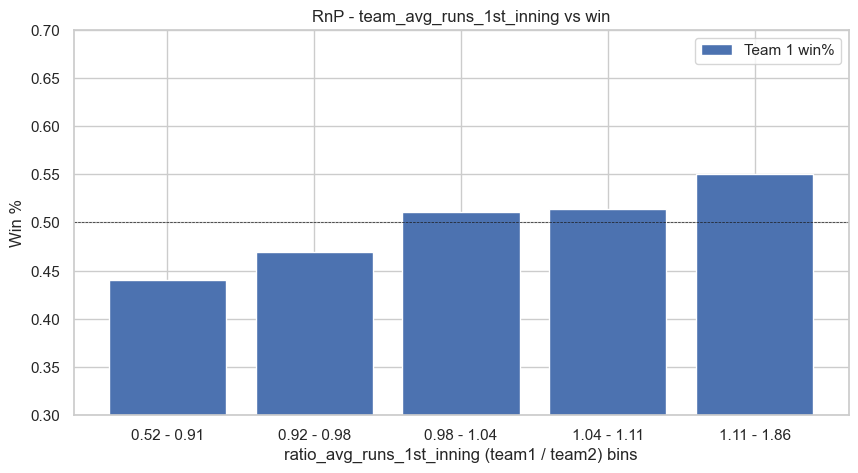

Correlation between team_avg_runs_1st_inning and winner_01 is: -0.08210253516941837


In [145]:
createRnP(train_data, 'team_avg_runs_1st_inning')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


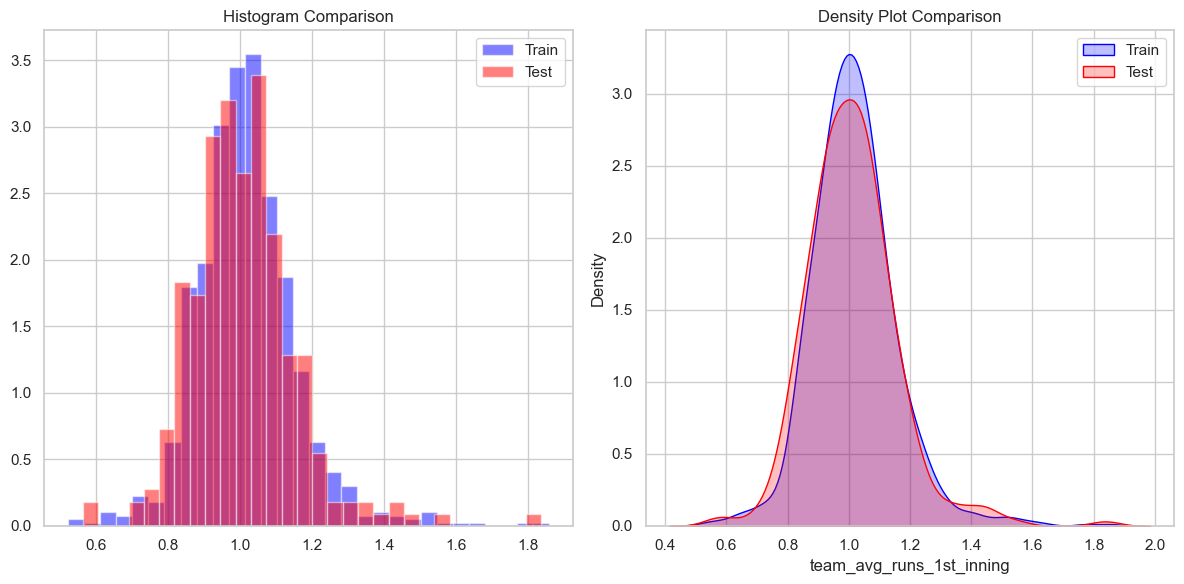

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   887.000000  257.000000
mean      1.016814    1.009674
std       0.141082    0.147750
min       0.523536    0.563282
25%       0.931371    0.919311
50%       1.007966    1.001393
75%       1.087347    1.082585
max       1.858280    1.838217


In [146]:
check_distribution_match(train_data['team_avg_runs_1st_inning'], test_data['team_avg_runs_1st_inning'])

In [147]:
remove_skew(train_data, 'team_avg_runs_1st_inning', 'quantile')
remove_skew(test_data, 'team_avg_runs_1st_inning', 'quantile', train=False)

Skewness of team_avg_runs_1st_inning was 0.8841650214727479. square root transformation applied. New skewness is 0.41273993045076923
Skewness of team_avg_runs_1st_inning was 1.0798425599054602. square root transformation applied. New skewness is 0.5782630916524207


slope: 0.55 / 0.44 =  1.25


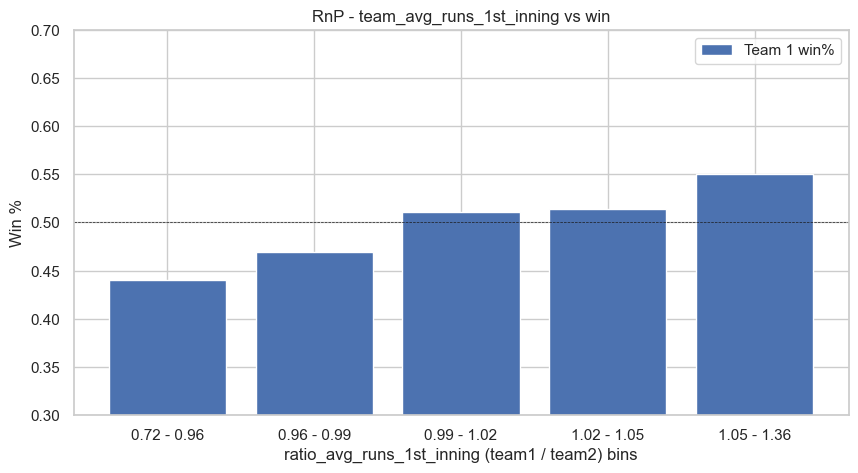

Correlation between team_avg_runs_1st_inning and winner_01 is: -0.08549267375420454


In [148]:
createRnP(train_data, 'team_avg_runs_1st_inning')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


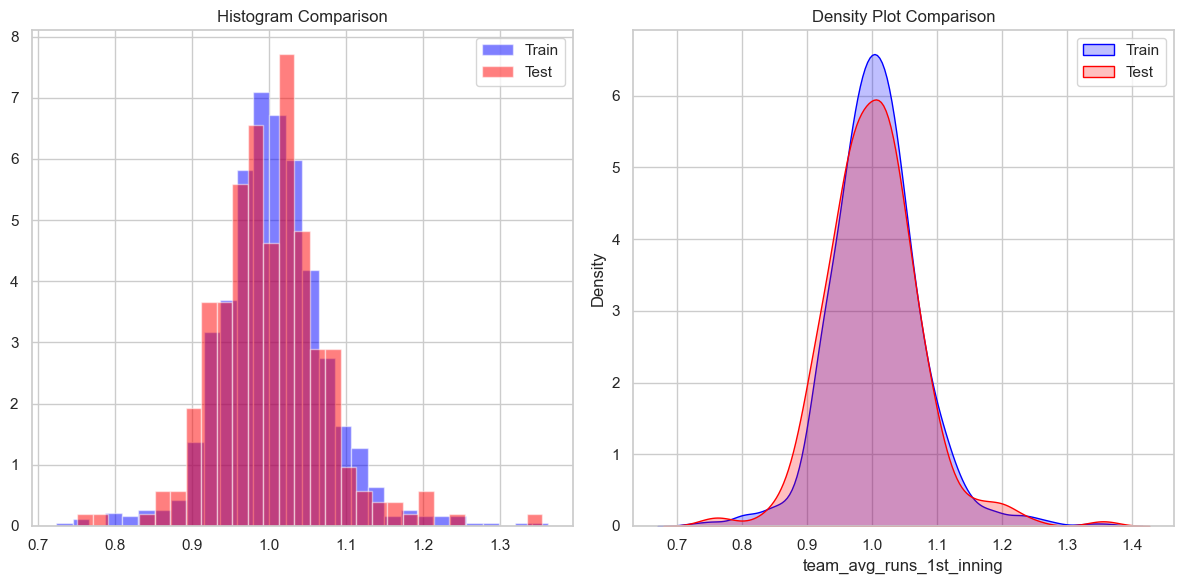

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   887.000000  257.000000
mean      1.006014    1.002251
std       0.068964    0.072016
min       0.723558    0.750521
25%       0.965076    0.958807
50%       1.003975    1.000696
75%       1.042759    1.040473
max       1.363188    1.355808


In [149]:
check_distribution_match(train_data['team_avg_runs_1st_inning'], test_data['team_avg_runs_1st_inning'])

### team_SR

In [150]:
def SRLastn(player_list, date, n):
    '''
    Function to get the average strike rate of players in the roster of a team in the last n games.
    
    Input:
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output: None
    
    Returns: float value denoting the average strike rate of all players in the roster.
    '''
    
    # Split the player_list into individual player IDs
    player_list = str(player_list).split(':')
    res_list = []
    
    # Loop through each player ID
    for player in player_list:
        # Get batting stats from the last n games for each player
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        # Calculate the mean strike rate for the player and append it to res_list
        if not df_rel.empty:
            res_list.append(np.nanmean(df_rel['strike_rate']))
    
    # Return the mean of strike rates from res_list if it contains any values
    if res_list:
        return np.nanmean(res_list)
    else:
        return np.nan  # Return NaN if res_list is empty

In [151]:
train_data['team1_SR'] = train_data.progress_apply(lambda x: \
            SRLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_SR'] = train_data.progress_apply(lambda x: \
            SRLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_SR', 'team2_SR', 'team_SR')

train_data = train_data.drop(columns=['team1_SR', 'team2_SR'])

test_data['team1_SR'] = test_data.progress_apply(lambda x: \
            SRLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_SR'] = test_data.progress_apply(lambda x: \
            SRLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_SR', 'team2_SR', 'team_SR')

test_data = test_data.drop(columns=['team1_SR', 'team2_SR'])

 60%|█████▉    | 566/948 [00:06<00:04, 85.89it/s]/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_16758/552435339.py:25: RuntimeWarning: Mean of empty slice
  res_list.append(np.nanmean(df_rel['strike_rate']))
 34%|███▍      | 326/948 [00:03<00:07, 85.24it/s]/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_16758/552435339.py:25: RuntimeWarning: Mean of empty slice
  res_list.append(np.nanmean(df_rel['strike_rate']))
 90%|█████████ | 245/271 [00:02<00:00, 84.15it/s]/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_16758/552435339.py:25: RuntimeWarning: Mean of empty slice
  res_list.append(np.nanmean(df_rel['strike_rate']))
100%|██████████| 271/271 [00:03<00:00, 83.42it/s]


slope: 0.54 / 0.37 =  1.48


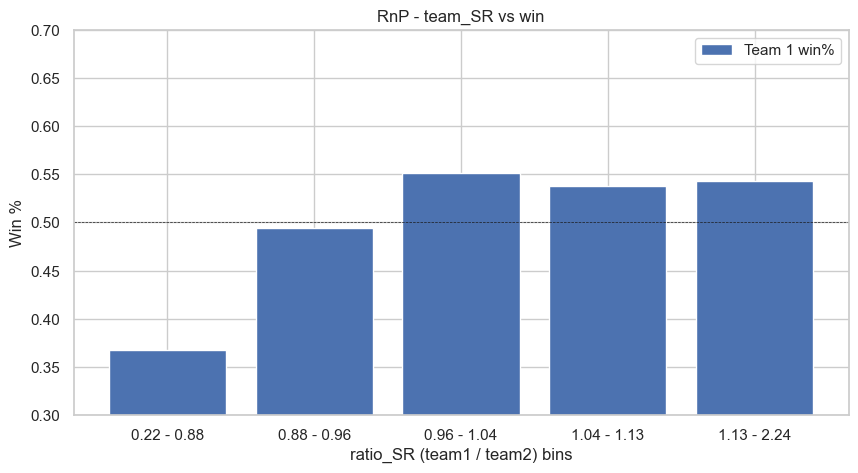

Correlation between team_SR and winner_01 is: -0.10303322140127094


In [152]:
createRnP(train_data, 'team_SR')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


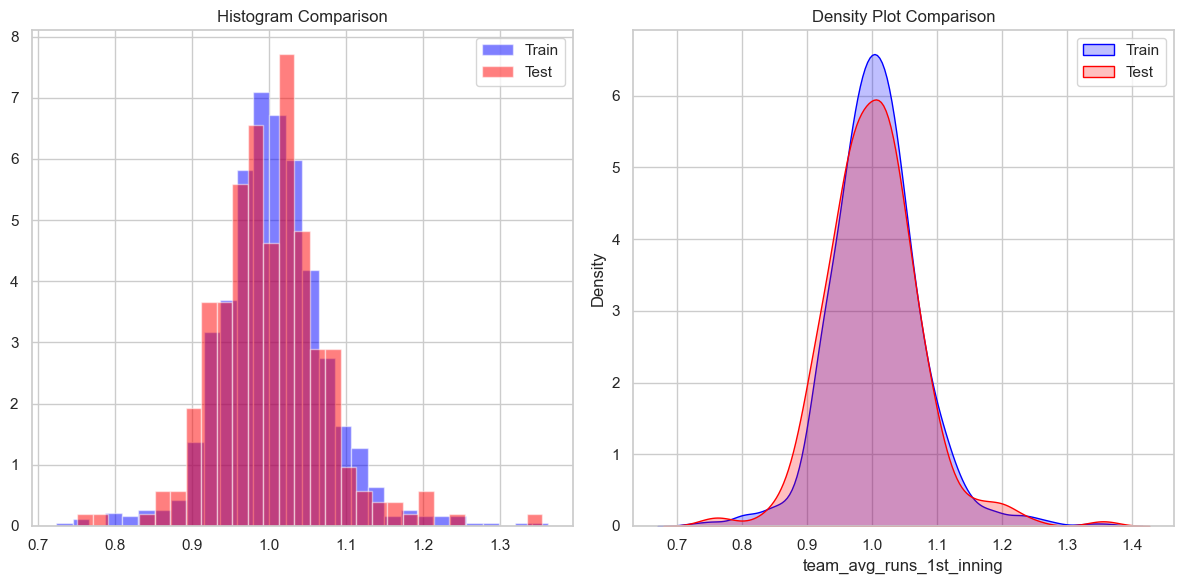

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   887.000000  257.000000
mean      1.006014    1.002251
std       0.068964    0.072016
min       0.723558    0.750521
25%       0.965076    0.958807
50%       1.003975    1.000696
75%       1.042759    1.040473
max       1.363188    1.355808


In [153]:
check_distribution_match(train_data['team_avg_runs_1st_inning'], test_data['team_avg_runs_1st_inning'])

In [154]:
remove_skew(train_data, 'team_SR', 'quantile')
remove_skew(test_data, 'team_SR', 'quantile', train=False)

Skewness of team_SR was 1.1648706270497533. square root transformation applied. New skewness is 0.29864427694499057
Skewness of team_SR was 2.4372563024459653. square root transformation applied. New skewness is 1.41419434873219


slope: 0.54 / 0.37 =  1.48


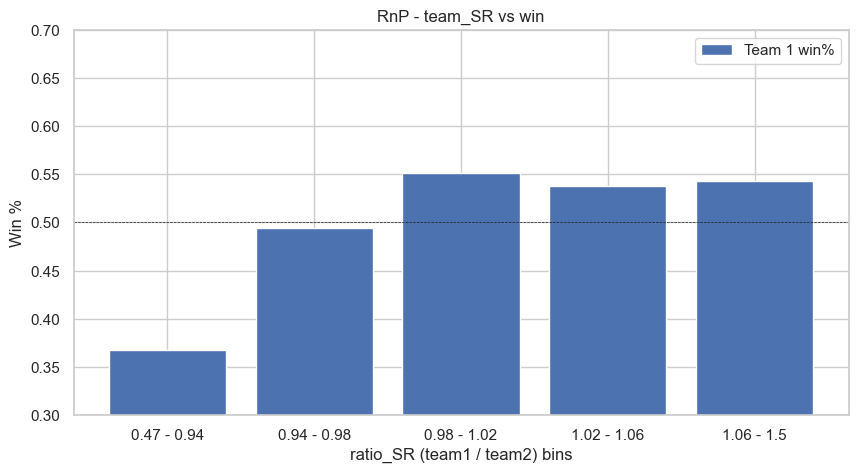

Correlation between team_SR and winner_01 is: -0.10773980146210949


In [155]:
createRnP(train_data, 'team_SR')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


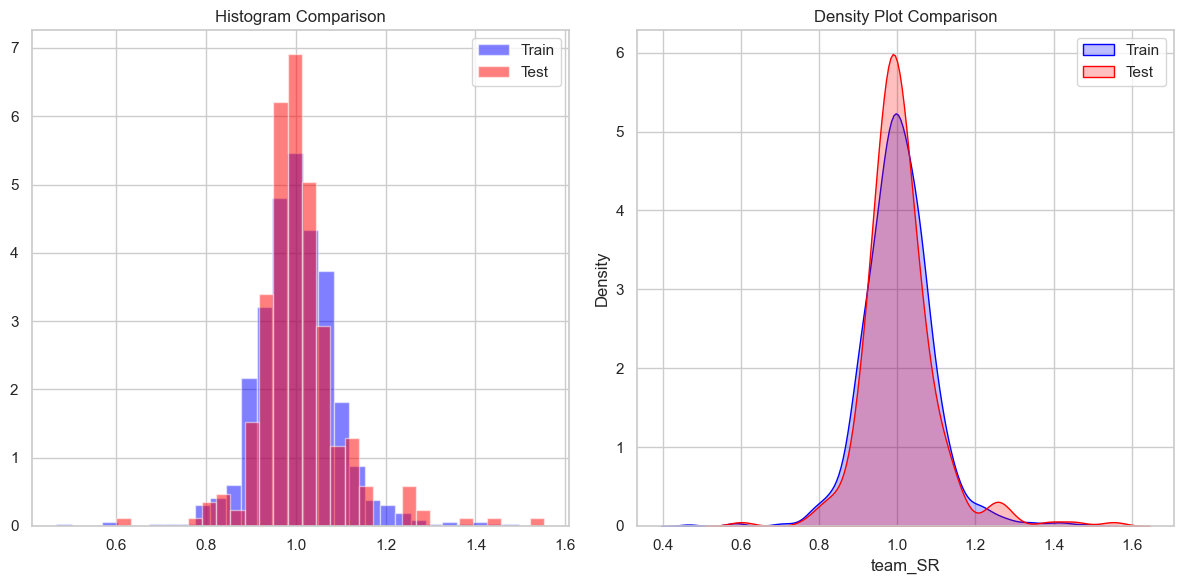

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   928.000000  269.000000
mean      1.002814    1.006138
std       0.091219    0.094273
min       0.466815    0.600981
25%       0.953292    0.958428
50%       1.000350    0.992989
75%       1.051934    1.040717
max       1.496160    1.552988


In [156]:
check_distribution_match(train_data['team_SR'], test_data['team_SR'])

### team_avg

In [157]:
def RunsLastn(player_list, date, n):
    '''
    Function to get the average strike rate of players in the roster of a team in the last n games.
    
    Input:
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output: None
    
    Returns: float value denoting the average strike rate of all players in the roster.
    '''
    
    # Split the player_list into individual player IDs
    player_list = str(player_list).split(':')
    res_list = []
    
    # Loop through each player ID
    for player in player_list:
        # Get batting stats from the last n games for each player
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        # Calculate the mean strike rate for the player and append it to res_list
        if not df_rel.empty:
            res_list.append(np.nanmean(df_rel['runs']))
    
    # Return the mean of strike rates from res_list if it contains any values
    if res_list:
        return np.nanmean(res_list)
    else:
        return np.nan  # Return NaN if res_list is empty

In [158]:
train_data['team1_avg'] = train_data.progress_apply(lambda x: \
            RunsLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg'] = train_data.progress_apply(lambda x: \
            RunsLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg', 'team2_avg', 'team_avg')

train_data = train_data.drop(columns=['team1_avg', 'team2_avg'])

test_data['team1_avg'] = test_data.progress_apply(lambda x: \
            RunsLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_avg'] = test_data.progress_apply(lambda x: \
            RunsLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg', 'team2_avg', 'team_avg')

test_data = test_data.drop(columns=['team1_avg', 'team2_avg'])

100%|██████████| 271/271 [00:03<00:00, 82.46it/s]


slope: 0.58 / 0.45 =  1.28


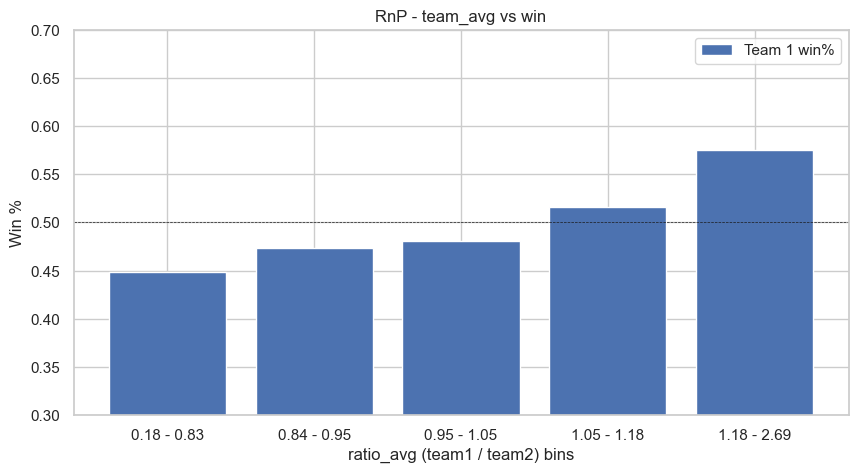

Correlation between team_avg and winner_01 is: -0.08523384183174122


In [159]:
createRnP(train_data, 'team_avg')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


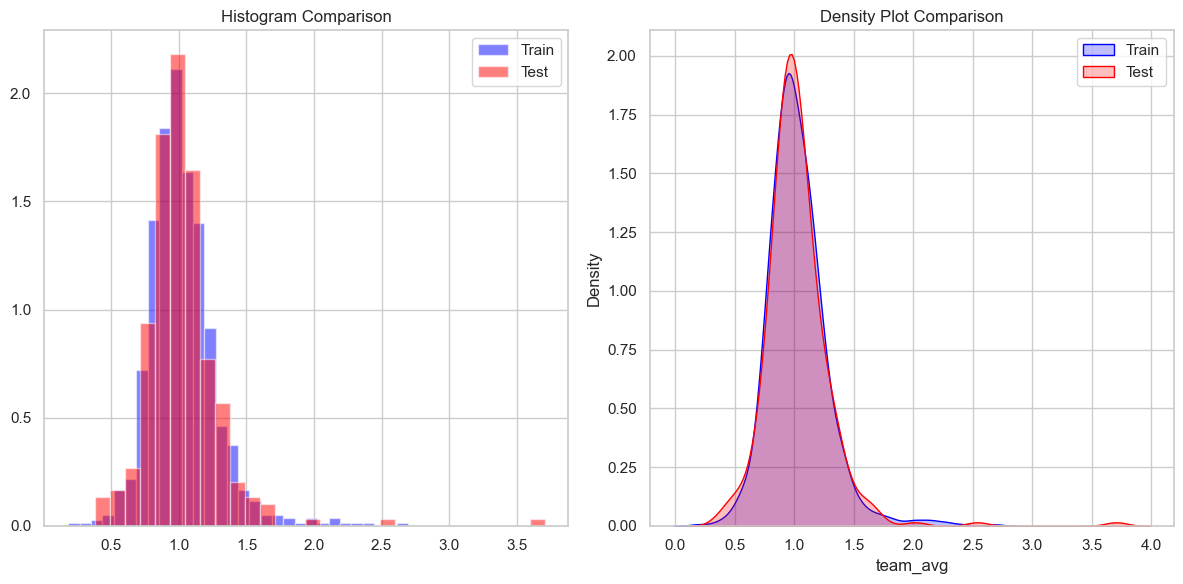

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   928.000000  269.000000
mean      1.025177    1.025734
std       0.254277    0.291027
min       0.181745    0.381546
25%       0.872787    0.898367
50%       0.991571    0.977446
75%       1.144019    1.114197
max       2.694952    3.705109


In [160]:
check_distribution_match(train_data['team_avg'], test_data['team_avg'])

In [161]:
remove_skew(train_data, 'team_avg', 'quantile')
remove_skew(test_data, 'team_avg', 'quantile', train=False)

Skewness of team_avg was 1.4513778649397033. square root transformation applied. New skewness is 0.5958689968775205
Skewness of team_avg was 3.6299182519040833. square root transformation applied. New skewness is 1.618353822413215


slope: 0.58 / 0.45 =  1.28


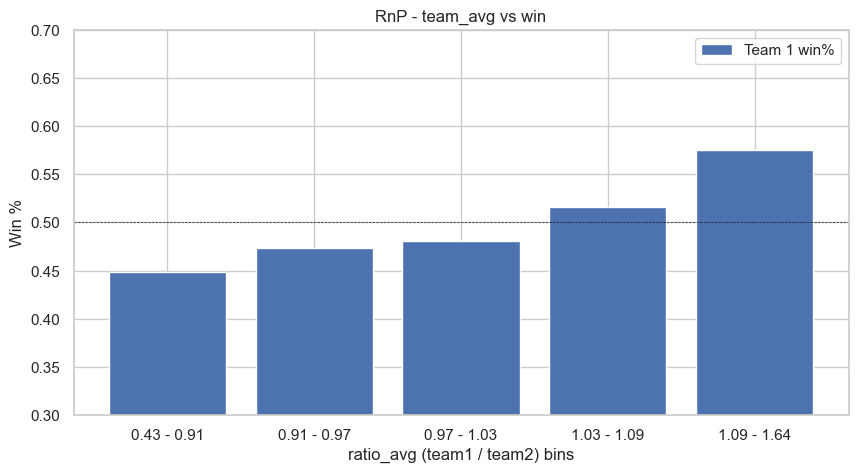

Correlation between team_avg and winner_01 is: -0.08556598382301839


In [162]:
createRnP(train_data, 'team_avg')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


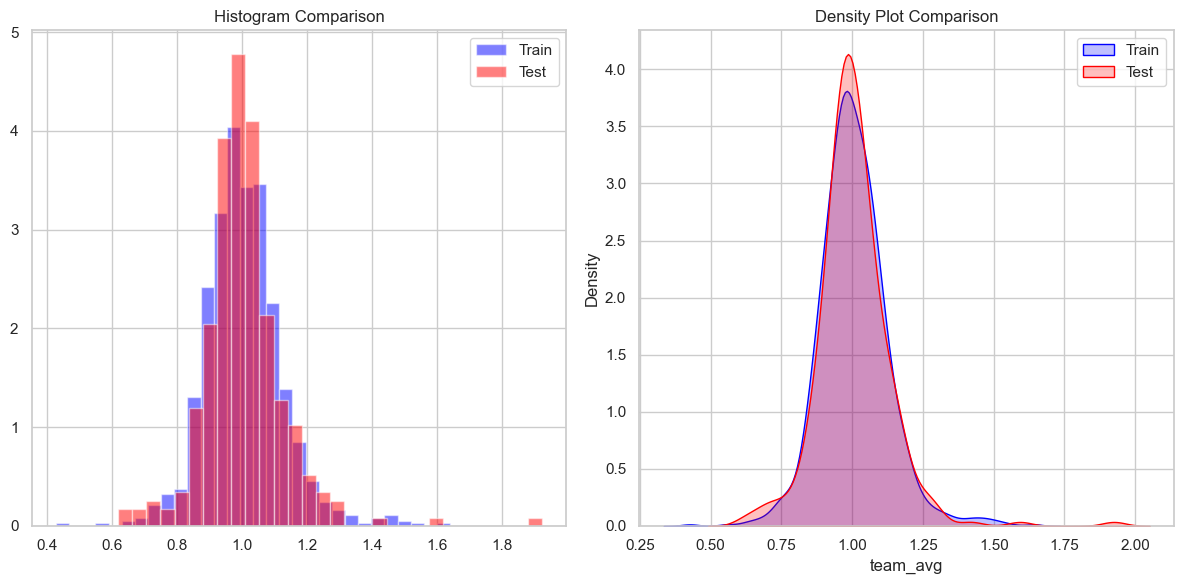

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   928.000000  269.000000
mean      1.005248    1.004555
std       0.121114    0.129094
min       0.426315    0.617694
25%       0.934231    0.947822
50%       0.995777    0.988659
75%       1.069588    1.055555
max       1.641631    1.924866


In [163]:
check_distribution_match(train_data['team_avg'], test_data['team_avg'])

### team_avg_wkt

In [164]:
def WicketsLastn(player_list, date, n):
    '''
    Function to get the average strike rate of players in the roster of a team in the last n games.
    
    Input:
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output: None
    
    Returns: float value denoting the average strike rate of all players in the roster.
    '''
    
    # Split the player_list into individual player IDs
    player_list = str(player_list).split(':')
    res_list = []
    
    # Loop through each player ID
    for player in player_list:
        # Get batting stats from the last n games for each player
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl')
        # Calculate the mean strike rate for the player and append it to res_list
        if not df_rel.empty:
            res_list.append(np.nanmean(df_rel['wicket_count']))
    
    # Return the mean of strike rates from res_list if it contains any values
    if res_list:
        return np.nanmean(res_list)
    else:
        return np.nan  # Return NaN if res_list is empty

In [165]:
train_data['team1_avg_wkt'] = train_data.progress_apply(lambda x: \
            WicketsLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_wkt'] = train_data.progress_apply(lambda x: \
            WicketsLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wkt', 'team2_avg_wkt', 'team_avg_wkt')

train_data = train_data.drop(columns=['team1_avg_wkt', 'team2_avg_wkt'])

test_data['team1_avg_wkt'] = test_data.progress_apply(lambda x: \
            WicketsLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_avg_wkt'] = test_data.progress_apply(lambda x: \
            WicketsLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wkt', 'team2_avg_wkt', 'team_avg_wkt')

test_data = test_data.drop(columns=['team1_avg_wkt', 'team2_avg_wkt'])

100%|██████████| 271/271 [00:02<00:00, 93.14it/s] 


slope: 0.52 / 0.48 =  1.09


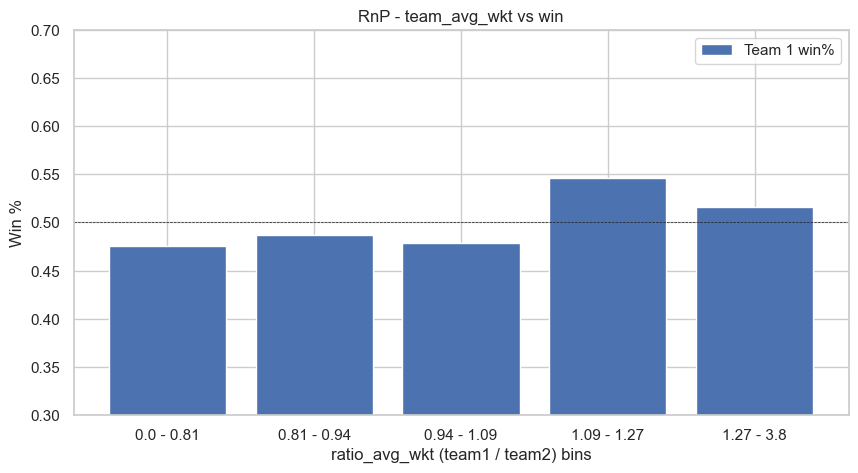

Correlation between team_avg_wkt and winner_01 is: -0.0601197082612971


In [166]:
createRnP(train_data, 'team_avg_wkt')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


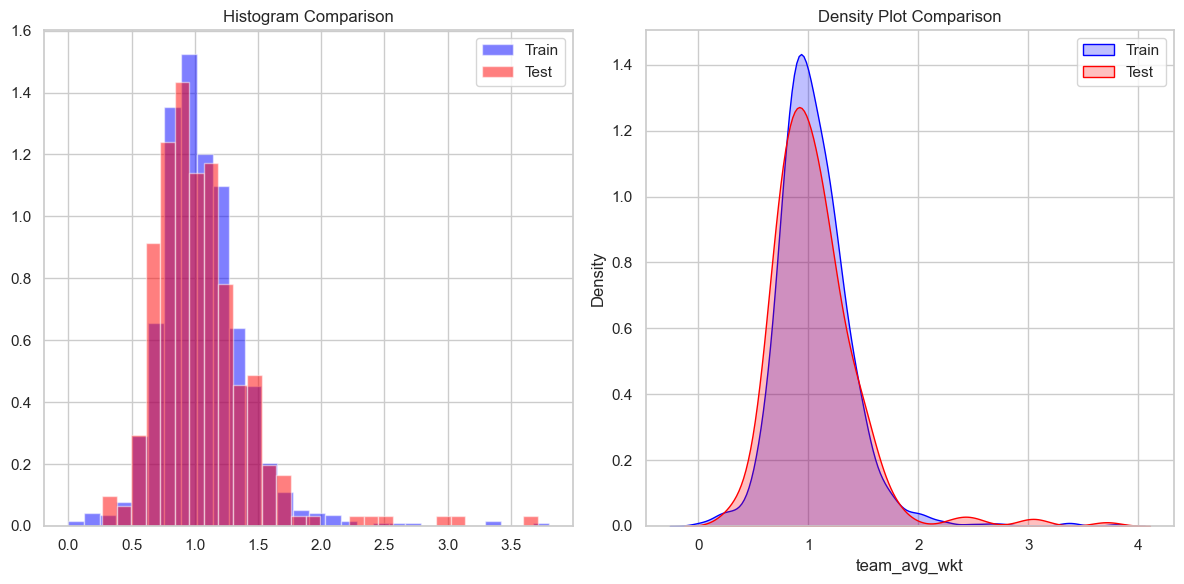

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   927.000000  267.000000
mean      1.053838    1.051226
std       0.341371    0.401116
min       0.000000    0.267846
25%       0.850109    0.805248
50%       1.010415    0.981622
75%       1.217520    1.213815
max       3.800000    3.713542


In [167]:
check_distribution_match(train_data['team_avg_wkt'], test_data['team_avg_wkt'])

In [168]:
remove_skew(train_data, 'team_avg_wkt', 'quantile')
remove_skew(test_data, 'team_avg_wkt', 'quantile', train=False)

Skewness of team_avg_wkt was 1.795851151271481. square root transformation applied. New skewness is 0.19270918660845268
Skewness of team_avg_wkt was 2.483061166895933. square root transformation applied. New skewness is 1.1992939947374404


slope: 0.52 / 0.48 =  1.09


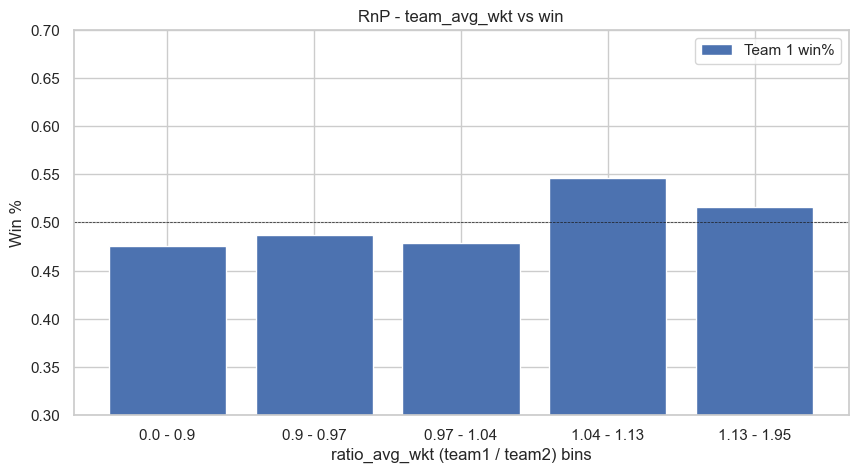

Correlation between team_avg_wkt and winner_01 is: -0.06053333962481556


In [169]:
createRnP(train_data, 'team_avg_wkt')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


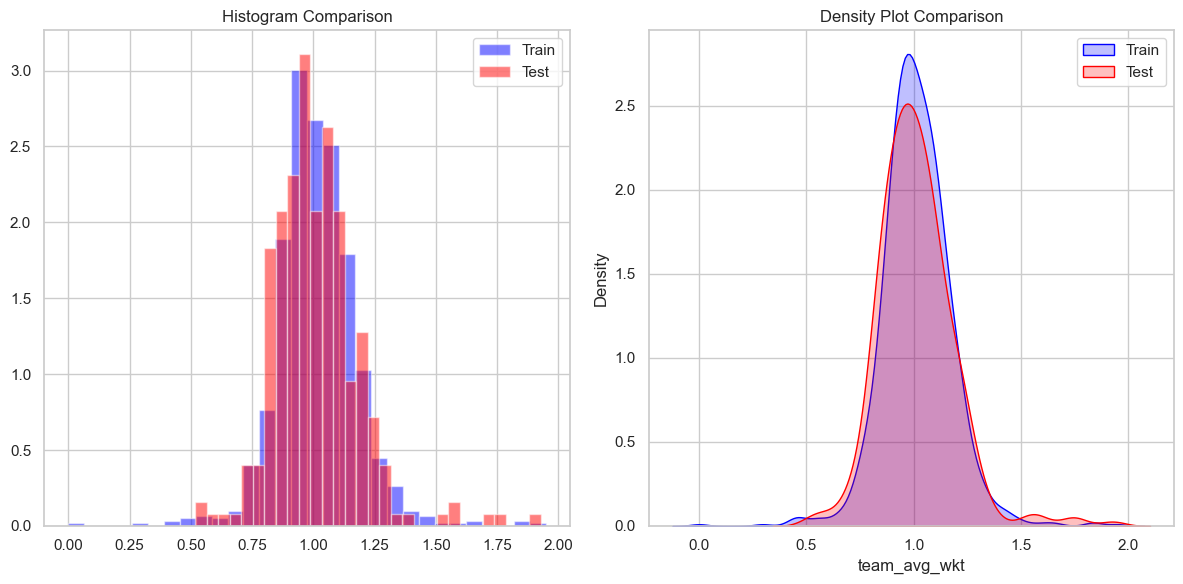

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count  9.270000e+02  267.000000
mean   1.013663e+00    1.009948
std    1.623400e-01    0.177054
min    1.490116e-08    0.517539
25%    9.220134e-01    0.897356
50%    1.005194e+00    0.990769
75%    1.103413e+00    1.101733
max    1.949359e+00    1.927055


In [170]:
check_distribution_match(train_data['team_avg_wkt'], test_data['team_avg_wkt'])

### team_avg_eco

In [171]:
def EcoLastn(player_list, date, n):
    '''
    Function to get the average strike rate of players in the roster of a team in the last n games.
    
    Input:
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output: None
    
    Returns: float value denoting the average strike rate of all players in the roster.
    '''
    
    # Split the player_list into individual player IDs
    player_list = str(player_list).split(':')
    res_list = []
    
    # Loop through each player ID
    for player in player_list:
        # Get batting stats from the last n games for each player
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl')
        # Calculate the mean strike rate for the player and append it to res_list
        if not df_rel.empty:
            res_list.append(np.nanmean(df_rel['economy']))
    
    # Return the mean of strike rates from res_list if it contains any values
    if res_list:
        return np.nanmean(res_list)
    else:
        return np.nan  # Return NaN if res_list is empty

In [172]:
train_data['team1_avg_eco'] = train_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_eco'] = train_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_eco', 'team2_avg_eco', 'team_avg_eco')

train_data = train_data.drop(columns=['team1_avg_eco', 'team2_avg_eco'])

test_data['team1_avg_eco'] = test_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_avg_eco'] = test_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_eco', 'team2_avg_eco', 'team_avg_eco')

test_data = test_data.drop(columns=['team1_avg_eco', 'team2_avg_eco'])

100%|██████████| 271/271 [00:02<00:00, 93.12it/s]


slope: 0.57 / 0.45 =  1.27


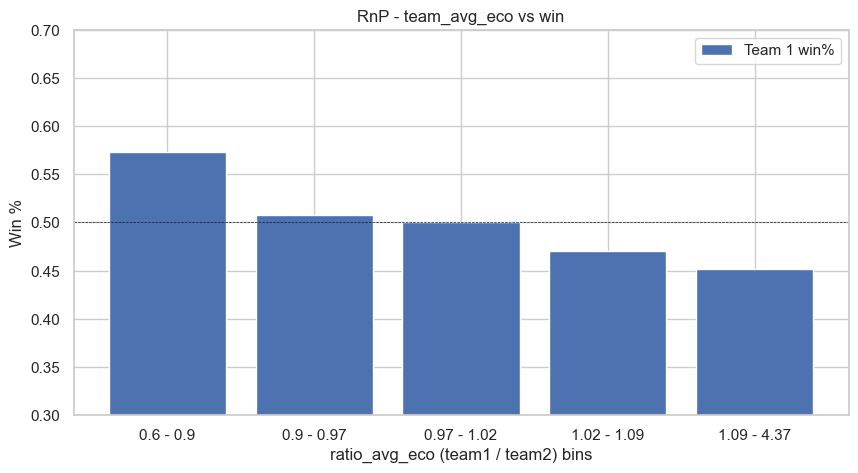

Correlation between team_avg_eco and winner_01 is: 0.029889408874522787


In [173]:
createRnP(train_data, 'team_avg_eco')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


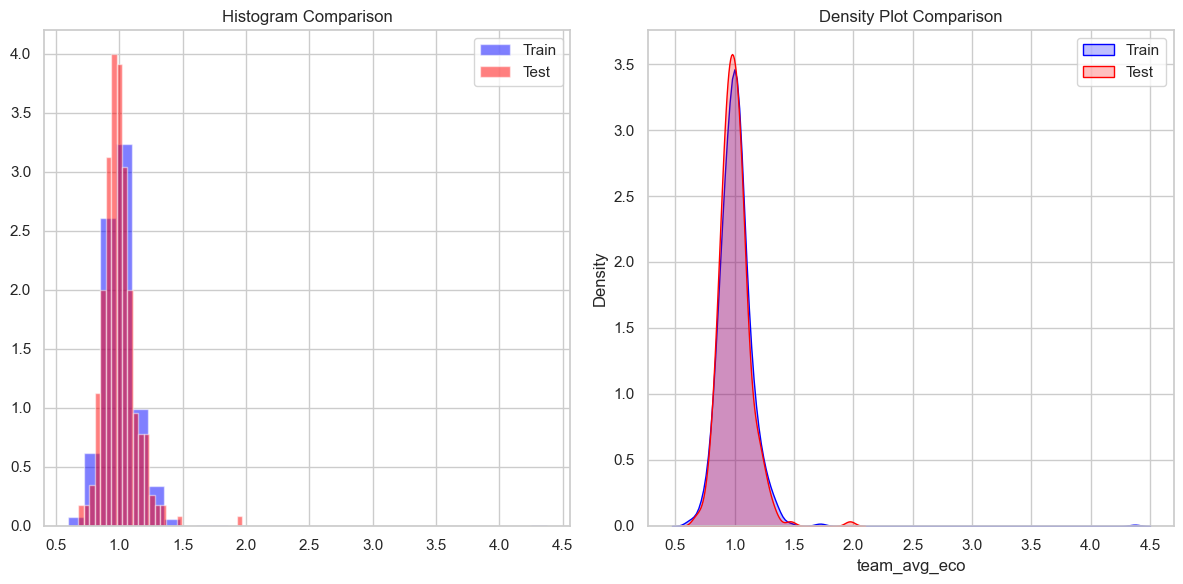

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   927.000000  267.000000
mean      1.006520    0.997867
std       0.168425    0.130098
min       0.598698    0.676974
25%       0.921918    0.920045
50%       0.997530    0.985647
75%       1.065874    1.052922
max       4.371515    1.969705


In [174]:
check_distribution_match(train_data['team_avg_eco'], test_data['team_avg_eco'])

In [175]:
remove_skew(train_data, 'team_avg_eco', 'quantile')
remove_skew(test_data, 'team_avg_eco', 'quantile', train=False)

Skewness of team_avg_eco was 8.883806996584346. square root transformation applied. New skewness is 3.8977337089611965
Skewness of team_avg_eco was 1.9127607121255688. square root transformation applied. New skewness is 1.233133285415187


slope: 0.57 / 0.45 =  1.27


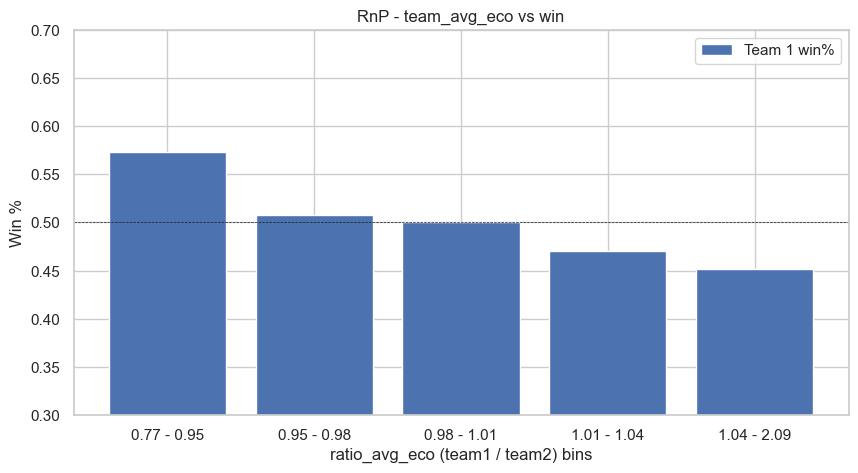

Correlation between team_avg_eco and winner_01 is: 0.04437471764739176


In [176]:
createRnP(train_data, 'team_avg_eco')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


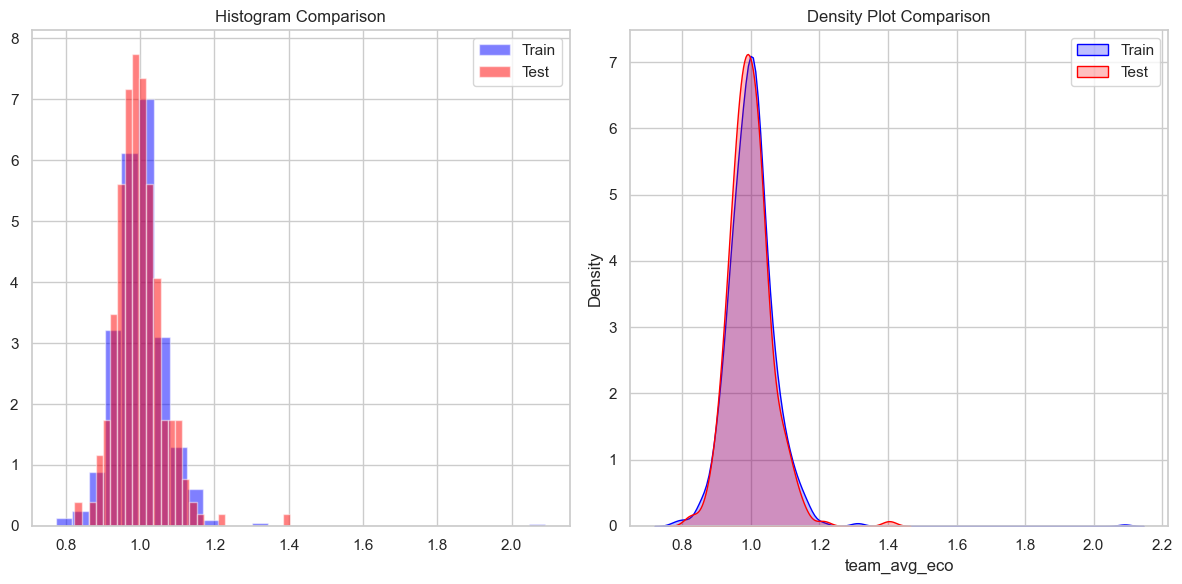

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   927.000000  267.000000
mean      1.000651    0.996974
std       0.072272    0.062635
min       0.773756    0.822784
25%       0.960165    0.959190
50%       0.998764    0.992797
75%       1.032412    1.026120
max       2.090817    1.403462


In [177]:
check_distribution_match(train_data['team_avg_eco'], test_data['team_avg_eco'])

## Model Training 

In [178]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'winner_01', 'team_wicket_loss_average',
       'team_bowler_performance_ratio', 'team_strike_rate', 'team_avg_wicket',
       'team_batting_strength', 'team_win_rate_at_venue',
       'team_batsman_performance_index', 'team_overall_win_rate',
       'team_recent_form', 'team_momentum', 'team_batsman_performance_recent',
       'team_batsman_runs_recent', 'team_pom_frequency',
       'team_count_100runs_ratio_last15', 'team_avg_wickets_top5_bowlers',
       'team_win_percentage_fielding_first', 'team_avg_win_margin_runs',
       'team_winp_venue', 'toss_winner_id', 'bat_id',
       'team_avg_ru

In [179]:
best_feat = ['team_count_50runs_last15', 'team_bowler_performance_ratio', 
             'team_batting_strength','team_batsman_performance_recent', 'team_batsman_runs_recent','team_pom_frequency',
             'team_count_100runs_ratio_last15','team_avg_wickets_top5_bowlers','team_win_percentage_fielding_first',
             'team_winp_venue','winner_01']

In [180]:
col = ['team_count_50runs_last15',  'team_wicket_loss_average',
       'team_bowler_performance_ratio', 'team_strike_rate', 'team_avg_wicket',
       'team_batting_strength', 'team_win_rate_at_venue',
       'team_batsman_performance_index', 'team_overall_win_rate',
       'team_recent_form', 'team_momentum', 'team_batsman_performance_recent',
       'team_batsman_runs_recent', 'team_pom_frequency',
       'team_count_100runs_ratio_last15', 'team_avg_wickets_top5_bowlers',
       'team_win_percentage_fielding_first', 'team_avg_win_margin_runs',
       'team_winp_venue', 'toss_winner_id', 'bat_id',
       'team_avg_runs_1st_inning', 'team_SR', 'team_avg', 'team_avg_wkt',
       'team_avg_eco', 'winner_01']

In [181]:
# col = best_feat

In [182]:
df = train_data[col]

In [183]:
df.corr()['winner_01'].sort_values()

team_avg_wicket                      -0.154742
team_avg_wickets_top5_bowlers        -0.151999
team_count_50runs_last15             -0.147860
team_count_100runs_ratio_last15      -0.146283
team_win_percentage_fielding_first   -0.129582
team_pom_frequency                   -0.125859
team_SR                              -0.107740
team_batting_strength                -0.105748
team_overall_win_rate                -0.097178
team_momentum                        -0.094894
team_avg                             -0.085566
team_avg_runs_1st_inning             -0.085493
team_winp_venue                      -0.074760
team_bowler_performance_ratio        -0.072214
team_recent_form                     -0.068427
team_batsman_runs_recent             -0.067586
team_strike_rate                     -0.065360
team_win_rate_at_venue               -0.063095
toss_winner_id                       -0.061980
team_avg_wkt                         -0.060533
team_batsman_performance_index       -0.059565
bat_id       

In [184]:
df.isna().sum()

team_count_50runs_last15               0
team_wicket_loss_average               0
team_bowler_performance_ratio          1
team_strike_rate                       0
team_avg_wicket                        0
team_batting_strength                  0
team_win_rate_at_venue                 0
team_batsman_performance_index         0
team_overall_win_rate                  0
team_recent_form                       0
team_momentum                          0
team_batsman_performance_recent        0
team_batsman_runs_recent               0
team_pom_frequency                     0
team_count_100runs_ratio_last15        0
team_avg_wickets_top5_bowlers          0
team_win_percentage_fielding_first     0
team_avg_win_margin_runs               0
team_winp_venue                        0
toss_winner_id                         0
bat_id                                 0
team_avg_runs_1st_inning              61
team_SR                               20
team_avg                              20
team_avg_wkt    

In [185]:
df.fillna(0, inplace=True)

/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_16758/4231983114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


In [186]:
df.to_csv('train_data.csv', index=False)

In [187]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

X = df.drop('winner_01', axis=1)
y = df['winner_01']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [188]:
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train, X_test, y_test are defined

# Initialize models
GBM_model = GradientBoostingClassifier()
LGBM_model = LGBMClassifier()
XGB_model = XGBClassifier()
CatBoost_model = CatBoostClassifier()

# Train the models
GBM_model.fit(X_train, y_train)
LGBM_model.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)
CatBoost_model.fit(X_train, y_train)

# Make predictions on test set
y_pred_GBM_test = GBM_model.predict(X_test)
y_pred_LGBM_test = LGBM_model.predict(X_test)
y_pred_XGB_test = XGB_model.predict(X_test)
y_pred_CatBoost_test = CatBoost_model.predict(X_test)

# Make predictions on train set
y_pred_GBM_train = GBM_model.predict(X_train)
y_pred_LGBM_train = LGBM_model.predict(X_train)
y_pred_XGB_train = XGB_model.predict(X_train)
y_pred_CatBoost_train = CatBoost_model.predict(X_train)

# Evaluate models on test data
accuracy_GBM_test = accuracy_score(y_test, y_pred_GBM_test)
accuracy_LGBM_test = accuracy_score(y_test, y_pred_LGBM_test)
accuracy_XGB_test = accuracy_score(y_test, y_pred_XGB_test)
accuracy_CatBoost_test = accuracy_score(y_test, y_pred_CatBoost_test)

# Evaluate models on train data
accuracy_GBM_train = accuracy_score(y_train, y_pred_GBM_train)
accuracy_LGBM_train = accuracy_score(y_train, y_pred_LGBM_train)
accuracy_XGB_train = accuracy_score(y_train, y_pred_XGB_train)
accuracy_CatBoost_train = accuracy_score(y_train, y_pred_CatBoost_train)

# Print accuracies
print("Accuracy for GBM model on training data:", accuracy_GBM_train)
print("Accuracy for GBM model on testing data:", accuracy_GBM_test)
print('====================================================================')
print("Accuracy for LGBM model on training data:", accuracy_LGBM_train)
print("Accuracy for LGBM model on testing data:", accuracy_LGBM_test)
print('====================================================================')
print("Accuracy for XGB model on training data:", accuracy_XGB_train)
print("Accuracy for XGB model on testing data:", accuracy_XGB_test)
print('====================================================================')
print("Accuracy for CatBoost model on training data:", accuracy_CatBoost_train)
print("Accuracy for CatBoost model on testing data:", accuracy_CatBoost_test)


[LightGBM] [Info] Number of positive: 432, number of negative: 421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5600
[LightGBM] [Info] Number of data points in the train set: 853, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506448 -> initscore=0.025793
[LightGBM] [Info] Start training from score 0.025793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Learning rate set to 0.009626
0:	learn: 0.6922418	total: 74.7ms	remaining: 1m 14s
1:	learn: 0.6910079	total: 76.4ms	remaining: 38.1s
2:	learn: 0.6896786	total: 78.1ms	remaining: 26s
3:	learn: 0.6885864	total: 79.9ms	remaining: 19.9s
4:	learn: 0.6875601	total: 81.7ms	remaining: 16.3s
5:	learn: 0.6862559	total: 83.7ms	remaining: 13.9s
6:	learn: 0.6852295	total: 85

In [189]:
# import optuna
# from catboost import Pool
# train_pool = Pool(data=X_train, label=y_train)
# valid_pool = Pool(data=X_test, label=y_test)

# # Define the objective function for hyperparameter tuning
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
#         'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10.0),
#         'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
#         'od_wait': trial.suggest_int('od_wait', 10, 50),
#         'verbose': 0  # Suppress output for tuning
#     }
    
#     model = CatBoostClassifier(**params)
#     model.fit(train_pool)
    
#     preds = model.predict(valid_pool)
#     accuracy = accuracy_score(y_test, preds)
    
#     return accuracy  # Minimize the negative accuracy

# # Create and run the Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get the best parameters
# best_params = study.best_params
# print(f"Best parameters: {best_params}")

# # Train the final model with the best parameters
# best_model = CatBoostClassifier(
#     iterations=best_params['iterations'],
#     learning_rate=best_params['learning_rate'],
#     depth=best_params['depth'],
#     l2_leaf_reg=best_params['l2_leaf_reg'],
#     border_count=best_params['border_count'],
#     bagging_temperature=best_params['bagging_temperature'],
#     random_strength=best_params['random_strength'],
#     od_type=best_params['od_type'],
#     od_wait=best_params['od_wait'],
#     verbose=100  # To monitor the training process
# )

# best_model.fit(X_train, y_train)

# # Evaluate the final model on the validation set
# final_preds = best_model.predict(X_test)
# final_accuracy = accuracy_score(y_test, final_preds)
# print(final_accuracy)

In [190]:
# pred_train = best_model.predict(X_train)
# accuracy_score(y_train, pred_train)

In [191]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train, X_test, and y_test are already defined
train_pool = Pool(data=X_train, label=y_train)
valid_pool = Pool(data=X_test, label=y_test)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'depth': trial.suggest_int('depth', 4, 12),  # Increased upper limit
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 200.0),  # Wider range
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.0),  # Wider range for more exploration
        'random_strength': trial.suggest_loguniform('random_strength', 1e-2, 100.0),  # Wider range
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 20, 100),  # Increased upper limit
        'verbose': 0  # Suppress output for tuning
    }
    
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)
    
    preds = model.predict(valid_pool)
    accuracy = accuracy_score(y_test, preds)
    
    return accuracy  # Aim to maximize accuracy

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Reduced number of trials for quicker experimentation

# Get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
best_model = CatBoostClassifier(**best_params, verbose=100)
best_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate the final model on the validation set
final_preds = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_preds)
print(final_accuracy)

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-06-10 13:14:32,535] A new study created in memory with name: no-name-53685651-a4ef-47df-b707-5241526343a4
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_16758/2137102577.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_16758/2137102577.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

Best parameters: {'iterations': 814, 'learning_rate': 0.024943568860610284, 'depth': 6, 'l2_leaf_reg': 0.7603281619525886, 'border_count': 166, 'bagging_temperature': 8.703009481135988, 'random_strength': 0.0764153553934311, 'od_type': 'Iter', 'od_wait': 74}
0:	learn: 0.6891587	test: 0.6900640	best: 0.6900640 (0)	total: 2.14ms	remaining: 1.74s
100:	learn: 0.4238431	test: 0.6536490	best: 0.6463645 (56)	total: 229ms	remaining: 1.62s
Stopped by overfitting detector  (74 iterations wait)

bestTest = 0.646364524
bestIteration = 56

Shrink model to first 57 iterations.
0.6842105263157895


In [192]:
pred_train = best_model.predict(X_train)
accuracy_score(y_train, pred_train)

0.8452520515826495

## Test

In [193]:
col.remove('winner_01')

In [194]:
df_test = test_data[col]

In [195]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
df_test = scaler.transform(df_test)

In [196]:
best_model.fit(X, y)

0:	learn: 0.6877673	total: 2.39ms	remaining: 1.95s
100:	learn: 0.4408338	total: 245ms	remaining: 1.73s
200:	learn: 0.3197413	total: 486ms	remaining: 1.48s
300:	learn: 0.2375725	total: 724ms	remaining: 1.23s
400:	learn: 0.1781643	total: 965ms	remaining: 993ms
500:	learn: 0.1358830	total: 1.2s	remaining: 752ms
600:	learn: 0.1040030	total: 1.44s	remaining: 512ms
700:	learn: 0.0808771	total: 1.68s	remaining: 271ms
800:	learn: 0.0637959	total: 1.92s	remaining: 31.2ms
813:	learn: 0.0619390	total: 1.96s	remaining: 0us


In [197]:
pred = best_model.predict(X)
accuracy_score(y, pred)

1.0

In [198]:
test_pred = best_model.predict(df_test)

In [199]:
test_pred

array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1])

In [200]:
def count_zeros(y_test):
    total_elements = len(y_test)
    count_zeros = np.sum(y_test == 0)
    percentage_zeros = (count_zeros / total_elements) * 100
    return percentage_zeros

count_zeros(test_pred)

52.02952029520295

In [201]:
test_data['y_pred_01'] = test_pred

In [202]:
test_data['win_pred_team_id'] = np.where( (test_data['y_pred_01']==0), (test_data['team1_id']), test_data['team2_id'])

In [203]:
test_data.to_csv('test_data.csv', index=False)